## ⚙️ Import Libraries

In [1]:
import os
from datetime import datetime

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {tfk.__version__}")
print(f"GPU devices: {len(tf.config.list_physical_devices('GPU'))}")

TensorFlow version: 2.16.1
Keras version: 3.3.3
GPU devices: 2


## ⏳ Load the Data (no outlier)

In [2]:
from sklearn.model_selection import train_test_split
import numpy as np
data = np.load("/kaggle/input/cleeean-data/cleaned_data.npz")

X_train = data["training_set_filtered"]

y_train = data["masks_filtered"]

X_test = data["test_set"]
print(y_train[0].shape)
print(f"Test X shape: {X_test.shape}")

# Perform train-validation split (80-20 split)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

print(f"Train set: {X_train.shape}, {y_train.shape}")
print(f"Validation set: {X_val.shape}, {y_val.shape}")

(64, 128)
Test X shape: (10022, 64, 128)
Train set: (2004, 64, 128), (2004, 64, 128)
Validation set: (501, 64, 128), (501, 64, 128)


### Outliers removed

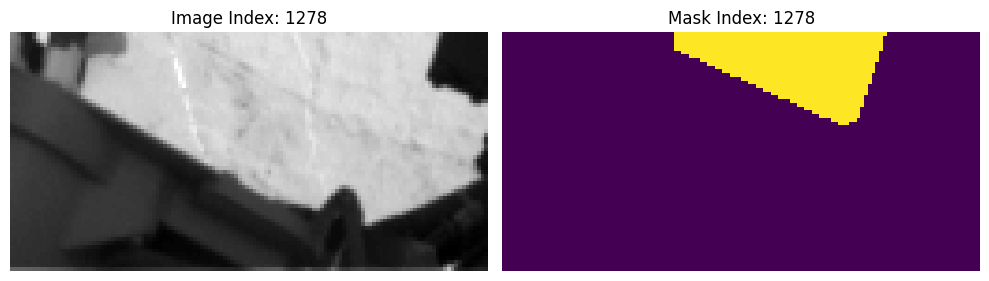

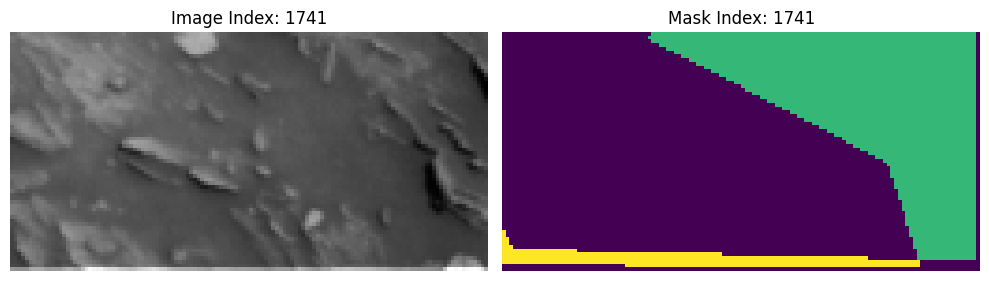

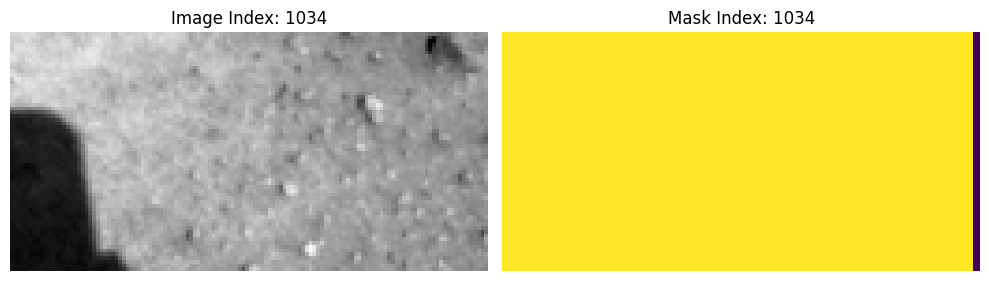

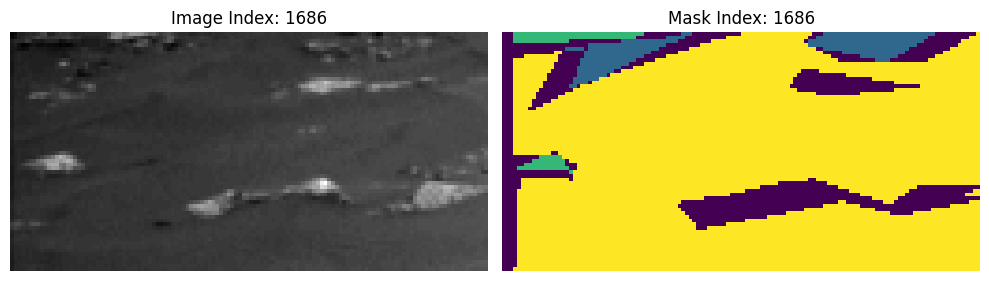

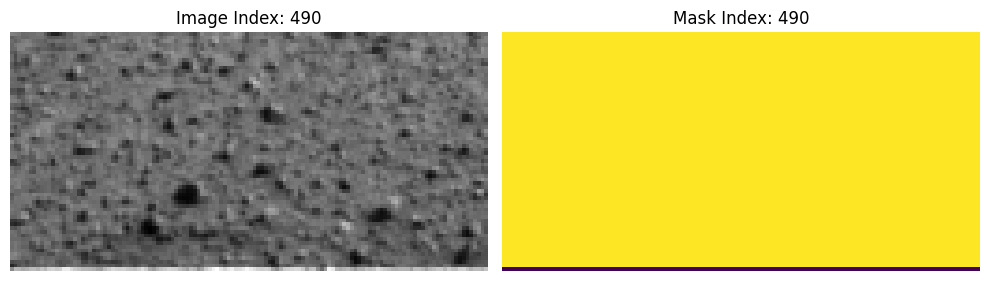

In [3]:
import random

# Visualize random image-mask pairs
for _ in range(5):
    idx = random.randint(0, len(X_train) - 1)
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    # Display input image
    ax[0].imshow(X_train[idx], cmap="gray")
    ax[0].set_title(f"Image Index: {idx}")
    ax[0].axis("off")

    # Display corresponding mask
    ax[1].imshow(y_train[idx], cmap="viridis")
    ax[1].set_title(f"Mask Index: {idx}")
    ax[1].axis("off")

    plt.tight_layout()
    plt.show()

## LETS DO SOME AUGMENTATION!!

## invert image

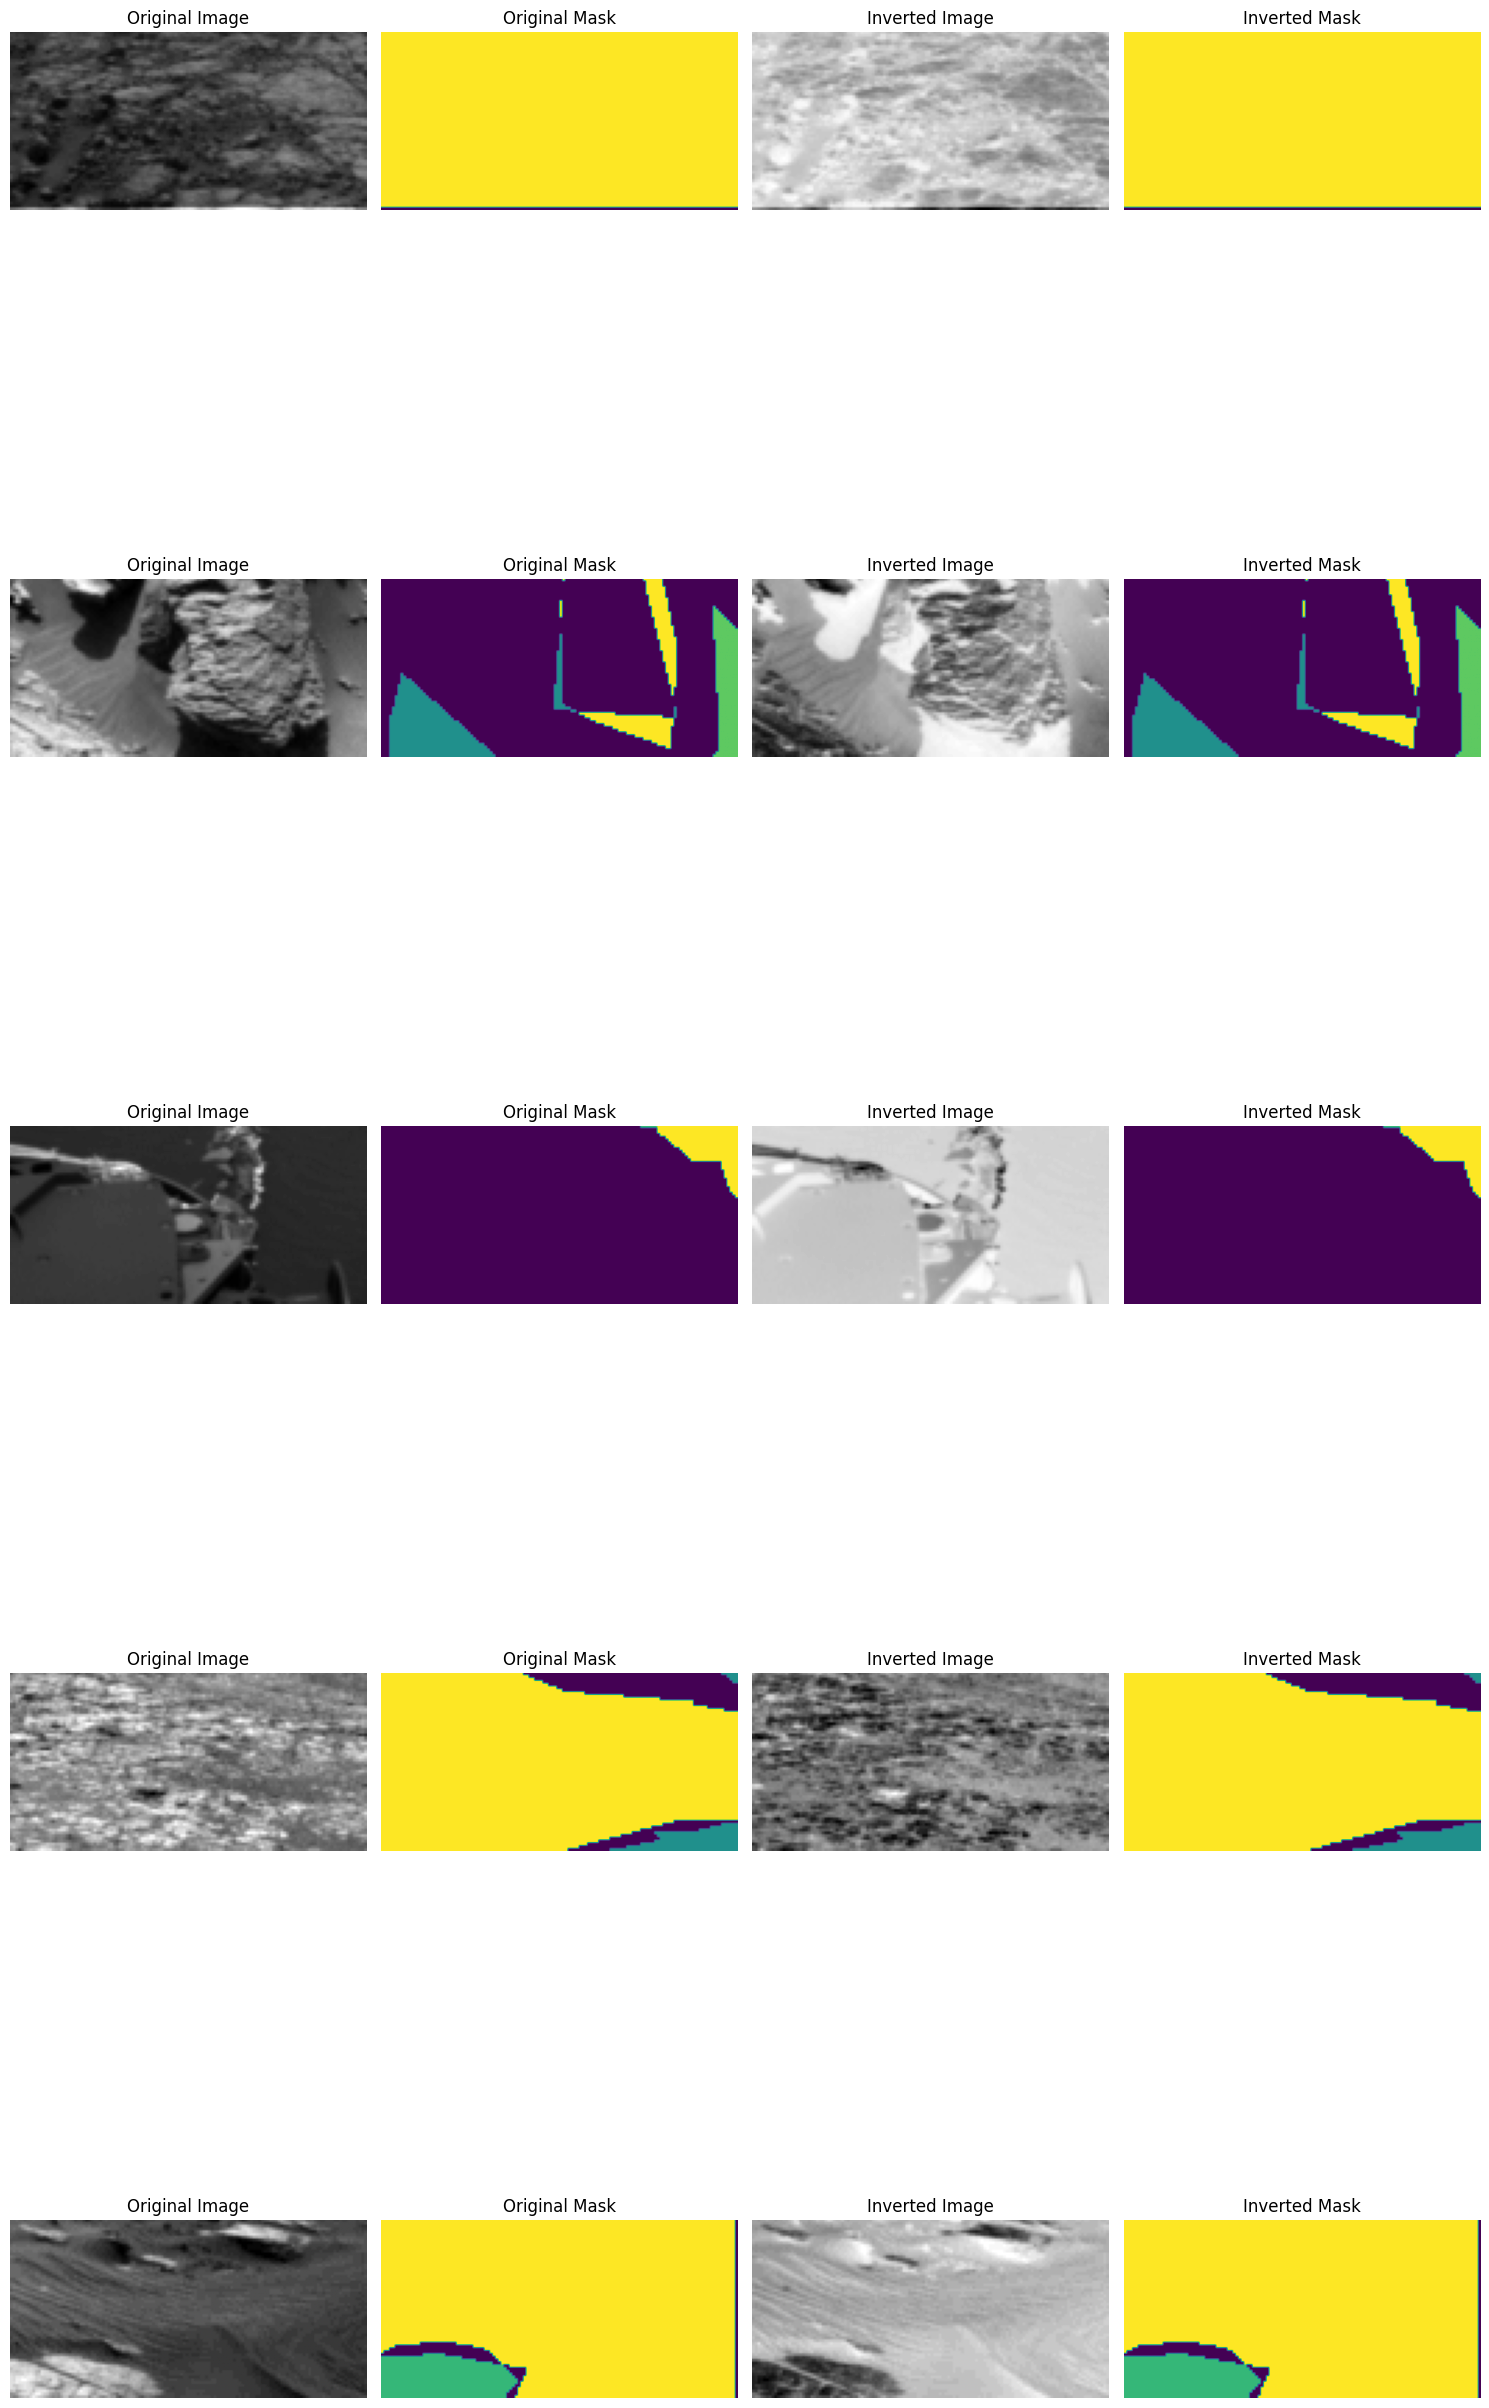

In [4]:


import numpy as np
from skimage.util import random_noise

# Define augmentation functions with mask handling
def invert_image(image, mask):
    return 255 - image, mask  # Mask remains unchanged

def add_salt_and_pepper_noise(image, mask, amount=0.02):
    """
    Add salt-and-pepper noise to an image, preserving its grayscale range.

    Args:
        image (np.ndarray): Input grayscale image with range [0, 255].
        mask (np.ndarray): Corresponding mask (unchanged).
        amount (float): Proportion of image pixels to replace with noise.

    Returns:
        noisy_image (np.ndarray): Image with salt-and-pepper noise applied.
        mask (np.ndarray): Unchanged mask.
    """
    # Normalize the image to [0, 1]
    normalized_image = image / 255.0
    # Add salt-and-pepper noise
    noisy_image = random_noise(normalized_image, mode='s&p', amount=amount)
    # Scale back to [0, 255]
    noisy_image = (noisy_image * 255).astype(np.uint8)
    return noisy_image, mask


"""def rotate_image(image, mask, angle):
    rotated_image = rotate(image, angle, reshape=False, mode='constant', cval=0)
    rotated_mask = rotate(mask, angle, reshape=False, mode='constant', order=0)
    return rotated_image, rotated_mask"""
"""
def adjust_brightness(image, mask, factor=1.2):
    brightened_image = np.clip(image * factor, 0, 255).astype(np.uint8)
    return brightened_image, mask  # Mask remains unchanged"""

# Visualize augmentations with masks
def visualize_all_augmentations(images, masks):
    plt.figure(figsize=(15, 30))
    for i, (image, mask) in enumerate(zip(images, masks)):
        # Original image and mask
        plt.subplot(len(images), 4, i * 4 + 1)
        plt.imshow(image, cmap="gray")
        plt.title("Original Image")
        plt.axis("off")

        plt.subplot(len(images), 4, i * 4 + 2)
        plt.imshow(mask, cmap="viridis")
        plt.title("Original Mask")
        plt.axis("off")

        # Inversion
        inverted_image, inverted_mask = invert_image(image, mask)
        plt.subplot(len(images), 4, i * 4 + 3)
        plt.imshow(inverted_image, cmap="gray")
        plt.title("Inverted Image")
        plt.axis("off")

        plt.subplot(len(images), 4, i * 4 + 4)
        plt.imshow(inverted_mask, cmap="viridis")
        plt.title("Inverted Mask")
        plt.axis("off")

    plt.tight_layout()
    plt.show()


# Randomly select 5 samples from the dataset
random_indices = np.random.choice(len(X_train), size=5, replace=False)
sample_images = X_train[random_indices]
sample_masks = y_train[random_indices]

# Visualize augmentations
visualize_all_augmentations(sample_images, sample_masks)


### rotation

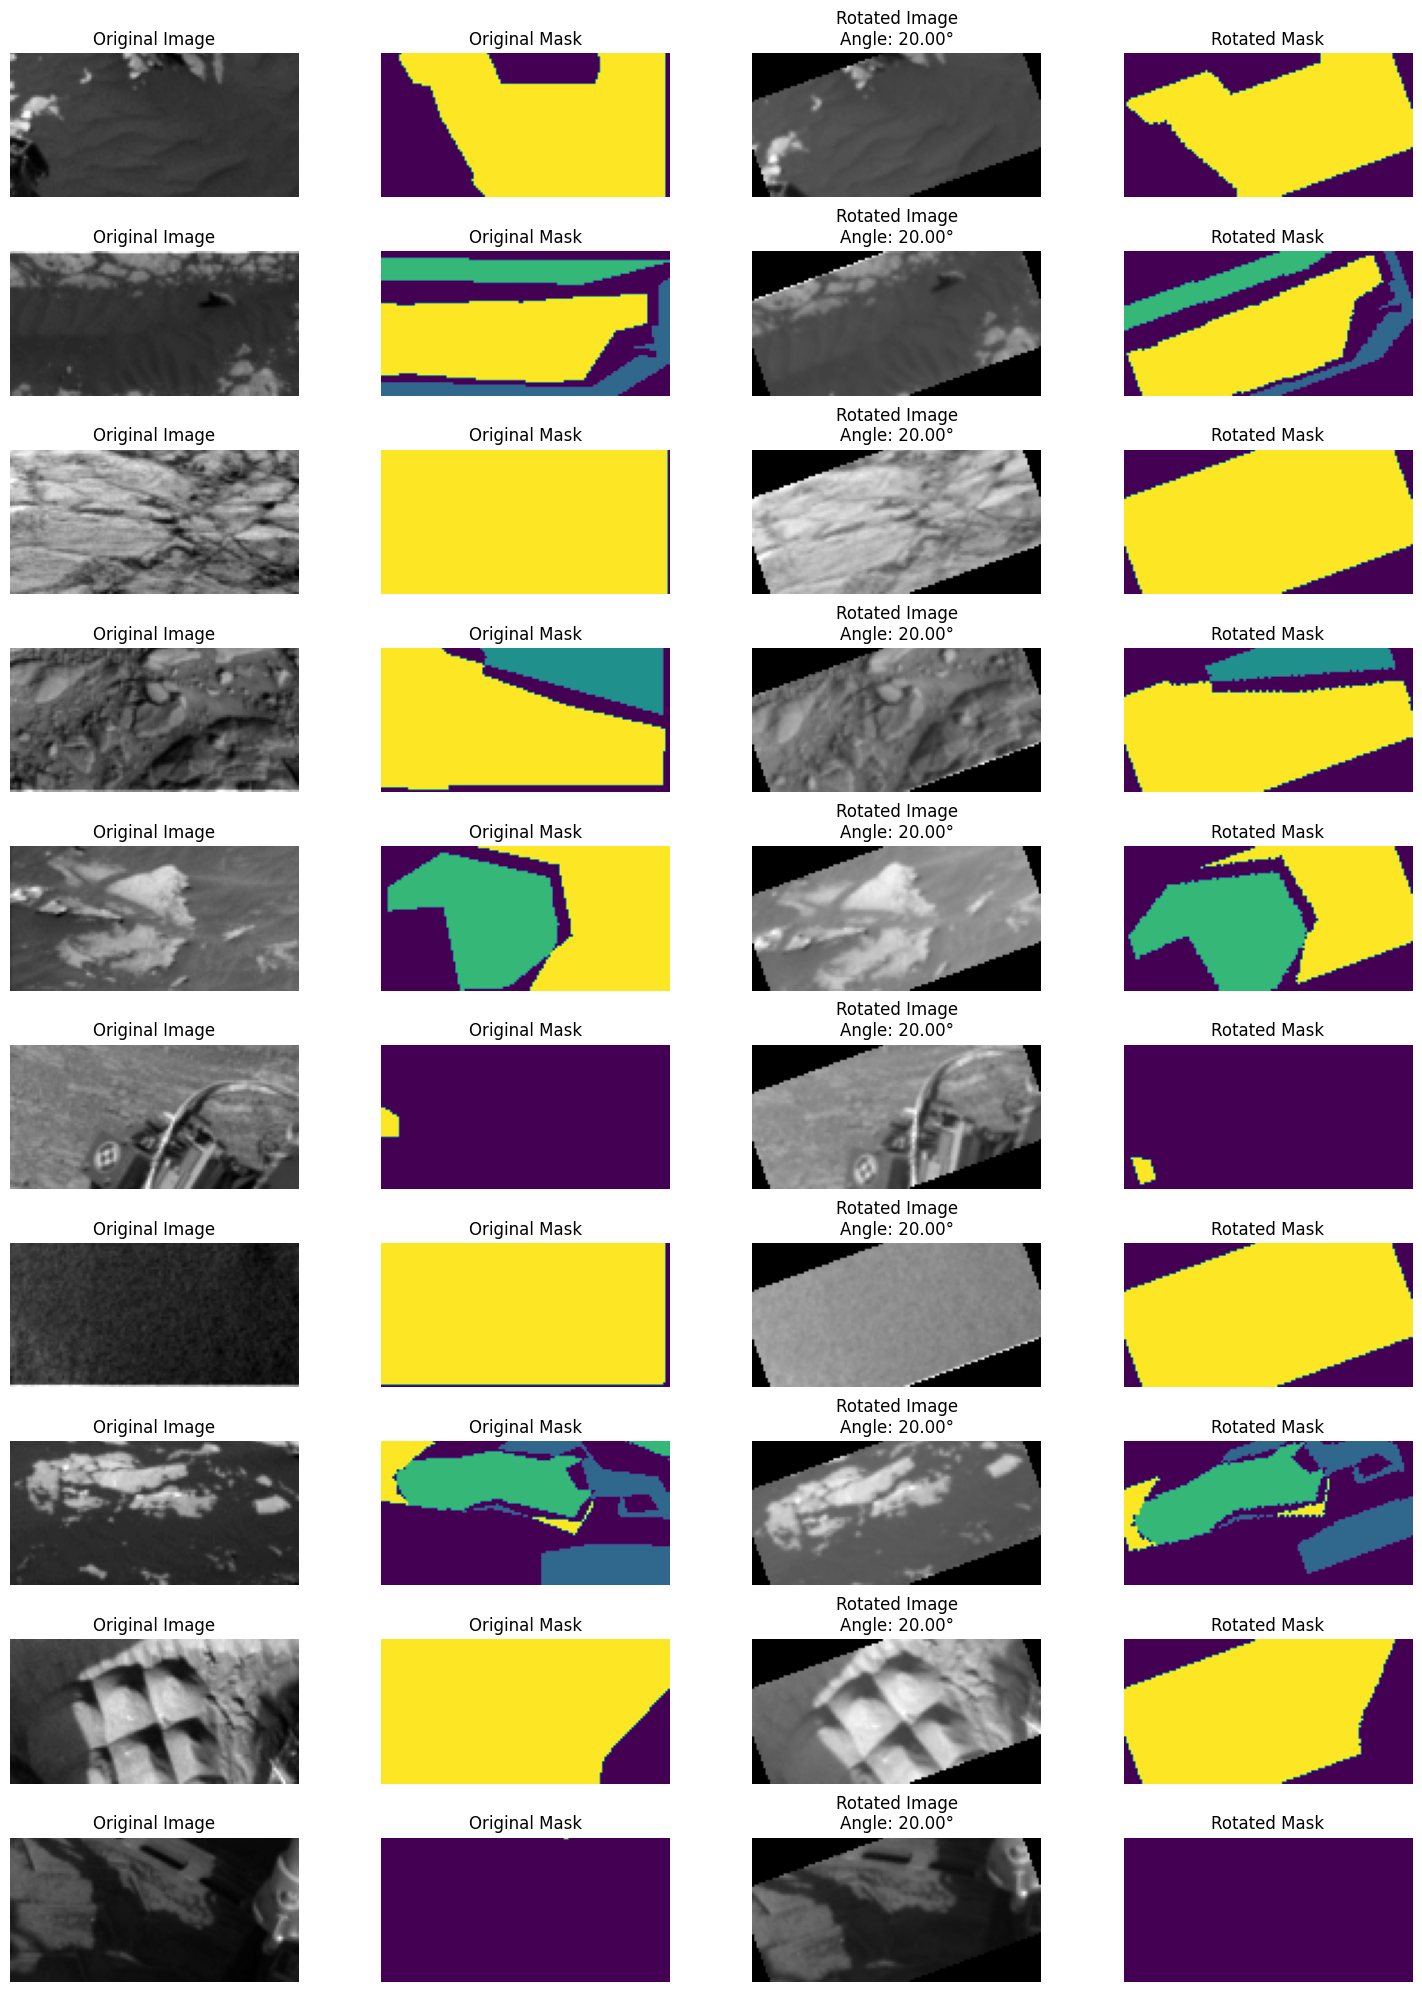

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import rotate

# Define the rotation function using scipy
def rotate_image_and_mask(image, mask, angle):
    """
    Rotate a grayscale image and its corresponding mask by a given angle.
    """
    # Rotate the grayscale image (bilinear interpolation)
    rotated_image = rotate(image, angle, reshape=False, mode="constant", order=1)

    # Rotate the mask (nearest-neighbor interpolation)
    rotated_mask = rotate(mask, angle, reshape=False, mode="constant", order=0)

    return rotated_image, rotated_mask

# Randomly select 10 images
random_indices = np.random.choice(len(X_train), size=10, replace=False)
selected_images = X_train[random_indices]
selected_masks = y_train[random_indices]

# Apply random rotation and visualize
plt.figure(figsize=(15, 20))
for i, (image, mask) in enumerate(zip(selected_images, selected_masks)):
    # Generate a random angle for rotation
    angle = np.random.uniform(20, 20)  # Random angle between -30° and 30°

    # Rotate the image and mask
    rotated_image, rotated_mask = rotate_image_and_mask(image, mask, angle)

    # Plot original and rotated images/masks
    plt.subplot(10, 4, i * 4 + 1)
    plt.imshow(image, cmap="gray")
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(10, 4, i * 4 + 2)
    plt.imshow(mask, cmap="viridis")
    plt.title("Original Mask")
    plt.axis("off")

    plt.subplot(10, 4, i * 4 + 3)
    plt.imshow(rotated_image, cmap="gray")
    plt.title(f"Rotated Image\nAngle: {angle:.2f}°")
    plt.axis("off")

    plt.subplot(10, 4, i * 4 + 4)
    plt.imshow(rotated_mask, cmap="viridis")
    plt.title("Rotated Mask")
    plt.axis("off")

plt.tight_layout()
plt.show()


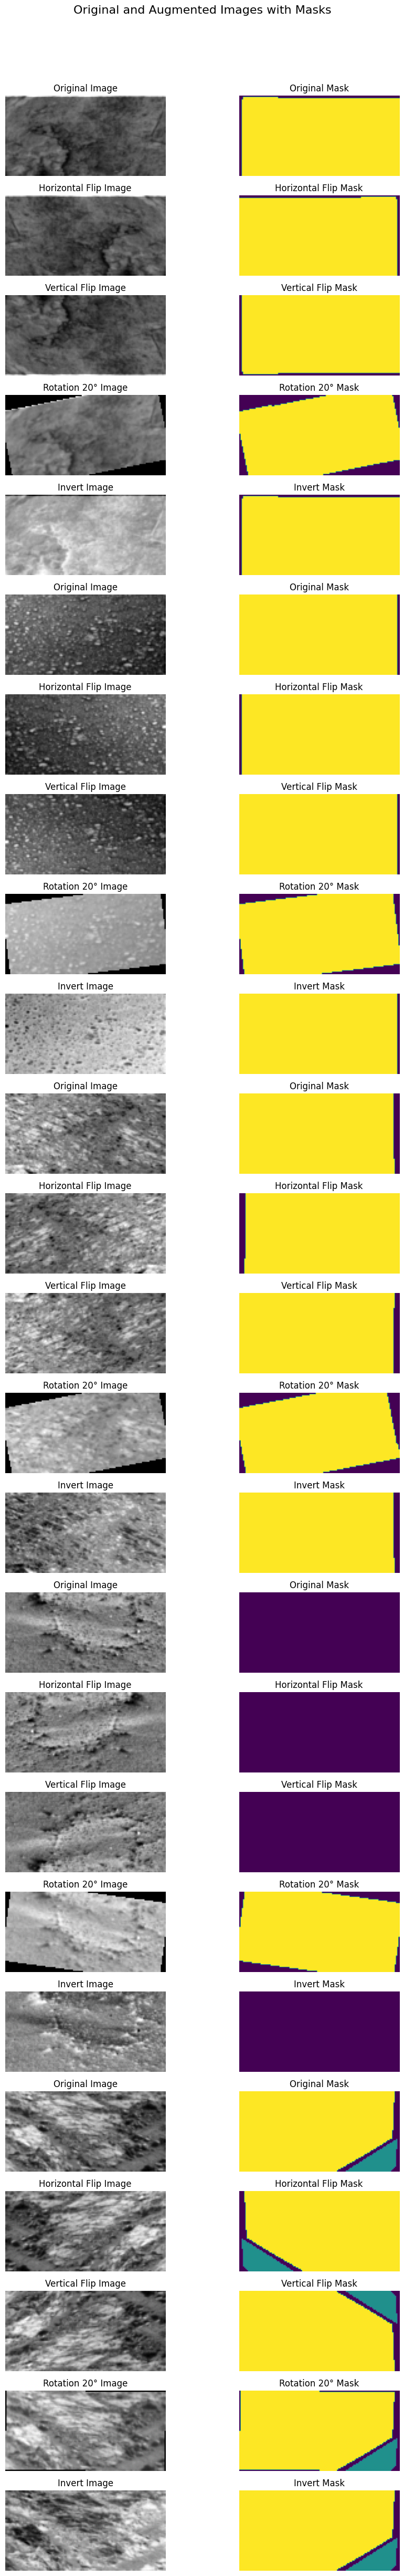

In [6]:
# Helper functions for applying augmentations
def augment_image_and_mask(image, mask, augment_type):
    if augment_type == "Horizontal Flip":
        return np.fliplr(image), np.fliplr(mask)
    elif augment_type == "Vertical Flip":
        return np.flipud(image), np.flipud(mask)
    elif augment_type == "Rotation 20°":
        angle = np.random.uniform(-20, 20)
        # Rotate the grayscale image (bilinear interpolation)
        rotated_image = rotate(image, angle, reshape=False, mode="constant", order=1)

        # Rotate the mask (nearest-neighbor interpolation)
        rotated_mask = rotate(mask, angle, reshape=False, mode="constant", order=0)

        return rotated_image, rotated_mask
    elif augment_type=="Invert":
        inverted_image, inverted_mask = invert_image(image, mask)
        return inverted_image,inverted_mask
        
    """elif augment_type == "Zoom (0.8-1.2)":
        zoom_factor = random.uniform(0.8, 1.2)
        zoom_image = np.clip(image * zoom_factor, 0, 255)
        return zoom_image, mask
    elif augment_type == "Shift (Width and Height)":
        shift_x, shift_y = random.uniform(-0.1, 0.1), random.uniform(-0.1, 0.1)
        return shift(image, [shift_x * image.shape[0], shift_y * image.shape[1]]), shift(mask, [shift_x * mask.shape[0], shift_y * mask.shape[1]], order=0)"""
    return image, mask

# Define augmentations
data_augmentations = {
    "Horizontal Flip": "Horizontal Flip",
    "Vertical Flip": "Vertical Flip",
    "Rotation 20°": "Rotation 20°",
    "Invert":"Invert"
    #"Zoom (0.8-1.2)": "Zoom (0.8-1.2)",
    #"Shift (Width and Height)": "Shift (Width and Height)",
}

# Visualize 5 random images and masks with augmentations
random_indices = np.random.choice(len(X_train), size=5, replace=False)
# Adjusting to display original image/mask with augmentations below each
fig, axes = plt.subplots(len(random_indices) * (1 + len(data_augmentations)), 2, figsize=(10, 50))
fig.suptitle("Original and Augmented Images with Masks", fontsize=16)

for idx, random_idx in enumerate(random_indices):
    original_image = X_train[random_idx]
    original_mask = y_train[random_idx]

    # Plot original image and mask
    row = idx * (1 + len(data_augmentations))  # Calculate starting row for each original image
    axes[row, 0].imshow(original_image, cmap='gray')
    axes[row, 0].set_title("Original Image")
    axes[row, 0].axis('off')

    axes[row, 1].imshow(original_mask)
    axes[row, 1].set_title("Original Mask")
    axes[row, 1].axis('off')

    # Apply augmentations and plot augmented images and masks
    for aug_idx, (augmentation_name, augment_type) in enumerate(data_augmentations.items()):
        augmented_image, augmented_mask = augment_image_and_mask(original_image, original_mask, augment_type)

        axes[row + aug_idx + 1, 0].imshow(augmented_image , cmap='gray' )
        axes[row + aug_idx + 1, 0].set_title(f"{augmentation_name} Image")
        axes[row + aug_idx + 1, 0].axis('off')

        axes[row + aug_idx + 1, 1].imshow(augmented_mask)
        axes[row + aug_idx + 1, 1].set_title(f"{augmentation_name} Mask")
        axes[row + aug_idx + 1, 1].axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [7]:
import os
import matplotlib.pyplot as plt

# Directory where augmented files are stored
output_dir = "augmented_data"
os.makedirs(output_dir, exist_ok=True)

# Re-save augmented datasets to the directory with structured filenames
for augmentation_name, augment_type in data_augmentations.items():
    augmented_images = []
    augmented_masks = []

    for image, mask in zip(X_train, y_train):
        aug_image, aug_mask = augment_image_and_mask(image, mask, augment_type)
        augmented_images.append(aug_image)
        augmented_masks.append(aug_mask)

    # Convert lists to numpy arrays
    augmented_images = np.array(augmented_images)
    augmented_masks = np.array(augmented_masks)

    # Save to npz file
    output_path = os.path.join(output_dir, f"{augmentation_name.replace(' ', '_').lower()}.npz")
    np.savez_compressed(output_path, augmented_images=augmented_images, augmented_masks=augmented_masks)


File: rotation_20°.npz
  Key: augmented_images, Shape: (2004, 64, 128)
  Key: augmented_masks, Shape: (2004, 64, 128)


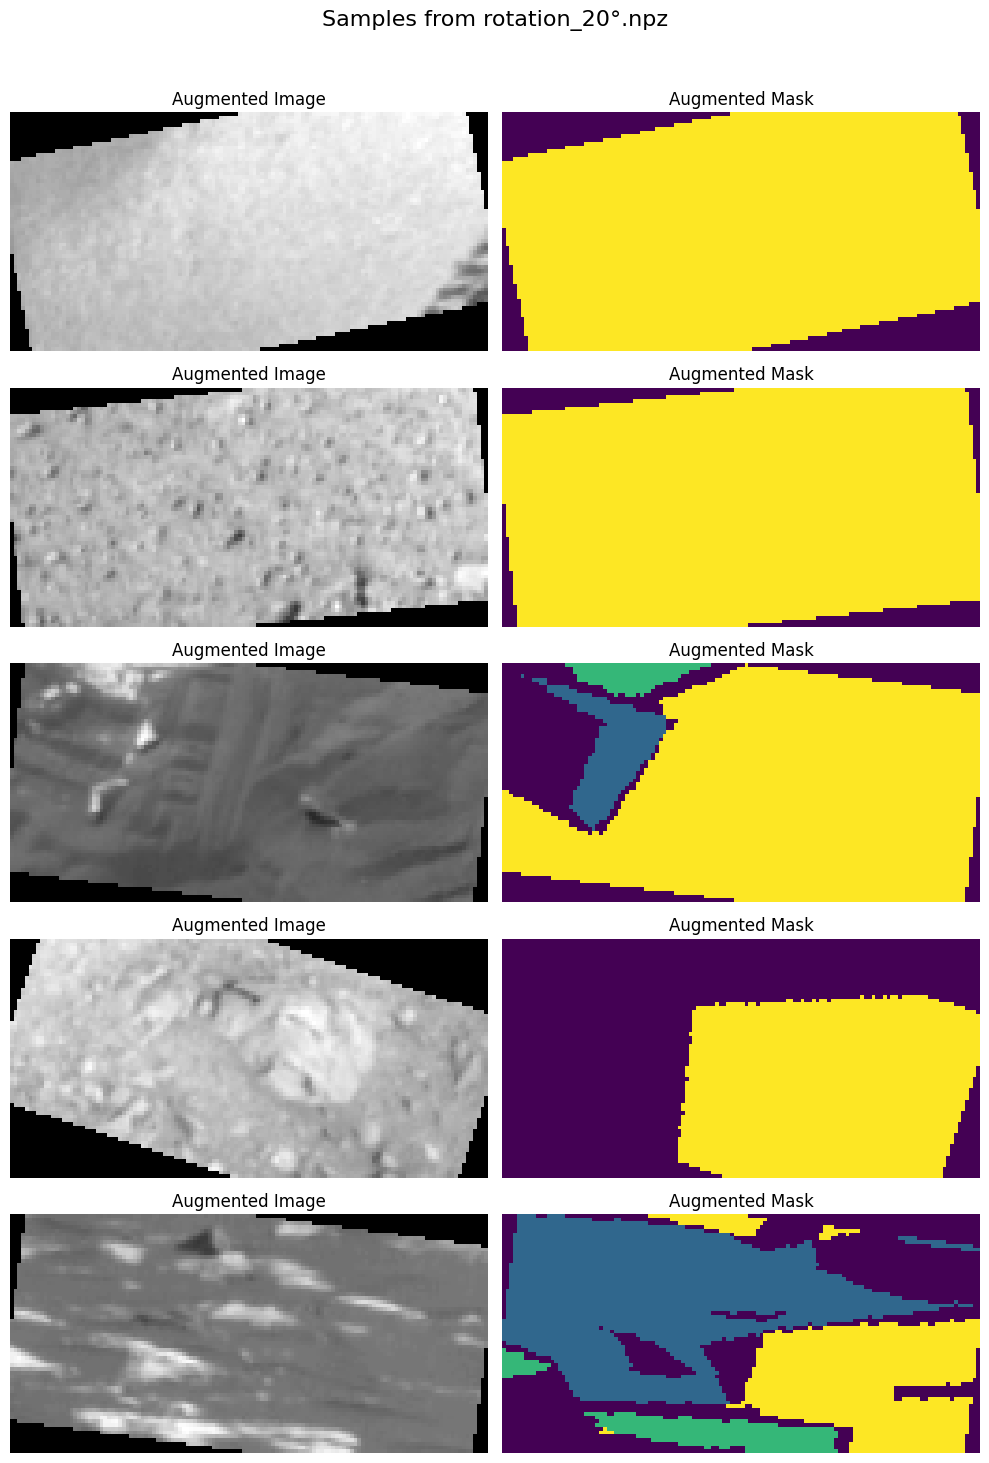

File: invert.npz
  Key: augmented_images, Shape: (2004, 64, 128)
  Key: augmented_masks, Shape: (2004, 64, 128)


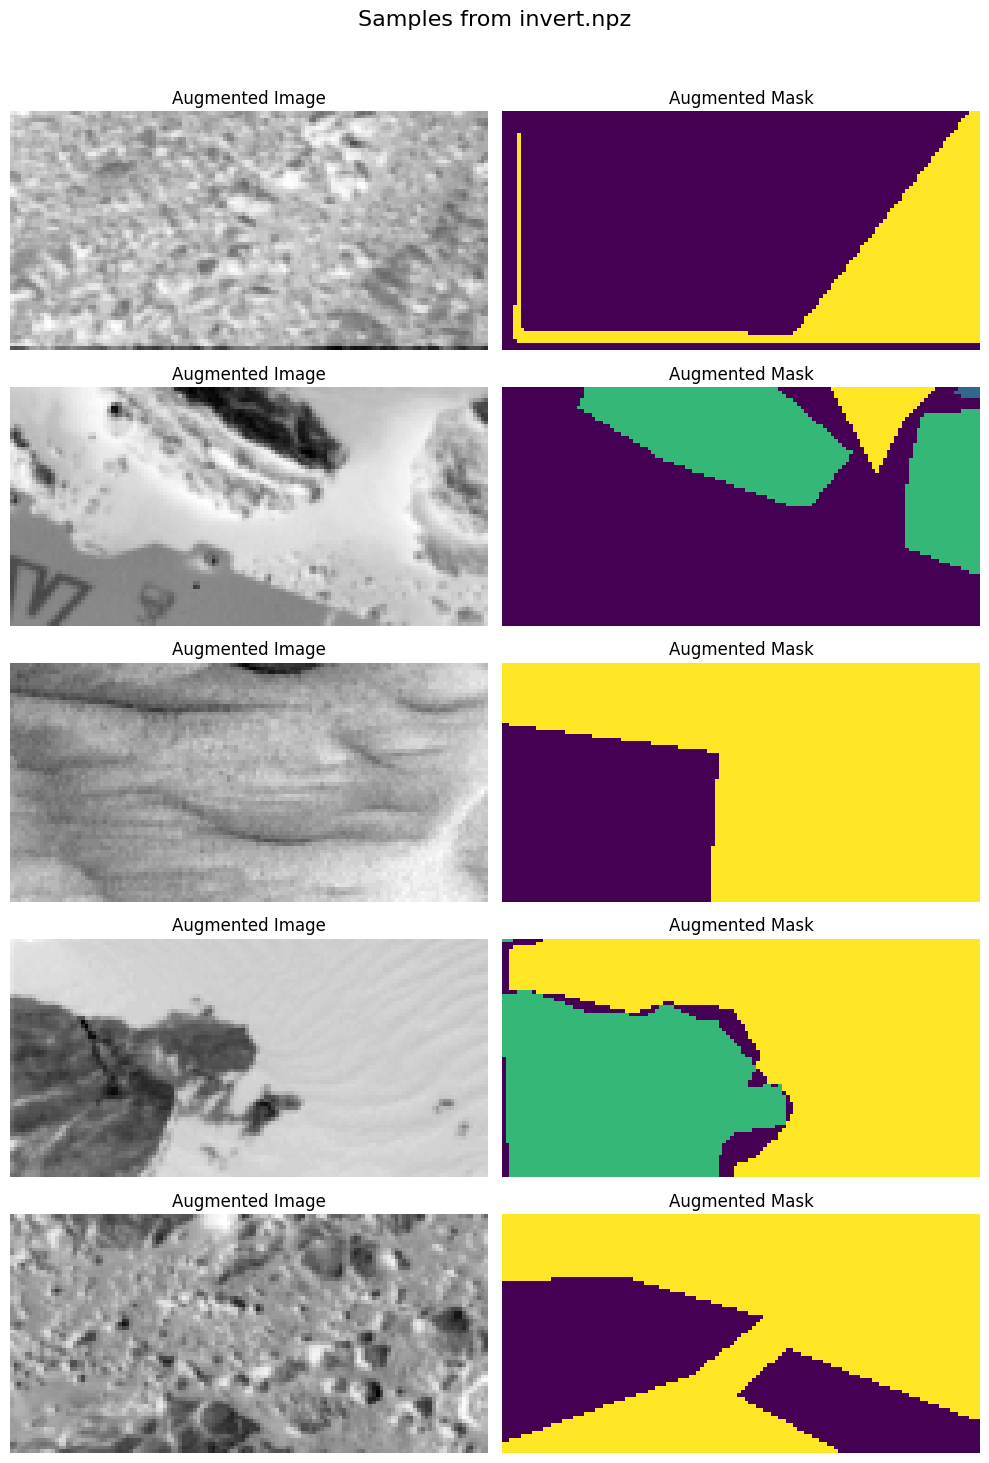

File: vertical_flip.npz
  Key: augmented_images, Shape: (2004, 64, 128)
  Key: augmented_masks, Shape: (2004, 64, 128)


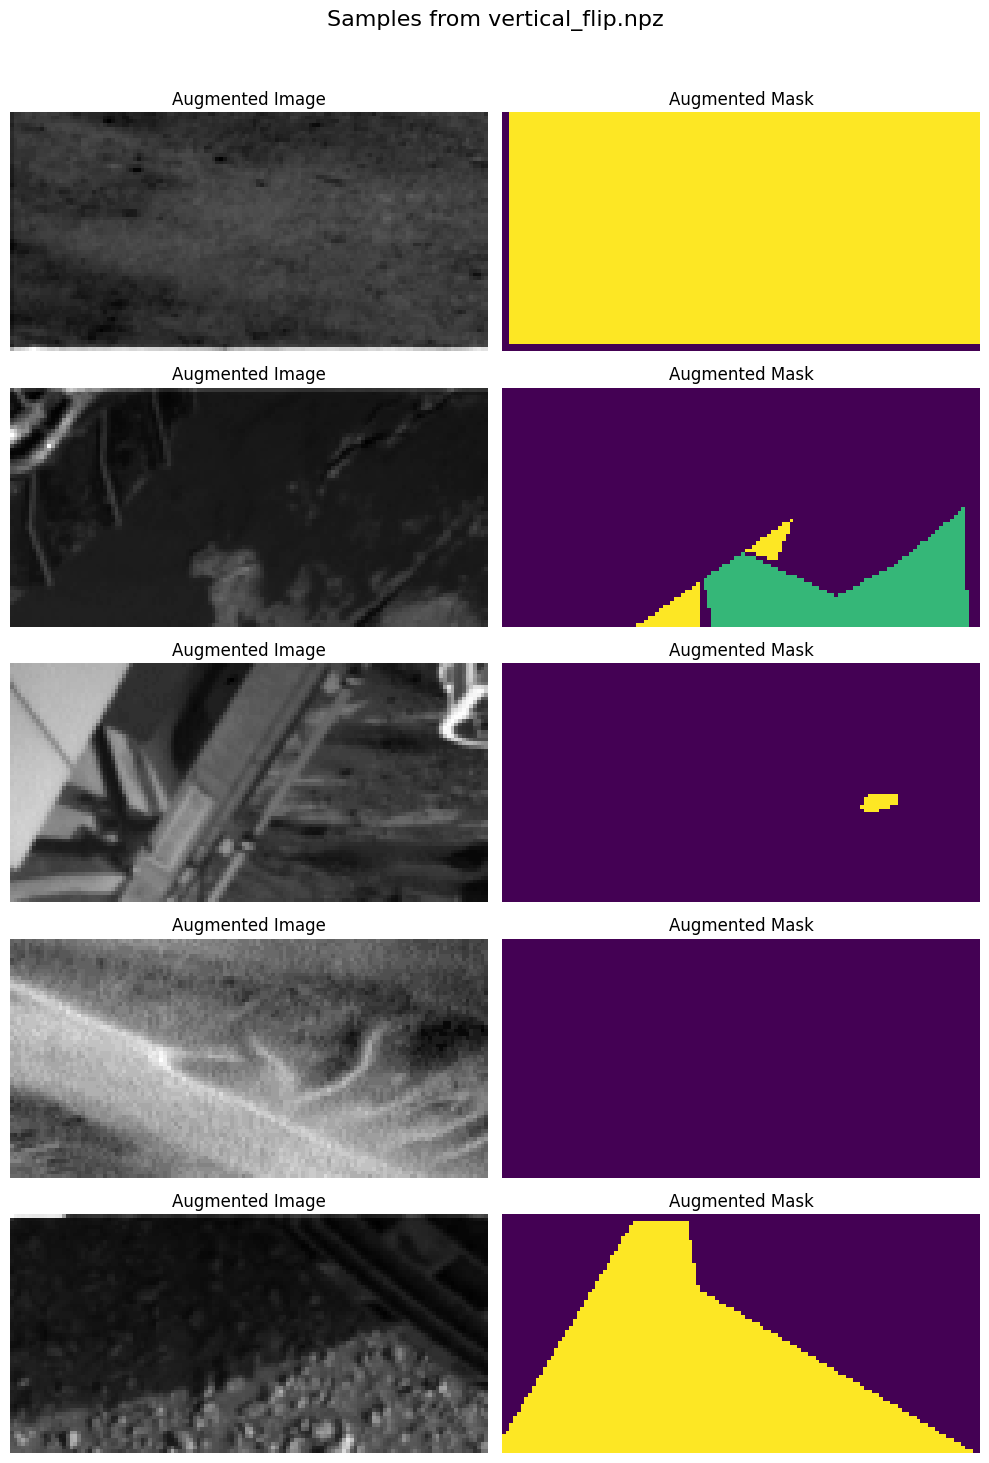

File: horizontal_flip.npz
  Key: augmented_images, Shape: (2004, 64, 128)
  Key: augmented_masks, Shape: (2004, 64, 128)


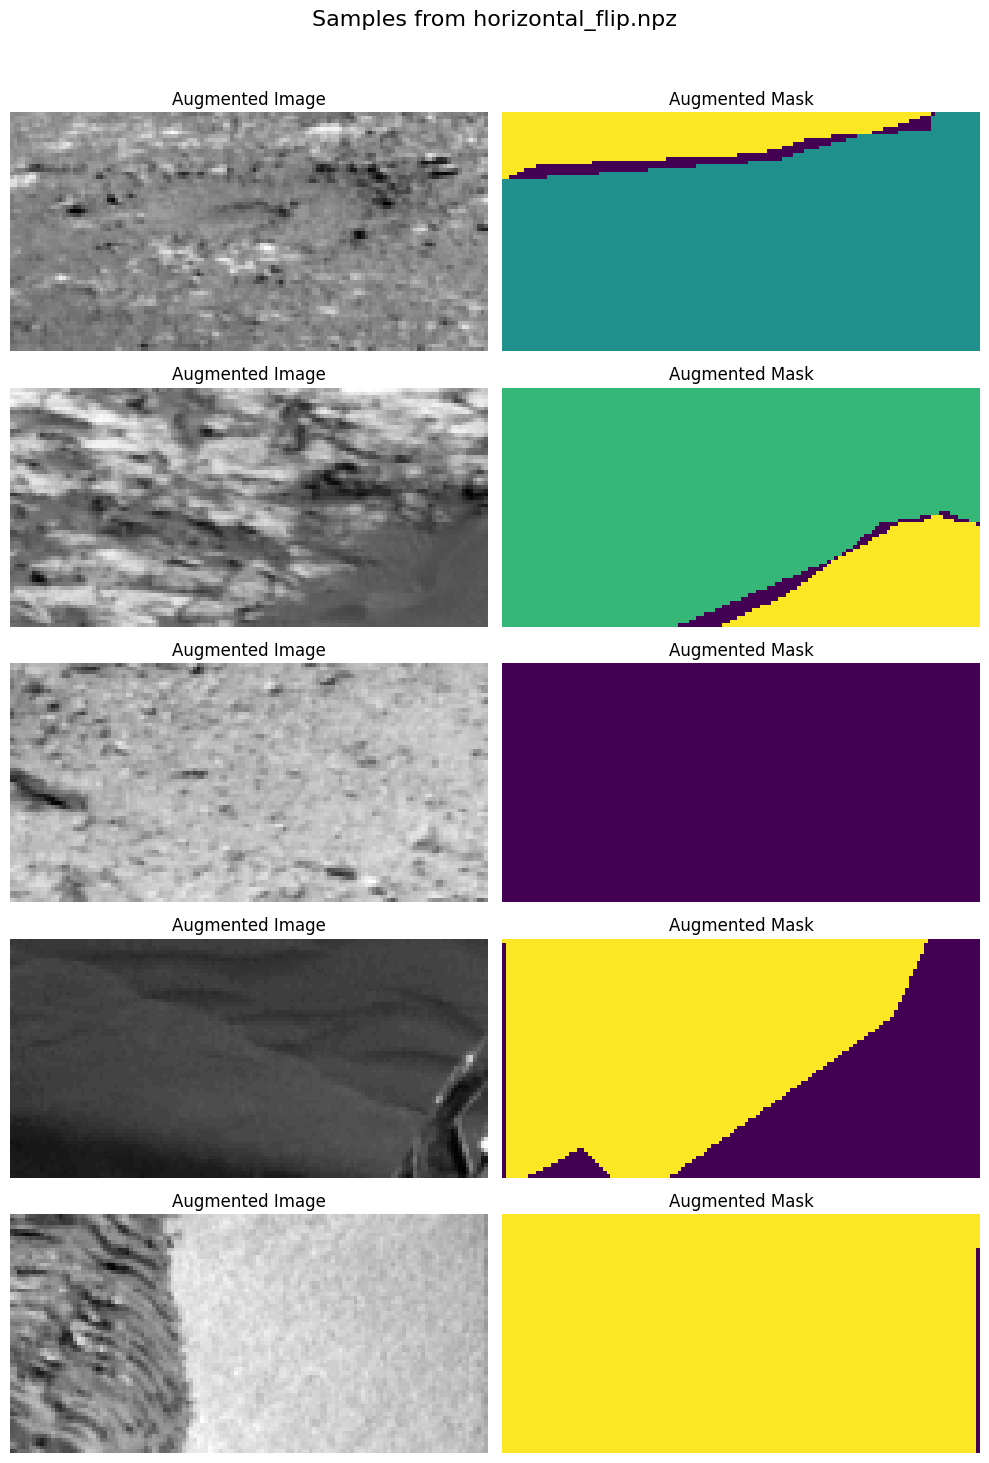

In [8]:
# Read the saved files and display details
output_dir="/kaggle/working/augmented_data"
for file_name in os.listdir(output_dir):
    if file_name.endswith(".npz"):
        file_path = os.path.join(output_dir, file_name)
        data = np.load(file_path)

        # Display keys and their shapes
        print(f"File: {file_name}")
        for key in data.keys():
            print(f"  Key: {key}, Shape: {data[key].shape}")

        # Plot 5 random images and masks
        fig, axes = plt.subplots(5, 2, figsize=(10, 15))
        fig.suptitle(f"Samples from {file_name}", fontsize=16)
        for i in range(5):
            random_idx = np.random.randint(data["augmented_images"].shape[0])
            axes[i, 0].imshow(data["augmented_images"][random_idx], cmap="gray")
            axes[i, 0].set_title("Augmented Image")
            axes[i, 0].axis("off")
            axes[i, 1].imshow(data["augmented_masks"][random_idx])
            axes[i, 1].set_title("Augmented Mask")
            axes[i, 1].axis("off")
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()

## 🛠️ Train and Save the Model

In [9]:
# Load the rotation augmentation dataset
rotation_file_path = os.path.join("/kaggle/working/augmented_data/horizontal_flip.npz")
rotation_data = np.load(rotation_file_path)

# Extract augmented images and masks
augmented_images = rotation_data["augmented_images"]
augmented_masks = rotation_data["augmented_masks"]

# Merge with original X_train and y_train
X_train = np.concatenate([X_train, augmented_images], axis=0)
y_train = np.concatenate([y_train, augmented_masks], axis=0)

# Display the new shapes
print(f"New X_train shape: {X_train.shape}")
print(f"New y_train shape: {y_train.shape}")

New X_train shape: (4008, 64, 128)
New y_train shape: (4008, 64, 128)


In [10]:
# Load the rotation augmentation dataset
rotation_file_path = os.path.join("/kaggle/working/augmented_data/vertical_flip.npz")
rotation_data = np.load(rotation_file_path)

# Extract augmented images and masks
augmented_images = rotation_data["augmented_images"]
augmented_masks = rotation_data["augmented_masks"]

# Merge with original X_train and y_train
X_train = np.concatenate([X_train, augmented_images], axis=0)
y_train = np.concatenate([y_train, augmented_masks], axis=0)

# Display the new shapes
print(f"New X_train shape: {X_train.shape}")
print(f"New y_train shape: {y_train.shape}")

New X_train shape: (6012, 64, 128)
New y_train shape: (6012, 64, 128)


In [11]:
# Load the rotation augmentation dataset
rotation_file_path = os.path.join("/kaggle/working/augmented_data/rotation_20°.npz")
rotation_data = np.load(rotation_file_path)

# Extract augmented images and masks
augmented_images = rotation_data["augmented_images"]
augmented_masks = rotation_data["augmented_masks"]

# Merge with original X_train and y_train
X_train = np.concatenate([X_train, augmented_images], axis=0)
y_train = np.concatenate([y_train, augmented_masks], axis=0)

# Display the new shapes
print(f"New X_train shape: {X_train.shape}")
print(f"New y_train shape: {y_train.shape}")

New X_train shape: (8016, 64, 128)
New y_train shape: (8016, 64, 128)


In [12]:
# Load the rotation augmentation dataset
rotation_file_path = os.path.join("/kaggle/working/augmented_data/invert.npz")
rotation_data = np.load(rotation_file_path)

# Extract augmented images and masks
augmented_images = rotation_data["augmented_images"]
augmented_masks = rotation_data["augmented_masks"]

# Merge with original X_train and y_train
X_train = np.concatenate([X_train, augmented_images], axis=0)
y_train = np.concatenate([y_train, augmented_masks], axis=0)

# Display the new shapes
print(f"New X_train shape: {X_train.shape}")
print(f"New y_train shape: {y_train.shape}")

New X_train shape: (10020, 64, 128)
New y_train shape: (10020, 64, 128)


In [13]:
# Add color channel and rescale pixels between 0 and 1
X_train = X_train[..., np.newaxis] / 255.0
X_test = X_test[..., np.newaxis] / 255.0

input_shape = X_train.shape[1:]
num_classes = len(np.unique(y_train))

print(f"Input shape: {input_shape}")
print(f"Number of classes: {num_classes}")

Input shape: (64, 128, 1)
Number of classes: 5


In [14]:
X_val = X_val[..., np.newaxis] / 255.0

In [15]:
print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"y_train shape: {y_train.shape}")

X_train shape: (10020, 64, 128, 1)
X_val shape: (501, 64, 128, 1)
y_train shape: (10020, 64, 128)


In [16]:
# Custom callback for visualization
class VisualizeSegmentationCallback(tf.keras.callbacks.Callback):
    def __init__(self, X_train, y_train, num_images=2):
        super().__init__()
        self.X_train = X_train
        self.y_train = y_train
        self.num_images = num_images
        self.selected_indices = []

        # Identify images containing at least 4 classes
        for i in range(len(y_train)):
            if len(np.unique(y_train[i])) >= 4:  # Check for at least 4 classes
                self.selected_indices.append(i)
            if len(self.selected_indices) == num_images:
                break

    def on_epoch_end(self, epoch, logs=None):
        # Plot predictions for the selected images
        fig, axes = plt.subplots(self.num_images, 3, figsize=(15, self.num_images * 5))

        for idx, i in enumerate(self.selected_indices):
            # Extract image and ground truth
            X_sample = self.X_train[i:i + 1]  # Add batch dimension
            y_sample = self.y_train[i]

            # Predict on the image
            predicted_mask = self.model.predict(X_sample)
            predicted_mask = np.argmax(predicted_mask, axis=-1)[0]  # Convert to class labels

            # Visualize the input, ground truth, and predicted mask
            axes[idx, 0].imshow(X_sample[0].squeeze(), cmap="gray")
            axes[idx, 0].set_title("Input Image")
            axes[idx, 0].axis("off")

            axes[idx, 1].imshow(y_sample, cmap="viridis")
            axes[idx, 1].set_title("Ground Truth Mask")
            axes[idx, 1].axis("off")

            axes[idx, 2].imshow(predicted_mask, cmap="viridis")
            axes[idx, 2].set_title(f"Predicted Mask (Epoch {epoch + 1})")
            axes[idx, 2].axis("off")

        plt.tight_layout()
        plt.show()

## Adding advanced tecnics

In [17]:
# Ensure the input shape for both images and masks is correct
X_train = np.squeeze(X_train)  # Remove any singleton dimensions
y_train = np.squeeze(y_train)  # Remove any singleton dimensions

# Check if the channel dimension exists, otherwise add it
if X_train.ndim == 3:  # If missing the channel dimension, add it
    X_train = X_train[..., np.newaxis]

if y_train.ndim == 3:  # Ensure y_train has the correct shape
    y_train = y_train[..., np.newaxis]

print(f"Shape of X_train after reshaping: {X_train.shape}")
print(f"Shape of y_train after reshaping: {y_train.shape}")

Shape of X_train after reshaping: (10020, 64, 128, 1)
Shape of y_train after reshaping: (10020, 64, 128, 1)


In [18]:
# Ensure the input shape for both images and masks is correct
X_val = np.squeeze(X_val)  # Remove any singleton dimensions
y_val= np.squeeze(y_val)  # Remove any singleton dimensions

# Check if the channel dimension exists, otherwise add it
if X_val.ndim == 3:  # If missing the channel dimension, add it
    X_val = X_val[..., np.newaxis]

if y_val.ndim == 3:  # Ensure y_train has the correct shape
    y_val = y_val[..., np.newaxis]

print(f"Shape of X_train after reshaping: {X_val.shape}")
print(f"Shape of y_train after reshaping: {y_val.shape}")

Shape of X_train after reshaping: (501, 64, 128, 1)
Shape of y_train after reshaping: (501, 64, 128, 1)


In [19]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Ensure the input shape for both images and masks is correct
X_train = np.squeeze(X_train)  # Remove singleton dimensions
if X_train.ndim == 3:  # If missing the channel dimension, add it
    X_train = X_train[..., np.newaxis]

y_train = np.squeeze(y_train)  # Ensure that y_train has the correct shape

print(f"Shape of X_train after reshaping: {X_train.shape}")
print(f"Shape of y_train after reshaping: {y_train.shape}")

# Data Augmentation for Images and Masks
image_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],  # Adjust brightness
)

# Masks should only be flipped or translated without interpolation
mask_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)

# Ensure y_train has the correct shape for augmentation
y_train = np.expand_dims(y_train, axis=-1)  # Add channel dimension to masks

# Fit augmentations to the data
image_datagen.fit(X_train)
mask_datagen.fit(y_train)

# Create the generators
image_generator = image_datagen.flow(X_train, batch_size=32, seed=42)
mask_generator = mask_datagen.flow(y_train, batch_size=32, seed=42)

train_generator = zip(image_generator, mask_generator)

# Weighted Loss Function for Class Imbalance
def weighted_categorical_crossentropy(weights):
    weights = tf.constant(weights, dtype=tf.float32)

    def loss(y_true, y_pred):
        # Remove the extra dimension from y_true using tf.squeeze
        y_true = tf.squeeze(y_true, axis=-1)

        y_true = tf.one_hot(tf.cast(y_true, tf.int32), depth=len(weights))
        y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1 - tf.keras.backend.epsilon())
        return -tf.reduce_sum(y_true * tf.math.log(y_pred) * weights, axis=-1)

    return loss

# Convert y_train to integers for class count
y_train_int = y_train.astype(np.int32)

# Calculate class weights based on pixel proportions
class_pixel_counts = np.bincount(y_train_int.flatten(), minlength=num_classes)  # Count pixels for each class
total_pixels = np.sum(class_pixel_counts)  # Total number of pixels
class_weights = total_pixels / (class_pixel_counts + 1e-6)  # Inverse frequency
class_weights /= np.sum(class_weights)  # Normalize to sum to 1

print(f"Class pixel counts: {class_pixel_counts}")
print(f"Calculated class weights: {class_weights}")

# Updated EarlyStopping with min_delta to ignore minimal improvements
early_stopping = EarlyStopping(
    monitor="val_loss",  # Monitor loss instead of validation loss
    patience=30,
    restore_best_weights=True,
    min_delta=1e-4  # Minimum change to qualify as an improvement
)


model_checkpoint = ModelCheckpoint(
    filepath="best_model.keras",
    monitor="val_loss",  # Monitor loss instead of validation loss
    save_best_only=True,
    mode="min",
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",  # Monitor loss instead of validation loss
    factor=0.5,
    patience=5,
    verbose=1,
    mode="min",
    min_lr=1e-6
)

# Visualization Callback for Two Images with At Least 4 Classes
visualize_callback = VisualizeSegmentationCallback(X_val, y_val, num_images=2)




Shape of X_train after reshaping: (10020, 64, 128, 1)
Shape of y_train after reshaping: (10020, 64, 128)
Class pixel counts: [21123299 27102054 19243048 14511071   104368]
Calculated class weights: [0.00483734 0.00377021 0.00531    0.00704156 0.97904089]


In [20]:
import tensorflow as tf

class CustomMeanIoU(tf.keras.metrics.Metric):
    def __init__(self, num_classes, ignore_class=None, name="custom_mean_iou", **kwargs):
        super(CustomMeanIoU, self).__init__(name=name, **kwargs)
        self.num_classes = num_classes
        self.ignore_class = ignore_class

        # Add a confusion matrix to track per-class intersection and union
        self.total_cm = self.add_weight(
            name="total_confusion_matrix",
            shape=(self.num_classes, self.num_classes),
            initializer="zeros",
            dtype=tf.float32,
        )

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Flatten inputs
        y_true = tf.reshape(y_true, [-1])
        y_pred = tf.argmax(y_pred, axis=-1)  # Convert one-hot predictions to class indices
        y_pred = tf.reshape(y_pred, [-1])

        # Compute the confusion matrix
        current_cm = tf.math.confusion_matrix(
            y_true,
            y_pred,
            num_classes=self.num_classes,
            weights=sample_weight,
            dtype=tf.float32,
        )

        # Update the total confusion matrix
        self.total_cm.assign_add(current_cm)

    def result(self):
        # Compute per-class Intersection and Union
        intersection = tf.linalg.diag_part(self.total_cm)
        union = tf.reduce_sum(self.total_cm, axis=0) + tf.reduce_sum(self.total_cm, axis=1) - intersection

        # Mask the ignored class, if specified
        if self.ignore_class is not None:
            intersection = tf.tensor_scatter_nd_update(intersection, [[self.ignore_class]], [0.0])
            union = tf.tensor_scatter_nd_update(union, [[self.ignore_class]], [1.0])  # Avoid division by zero

        # Compute IoU per class
        iou_per_class = tf.divide(intersection, union + tf.keras.backend.epsilon())

        # Compute mean IoU (ignoring the ignored class if applicable)
        valid_classes = tf.reduce_sum(tf.cast(union > 0, tf.float32))
        mean_iou = tf.reduce_sum(iou_per_class) / valid_classes

        return mean_iou

    def reset_states(self):
        # Reset the confusion matrix
        self.total_cm.assign(tf.zeros_like(self.total_cm))


In [21]:
from tensorflow.keras.callbacks import Callback
class SaveBestMeanIoU(Callback):
    def __init__(self, filepath, monitor="val_mean_io_u", mode="max", verbose=1):
        super(SaveBestMeanIoU, self).__init__()
        self.filepath = filepath
        self.monitor = monitor
        self.mode = mode
        self.verbose = verbose
        self.best = -float("inf") if mode == "max" else float("inf")

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        # Debug: Print available keys in logs
        print(f"Available log keys: {logs.keys()}")
        
        # Use the correct log key
        current = logs.get(self.monitor)
        if current is None:
            if self.verbose > 0:
                print(f"Warning: Monitor '{self.monitor}' is not available in logs.")
            return

        if (self.mode == "max" and current > self.best) or (self.mode == "min" and current < self.best):
            self.best = current
            if self.verbose > 0:
                print(f"Epoch {epoch + 1}: {self.monitor} improved to {current:.4f}, saving model.")
            self.model.save(self.filepath)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 64, 128,   │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 64, 128,   │        640 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 64, 128,   │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 128,   │        128 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 64, 128,   │          0 │ conv2d_1[0][0],   │
│                     │ 64)               │            │ conv2d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 32, 64,    │          0 │ add[0][0]         │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 32, 64,    │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 64,    │    147,584 │ conv2d_3[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 64,    │      8,320 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 32, 64,    │          0 │ conv2d_4[0][0],   │
│                     │ 128)              │            │ conv2d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 16, 32,    │          0 │ add_1[0][0]       │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 32,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 16, 32,    │    590,080 │ conv2d_6[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 16, 32,    │     33,024 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 16, 32,    │          0 │ conv2d_7[0][0],   │
│                     │ 256)              │            │ conv2d_8[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 8, 16,     │          0 │ add_2[0][0]       │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 8, 16,     │  1,180,160 │ max_pooling2d_2[

 Total params: 8,041,989 (30.68 MB)

 Trainable params: 8,041,989 (30.68 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/1000


I0000 00:00:1733326023.265938      73 service.cc:145] XLA service 0x7dcaf4001e50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733326023.265996      73 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1733326023.266000      73 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
W0000 00:00:1733326023.898403      73 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1733326023.901320      73 assert_op.cc:38] Ignoring Assert operator confusion_matrix/assert_non_negative/assert_less_equal/Assert/AssertGuard/Assert
W0000 00:00:1733326023.928140      73 assert_op.cc:38] Ignoring Assert operator confusion_matrix/assert_non_negative_1/assert_less_equal/Assert/AssertGuard/Assert
W0000 00:00:1733326023.930706      73 assert_op.cc:38] Ignoring Assert operator confu

313/314 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.3463 - custom_mean_iou: 0.0809 - loss: 1.3819 - mean_io_u: 0.0972

W0000 00:00:1733326100.420023      73 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1733326100.421237      73 assert_op.cc:38] Ignoring Assert operator confusion_matrix/assert_non_negative/assert_less_equal/Assert/AssertGuard/Assert
W0000 00:00:1733326100.429205      73 assert_op.cc:38] Ignoring Assert operator confusion_matrix/assert_non_negative_1/assert_less_equal/Assert/AssertGuard/Assert
W0000 00:00:1733326100.430555      73 assert_op.cc:38] Ignoring Assert operator confusion_matrix/assert_less/Assert/AssertGuard/Assert
W0000 00:00:1733326100.432189      73 assert_op.cc:38] Ignoring Assert operator confusion_matrix/assert_less_1/Assert/AssertGuard/Assert


314/314 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - accuracy: 0.3464 - custom_mean_iou: 0.0810 - loss: 1.3817 - mean_io_u: 0.0972

W0000 00:00:1733326114.781735      75 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1733326114.784190      75 assert_op.cc:38] Ignoring Assert operator confusion_matrix/assert_non_negative/assert_less_equal/Assert/AssertGuard/Assert
W0000 00:00:1733326114.795458      75 assert_op.cc:38] Ignoring Assert operator confusion_matrix/assert_non_negative_1/assert_less_equal/Assert/AssertGuard/Assert
W0000 00:00:1733326114.797940      75 assert_op.cc:38] Ignoring Assert operator confusion_matrix/assert_less/Assert/AssertGuard/Assert
W0000 00:00:1733326114.800856      75 assert_op.cc:38] Ignoring Assert operator confusion_matrix/assert_less_1/Assert/AssertGuard/Assert
W0000 00:00:1733326116.275026      74 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1733326116.2

Available log keys: dict_keys(['accuracy', 'custom_mean_iou', 'loss', 'mean_io_u', 'val_accuracy', 'val_custom_mean_iou', 'val_loss', 'val_mean_io_u'])
Epoch 1: val_custom_mean_iou improved to 0.1763, saving model.

Epoch 1: val_loss improved from inf to 1.17145, saving model to best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


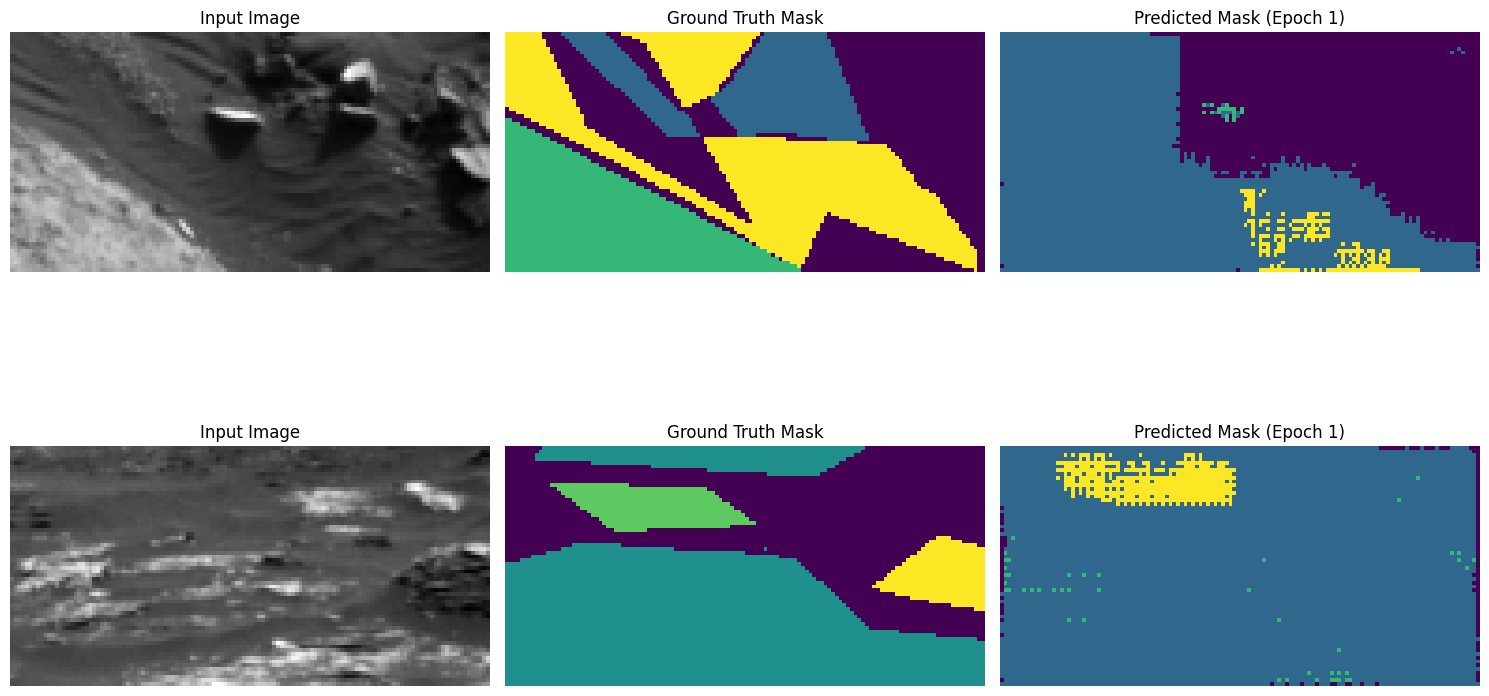

314/314 ━━━━━━━━━━━━━━━━━━━━ 109s 244ms/step - accuracy: 0.3465 - custom_mean_iou: 0.0811 - loss: 1.3815 - mean_io_u: 0.0973 - val_accuracy: 0.4753 - val_custom_mean_iou: 0.1763 - val_loss: 1.1714 - val_mean_io_u: 0.2103 - learning_rate: 1.0000e-04
Epoch 2/1000
313/314 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.4806 - custom_mean_iou: 0.1893 - loss: 1.1326 - mean_io_u: 0.2177Available log keys: dict_keys(['accuracy', 'custom_mean_iou', 'loss', 'mean_io_u', 'val_accuracy', 'val_custom_mean_iou', 'val_loss', 'val_mean_io_u'])
Epoch 2: val_custom_mean_iou improved to 0.2422, saving model.

Epoch 2: val_loss improved from 1.17145 to 1.04203, saving model to best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


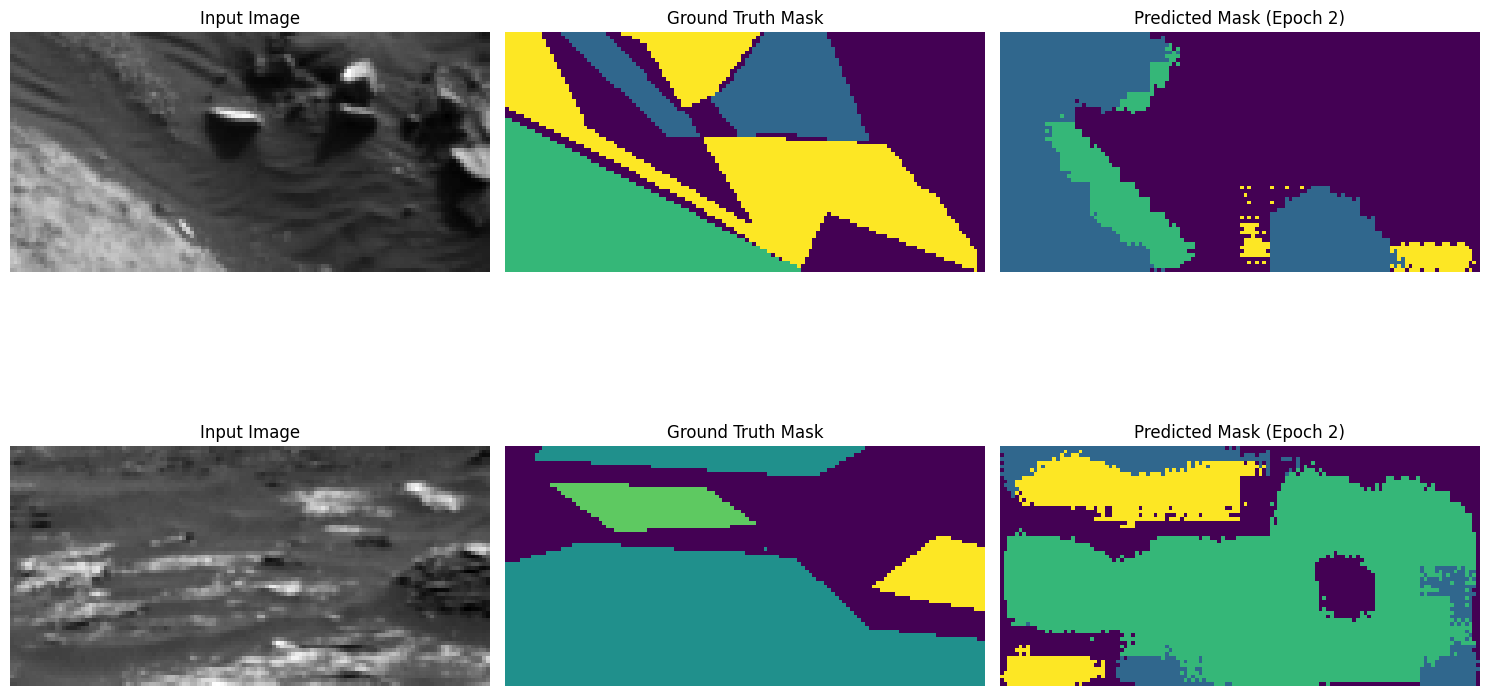

314/314 ━━━━━━━━━━━━━━━━━━━━ 55s 176ms/step - accuracy: 0.4807 - custom_mean_iou: 0.1894 - loss: 1.1324 - mean_io_u: 0.2178 - val_accuracy: 0.5670 - val_custom_mean_iou: 0.2422 - val_loss: 1.0420 - val_mean_io_u: 0.2821 - learning_rate: 1.0000e-04
Epoch 3/1000
313/314 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.5411 - custom_mean_iou: 0.2248 - loss: 1.0423 - mean_io_u: 0.2568Available log keys: dict_keys(['accuracy', 'custom_mean_iou', 'loss', 'mean_io_u', 'val_accuracy', 'val_custom_mean_iou', 'val_loss', 'val_mean_io_u'])
Epoch 3: val_custom_mean_iou improved to 0.2730, saving model.

Epoch 3: val_loss improved from 1.04203 to 0.99270, saving model to best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


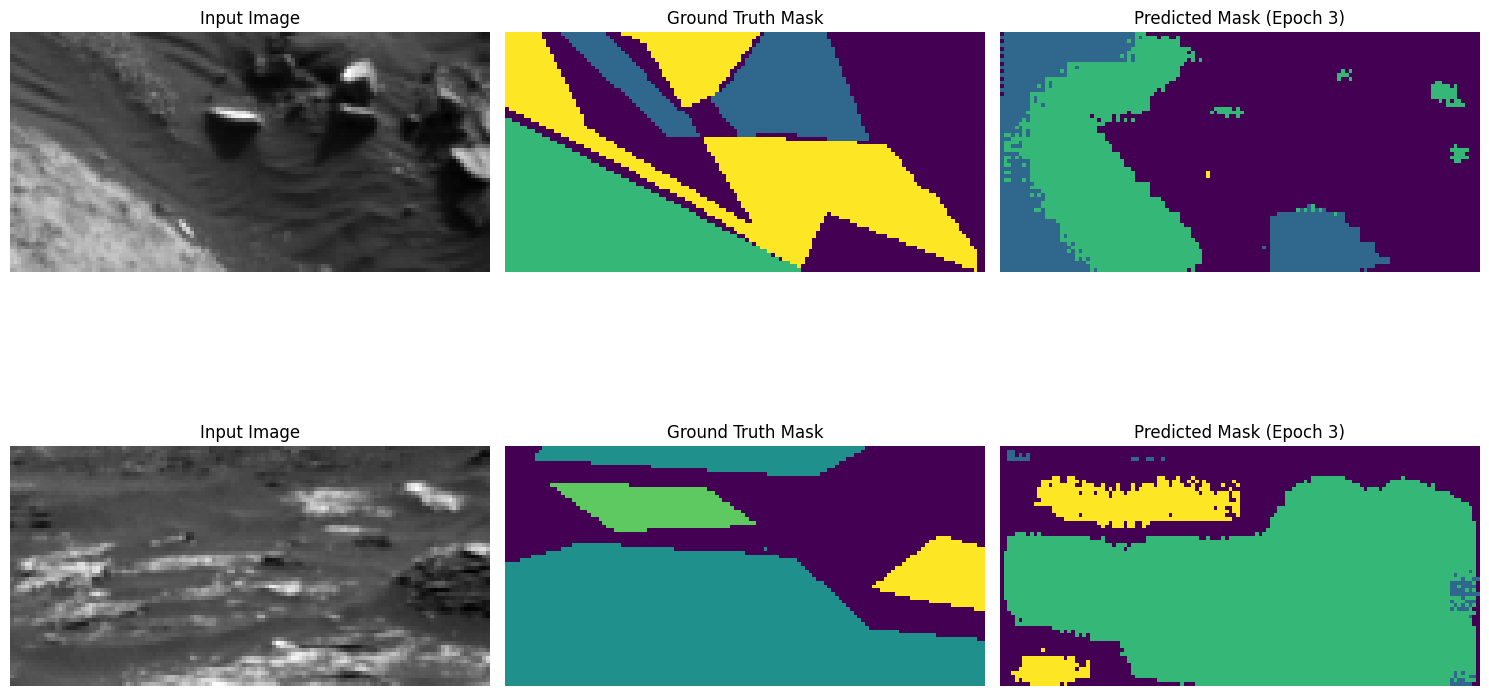

314/314 ━━━━━━━━━━━━━━━━━━━━ 55s 176ms/step - accuracy: 0.5412 - custom_mean_iou: 0.2248 - loss: 1.0422 - mean_io_u: 0.2568 - val_accuracy: 0.5950 - val_custom_mean_iou: 0.2730 - val_loss: 0.9927 - val_mean_io_u: 0.3184 - learning_rate: 1.0000e-04
Epoch 4/1000
313/314 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.5886 - custom_mean_iou: 0.2612 - loss: 0.9770 - mean_io_u: 0.2995Available log keys: dict_keys(['accuracy', 'custom_mean_iou', 'loss', 'mean_io_u', 'val_accuracy', 'val_custom_mean_iou', 'val_loss', 'val_mean_io_u'])
Epoch 4: val_custom_mean_iou improved to 0.2947, saving model.

Epoch 4: val_loss improved from 0.99270 to 0.94502, saving model to best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


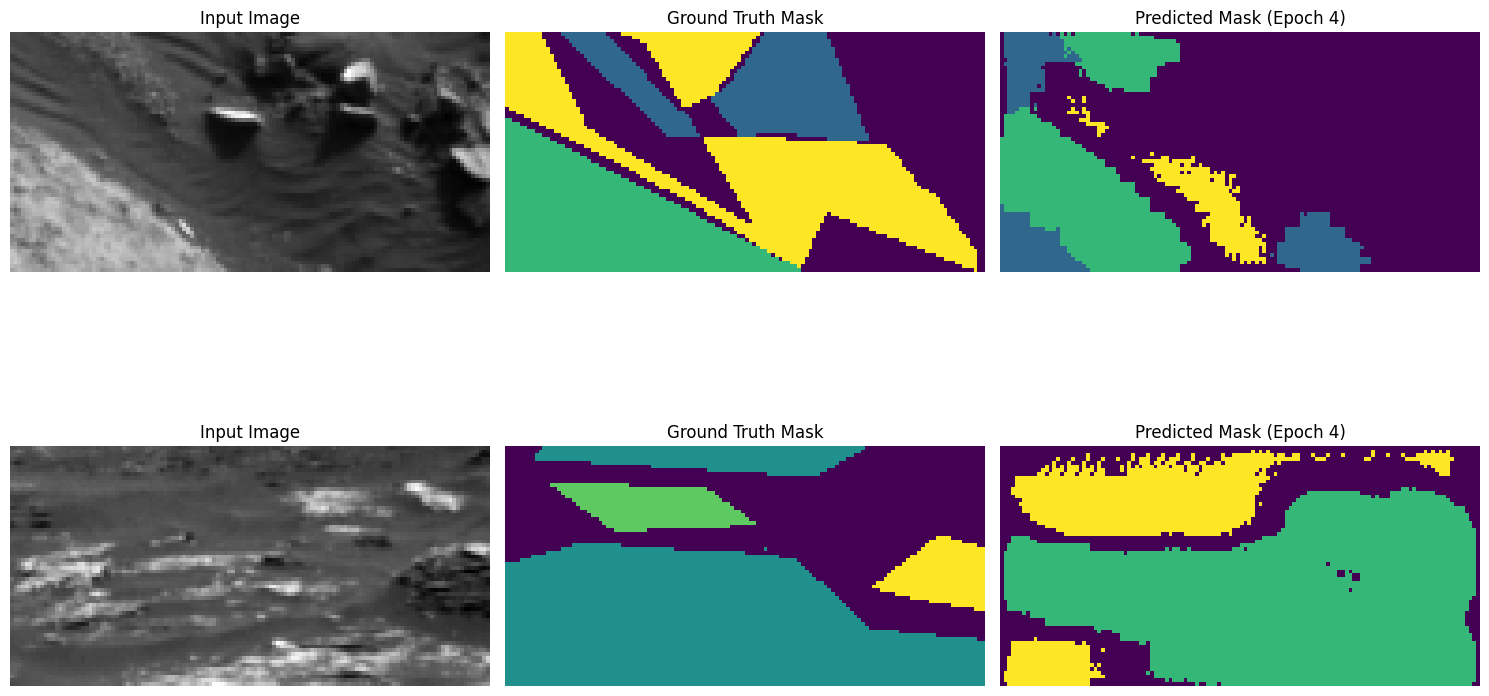

314/314 ━━━━━━━━━━━━━━━━━━━━ 55s 176ms/step - accuracy: 0.5886 - custom_mean_iou: 0.2612 - loss: 0.9769 - mean_io_u: 0.2995 - val_accuracy: 0.6315 - val_custom_mean_iou: 0.2947 - val_loss: 0.9450 - val_mean_io_u: 0.3454 - learning_rate: 1.0000e-04
Epoch 5/1000
313/314 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.6194 - custom_mean_iou: 0.2873 - loss: 0.9204 - mean_io_u: 0.3318Available log keys: dict_keys(['accuracy', 'custom_mean_iou', 'loss', 'mean_io_u', 'val_accuracy', 'val_custom_mean_iou', 'val_loss', 'val_mean_io_u'])
Epoch 5: val_custom_mean_iou improved to 0.3100, saving model.

Epoch 5: val_loss improved from 0.94502 to 0.91811, saving model to best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


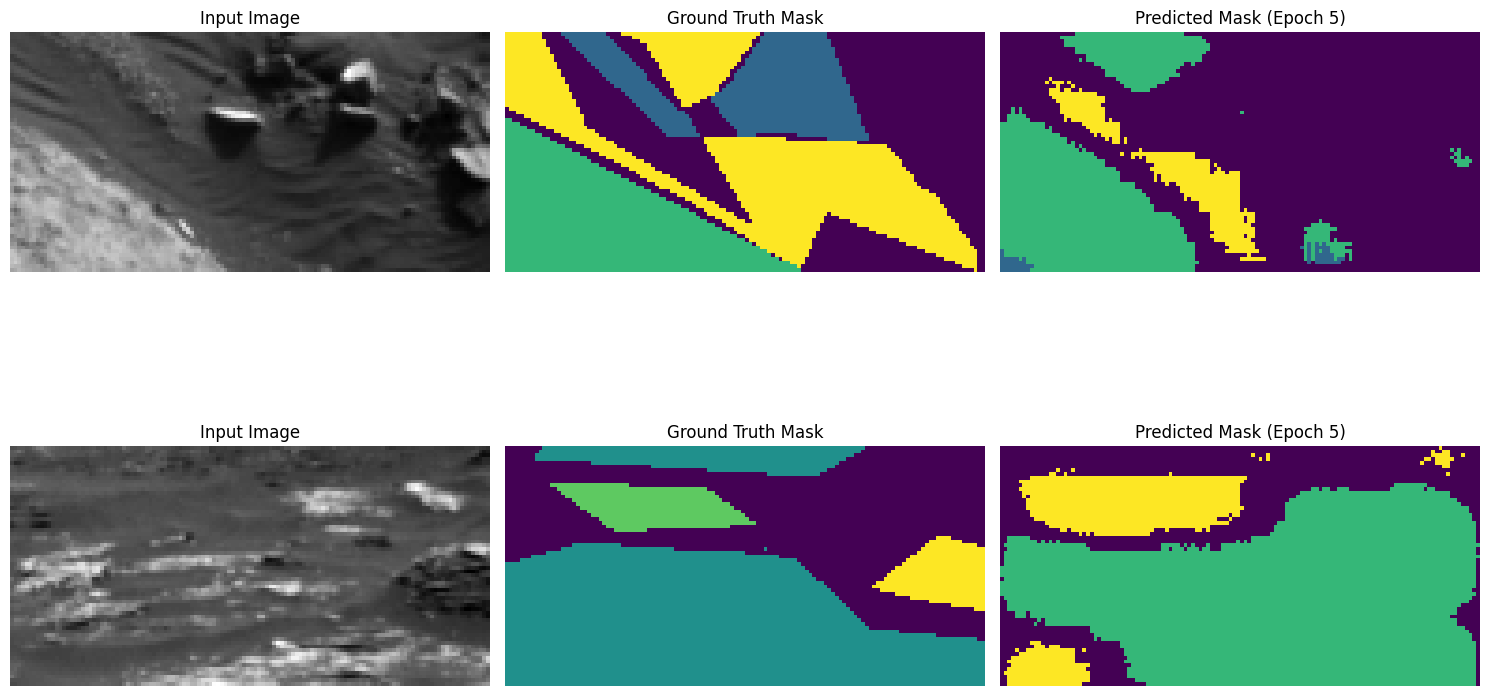

314/314 ━━━━━━━━━━━━━━━━━━━━ 55s 176ms/step - accuracy: 0.6195 - custom_mean_iou: 0.2873 - loss: 0.9203 - mean_io_u: 0.3318 - val_accuracy: 0.6478 - val_custom_mean_iou: 0.3100 - val_loss: 0.9181 - val_mean_io_u: 0.3647 - learning_rate: 1.0000e-04
Epoch 6/1000
313/314 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.6505 - custom_mean_iou: 0.3098 - loss: 0.8630 - mean_io_u: 0.3572Available log keys: dict_keys(['accuracy', 'custom_mean_iou', 'loss', 'mean_io_u', 'val_accuracy', 'val_custom_mean_iou', 'val_loss', 'val_mean_io_u'])
Epoch 6: val_custom_mean_iou improved to 0.3317, saving model.

Epoch 6: val_loss improved from 0.91811 to 0.86087, saving model to best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


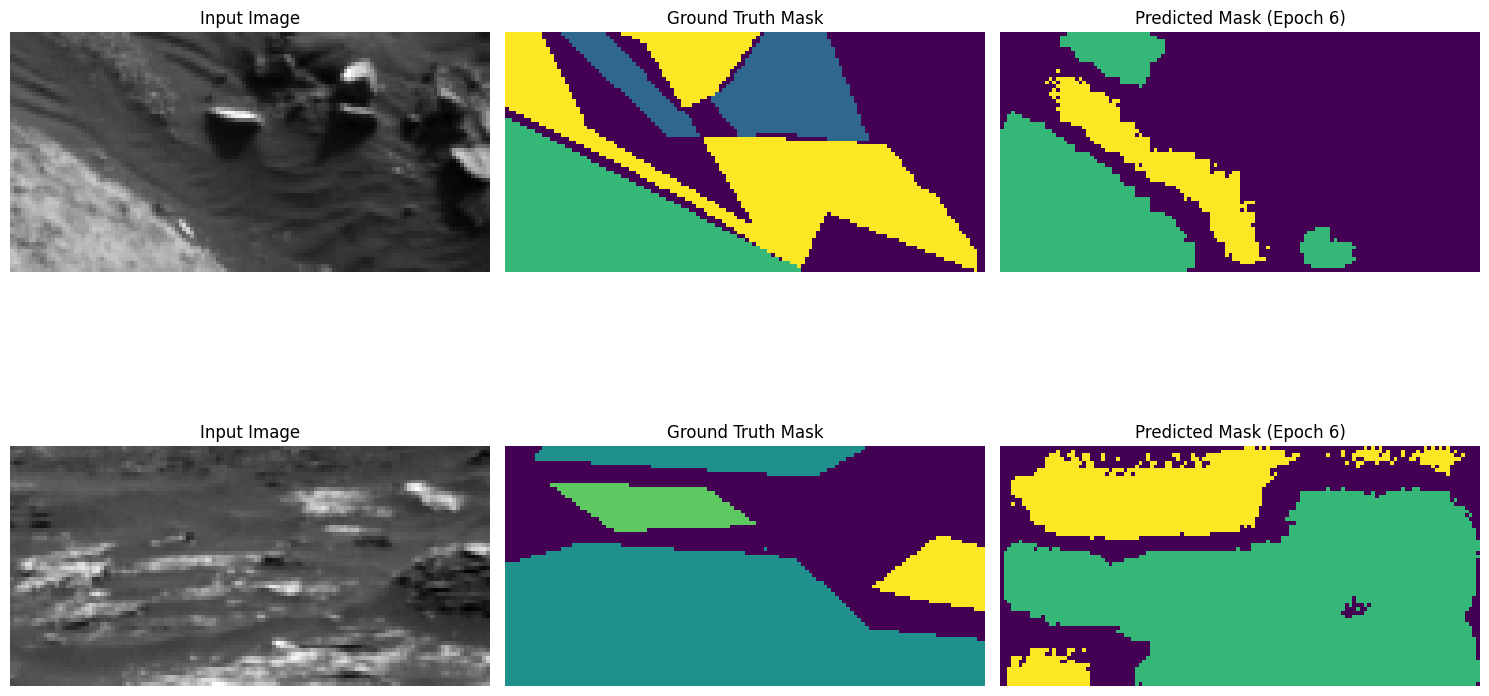

314/314 ━━━━━━━━━━━━━━━━━━━━ 55s 175ms/step - accuracy: 0.6505 - custom_mean_iou: 0.3097 - loss: 0.8630 - mean_io_u: 0.3572 - val_accuracy: 0.6792 - val_custom_mean_iou: 0.3317 - val_loss: 0.8609 - val_mean_io_u: 0.3873 - learning_rate: 1.0000e-04
Epoch 7/1000
313/314 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.6652 - custom_mean_iou: 0.3199 - loss: 0.8291 - mean_io_u: 0.3687Available log keys: dict_keys(['accuracy', 'custom_mean_iou', 'loss', 'mean_io_u', 'val_accuracy', 'val_custom_mean_iou', 'val_loss', 'val_mean_io_u'])
Epoch 7: val_custom_mean_iou improved to 0.3456, saving model.

Epoch 7: val_loss improved from 0.86087 to 0.81609, saving model to best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


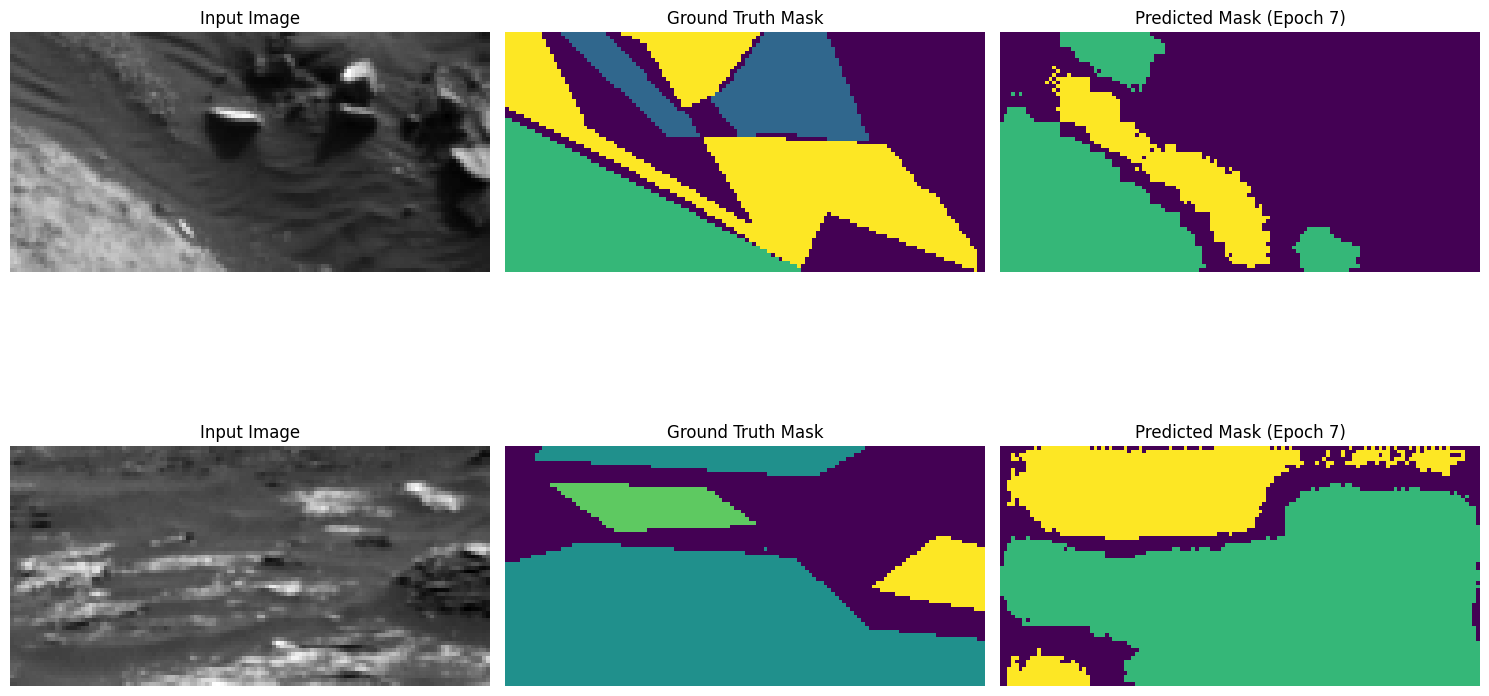

314/314 ━━━━━━━━━━━━━━━━━━━━ 55s 175ms/step - accuracy: 0.6653 - custom_mean_iou: 0.3199 - loss: 0.8291 - mean_io_u: 0.3687 - val_accuracy: 0.6925 - val_custom_mean_iou: 0.3456 - val_loss: 0.8161 - val_mean_io_u: 0.4063 - learning_rate: 1.0000e-04
Epoch 8/1000
313/314 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.6831 - custom_mean_iou: 0.3341 - loss: 0.7955 - mean_io_u: 0.3852Available log keys: dict_keys(['accuracy', 'custom_mean_iou', 'loss', 'mean_io_u', 'val_accuracy', 'val_custom_mean_iou', 'val_loss', 'val_mean_io_u'])

Epoch 8: val_loss did not improve from 0.81609
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


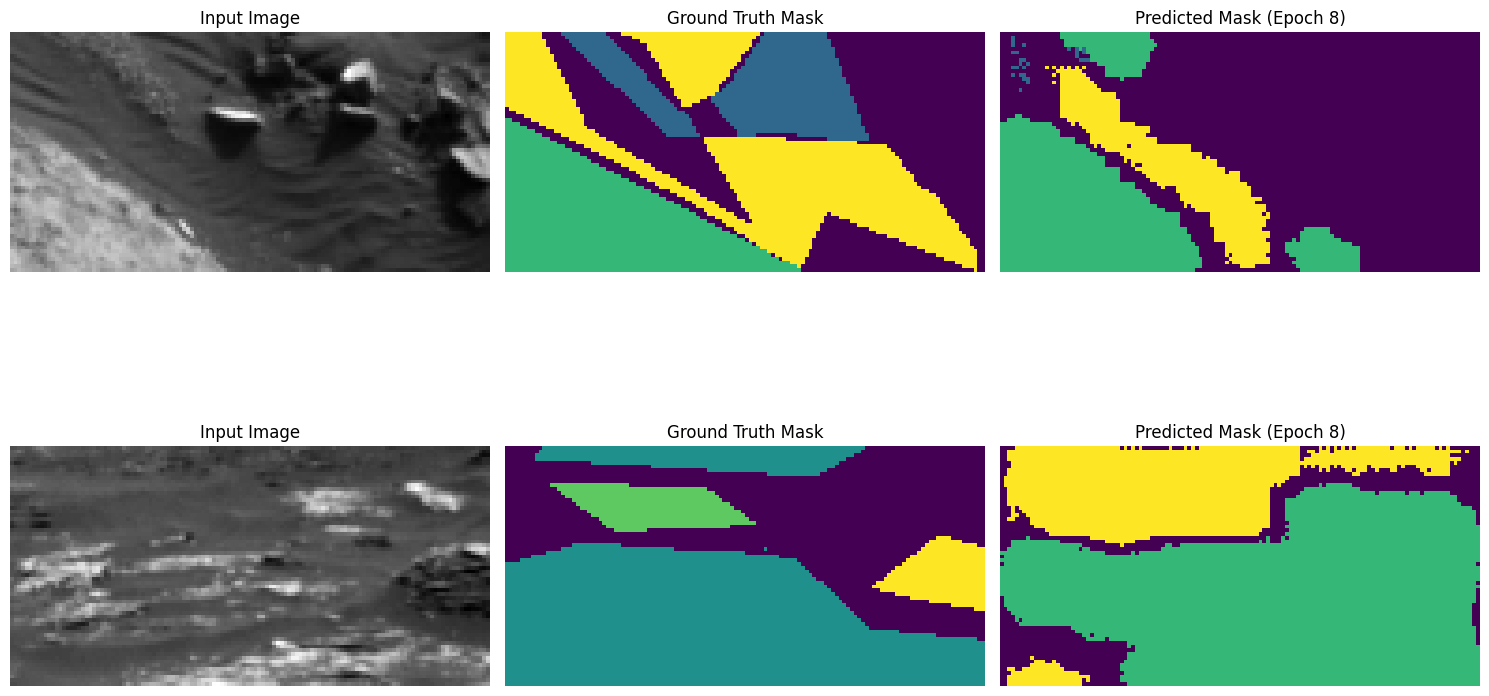

314/314 ━━━━━━━━━━━━━━━━━━━━ 54s 173ms/step - accuracy: 0.6832 - custom_mean_iou: 0.3340 - loss: 0.7955 - mean_io_u: 0.3851 - val_accuracy: 0.6781 - val_custom_mean_iou: 0.3297 - val_loss: 0.8579 - val_mean_io_u: 0.3860 - learning_rate: 1.0000e-04
Epoch 9/1000
313/314 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.6928 - custom_mean_iou: 0.3412 - loss: 0.7709 - mean_io_u: 0.3929Available log keys: dict_keys(['accuracy', 'custom_mean_iou', 'loss', 'mean_io_u', 'val_accuracy', 'val_custom_mean_iou', 'val_loss', 'val_mean_io_u'])

Epoch 9: val_loss did not improve from 0.81609
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


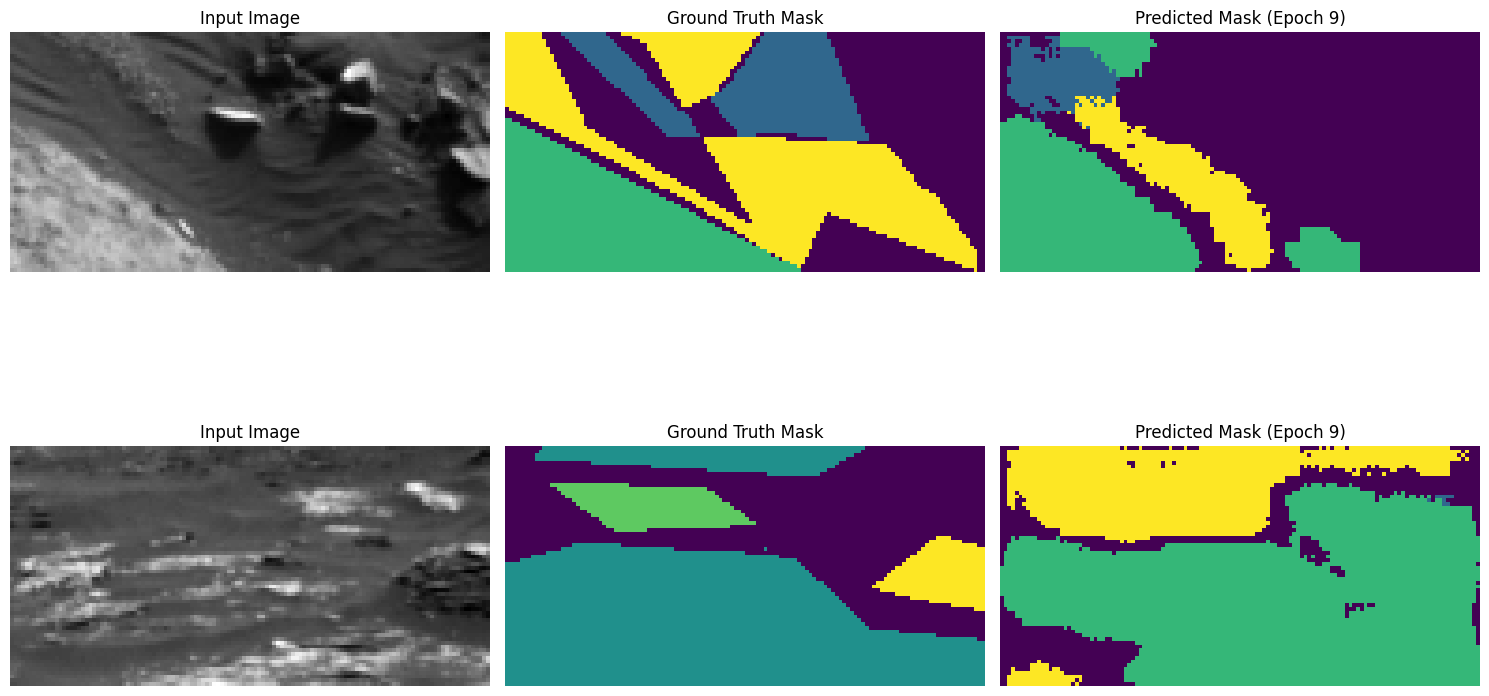

314/314 ━━━━━━━━━━━━━━━━━━━━ 54s 173ms/step - accuracy: 0.6928 - custom_mean_iou: 0.3412 - loss: 0.7709 - mean_io_u: 0.3928 - val_accuracy: 0.6685 - val_custom_mean_iou: 0.3184 - val_loss: 0.8920 - val_mean_io_u: 0.3692 - learning_rate: 1.0000e-04
Epoch 10/1000
313/314 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.7027 - custom_mean_iou: 0.3487 - loss: 0.7492 - mean_io_u: 0.4009Available log keys: dict_keys(['accuracy', 'custom_mean_iou', 'loss', 'mean_io_u', 'val_accuracy', 'val_custom_mean_iou', 'val_loss', 'val_mean_io_u'])

Epoch 10: val_loss did not improve from 0.81609
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


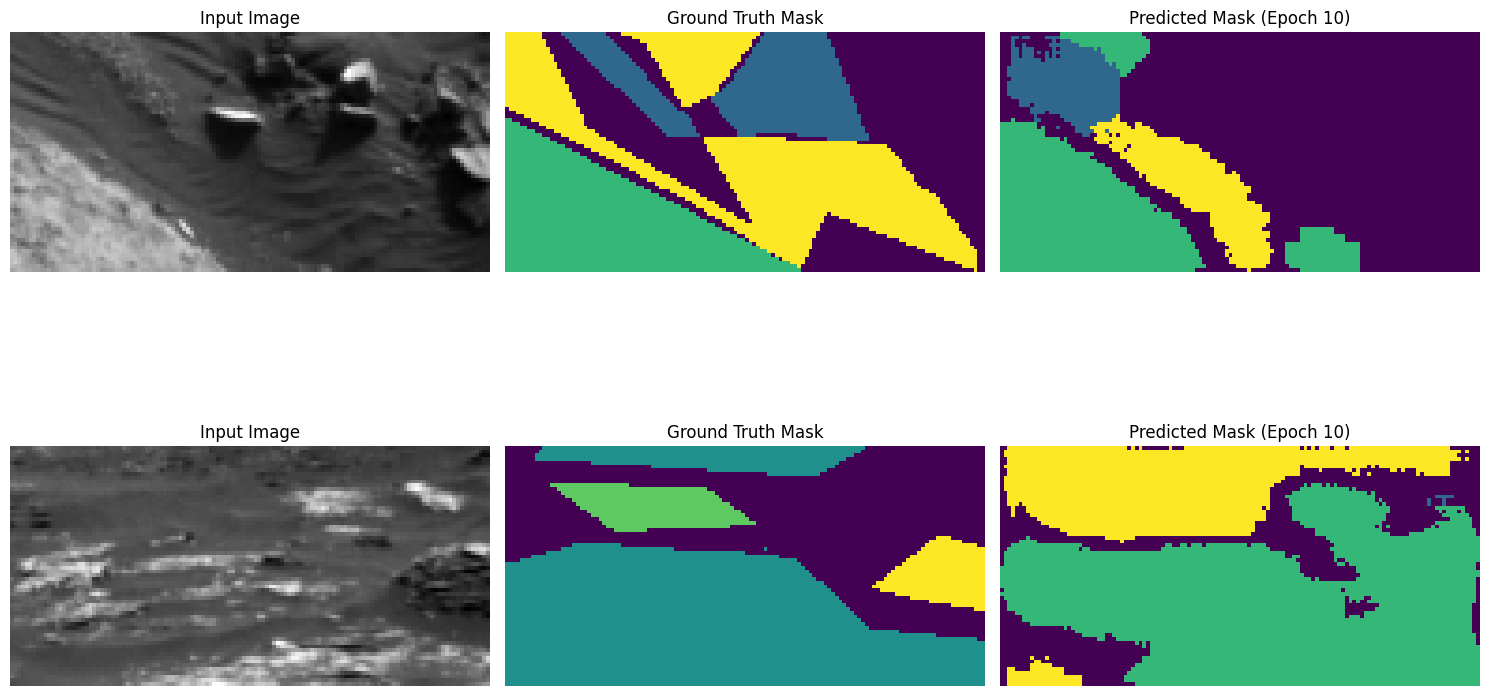

314/314 ━━━━━━━━━━━━━━━━━━━━ 54s 173ms/step - accuracy: 0.7028 - custom_mean_iou: 0.3487 - loss: 0.7491 - mean_io_u: 0.4008 - val_accuracy: 0.6827 - val_custom_mean_iou: 0.3309 - val_loss: 0.8567 - val_mean_io_u: 0.3836 - learning_rate: 1.0000e-04
Epoch 11/1000
313/314 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.7077 - custom_mean_iou: 0.3523 - loss: 0.7362 - mean_io_u: 0.4046Available log keys: dict_keys(['accuracy', 'custom_mean_iou', 'loss', 'mean_io_u', 'val_accuracy', 'val_custom_mean_iou', 'val_loss', 'val_mean_io_u'])
Epoch 11: val_custom_mean_iou improved to 0.3610, saving model.

Epoch 11: val_loss improved from 0.81609 to 0.77114, saving model to best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


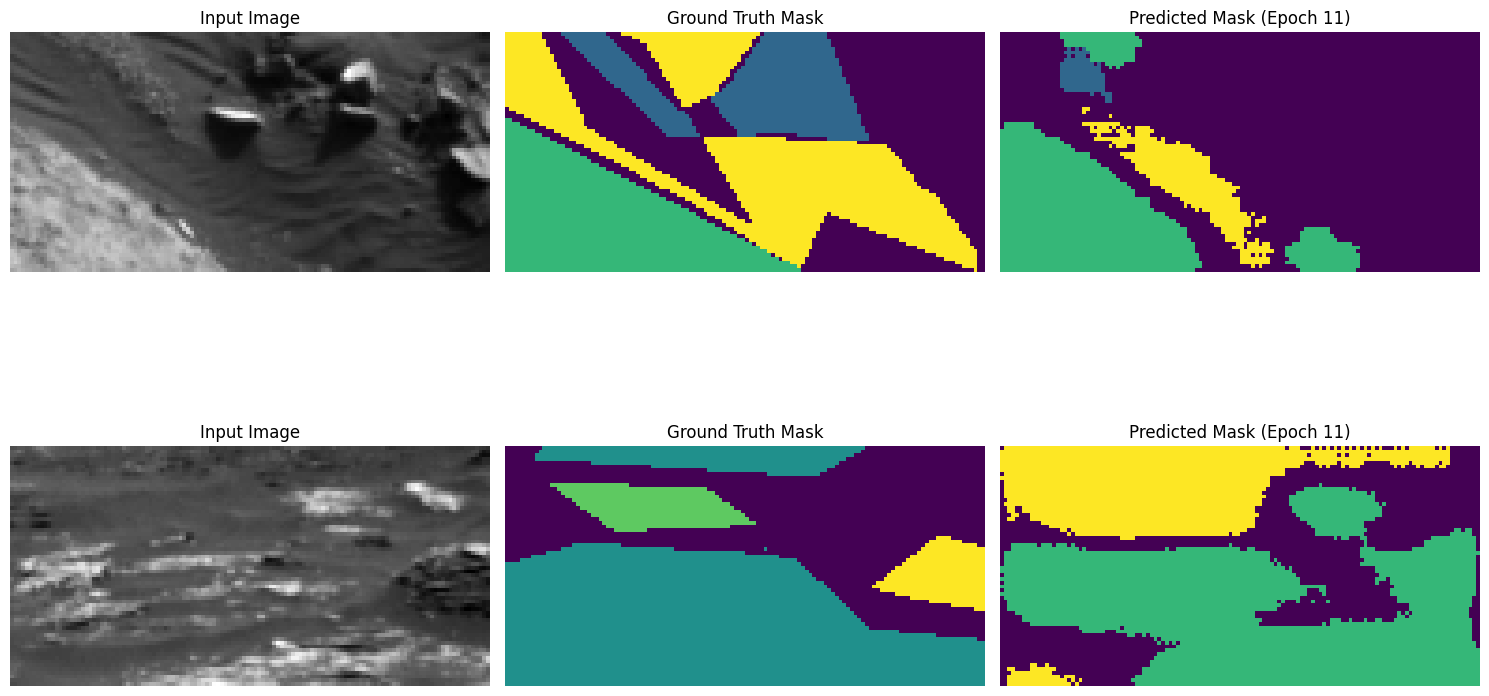

314/314 ━━━━━━━━━━━━━━━━━━━━ 56s 177ms/step - accuracy: 0.7077 - custom_mean_iou: 0.3522 - loss: 0.7362 - mean_io_u: 0.4046 - val_accuracy: 0.7162 - val_custom_mean_iou: 0.3610 - val_loss: 0.7711 - val_mean_io_u: 0.4170 - learning_rate: 1.0000e-04
Epoch 12/1000
313/314 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.7097 - custom_mean_iou: 0.3542 - loss: 0.7297 - mean_io_u: 0.4067Available log keys: dict_keys(['accuracy', 'custom_mean_iou', 'loss', 'mean_io_u', 'val_accuracy', 'val_custom_mean_iou', 'val_loss', 'val_mean_io_u'])
Epoch 12: val_custom_mean_iou improved to 0.3761, saving model.

Epoch 12: val_loss improved from 0.77114 to 0.72795, saving model to best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


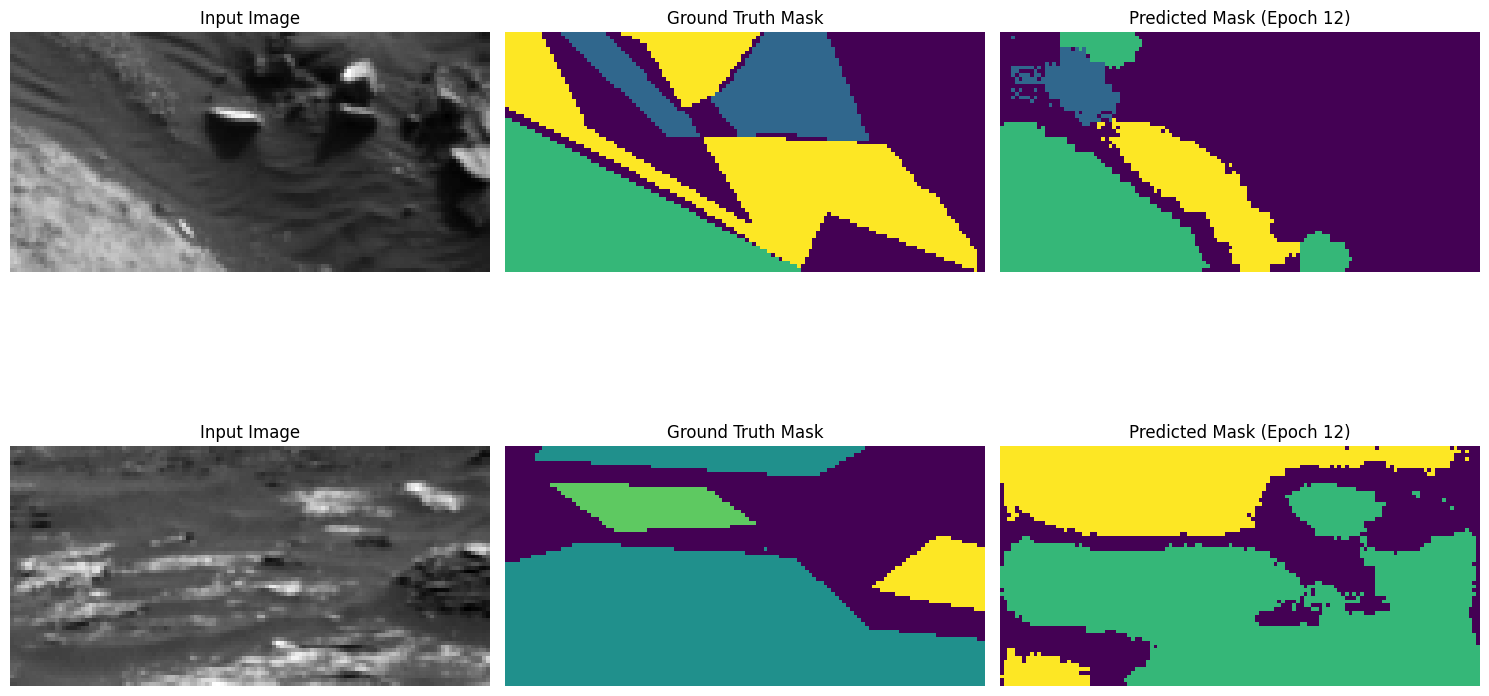

314/314 ━━━━━━━━━━━━━━━━━━━━ 55s 176ms/step - accuracy: 0.7098 - custom_mean_iou: 0.3542 - loss: 0.7297 - mean_io_u: 0.4067 - val_accuracy: 0.7312 - val_custom_mean_iou: 0.3761 - val_loss: 0.7280 - val_mean_io_u: 0.4358 - learning_rate: 1.0000e-04
Epoch 13/1000
313/314 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.7201 - custom_mean_iou: 0.3632 - loss: 0.7072 - mean_io_u: 0.4169Available log keys: dict_keys(['accuracy', 'custom_mean_iou', 'loss', 'mean_io_u', 'val_accuracy', 'val_custom_mean_iou', 'val_loss', 'val_mean_io_u'])
Epoch 13: val_custom_mean_iou improved to 0.3805, saving model.

Epoch 13: val_loss improved from 0.72795 to 0.71348, saving model to best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


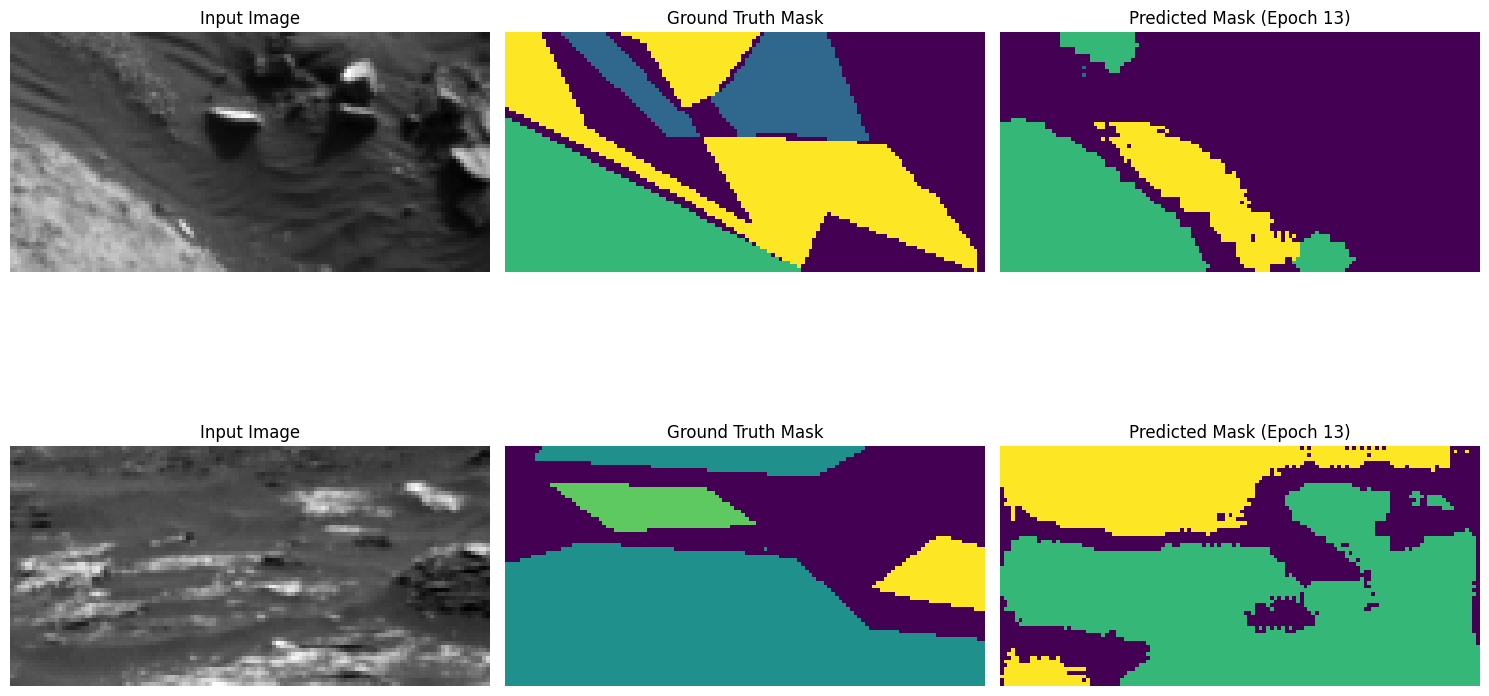

314/314 ━━━━━━━━━━━━━━━━━━━━ 55s 176ms/step - accuracy: 0.7201 - custom_mean_iou: 0.3631 - loss: 0.7071 - mean_io_u: 0.4168 - val_accuracy: 0.7366 - val_custom_mean_iou: 0.3805 - val_loss: 0.7135 - val_mean_io_u: 0.4391 - learning_rate: 1.0000e-04
Epoch 14/1000
313/314 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.7238 - custom_mean_iou: 0.3664 - loss: 0.6948 - mean_io_u: 0.4203Available log keys: dict_keys(['accuracy', 'custom_mean_iou', 'loss', 'mean_io_u', 'val_accuracy', 'val_custom_mean_iou', 'val_loss', 'val_mean_io_u'])
Epoch 14: val_custom_mean_iou improved to 0.3862, saving model.

Epoch 14: val_loss improved from 0.71348 to 0.70631, saving model to best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


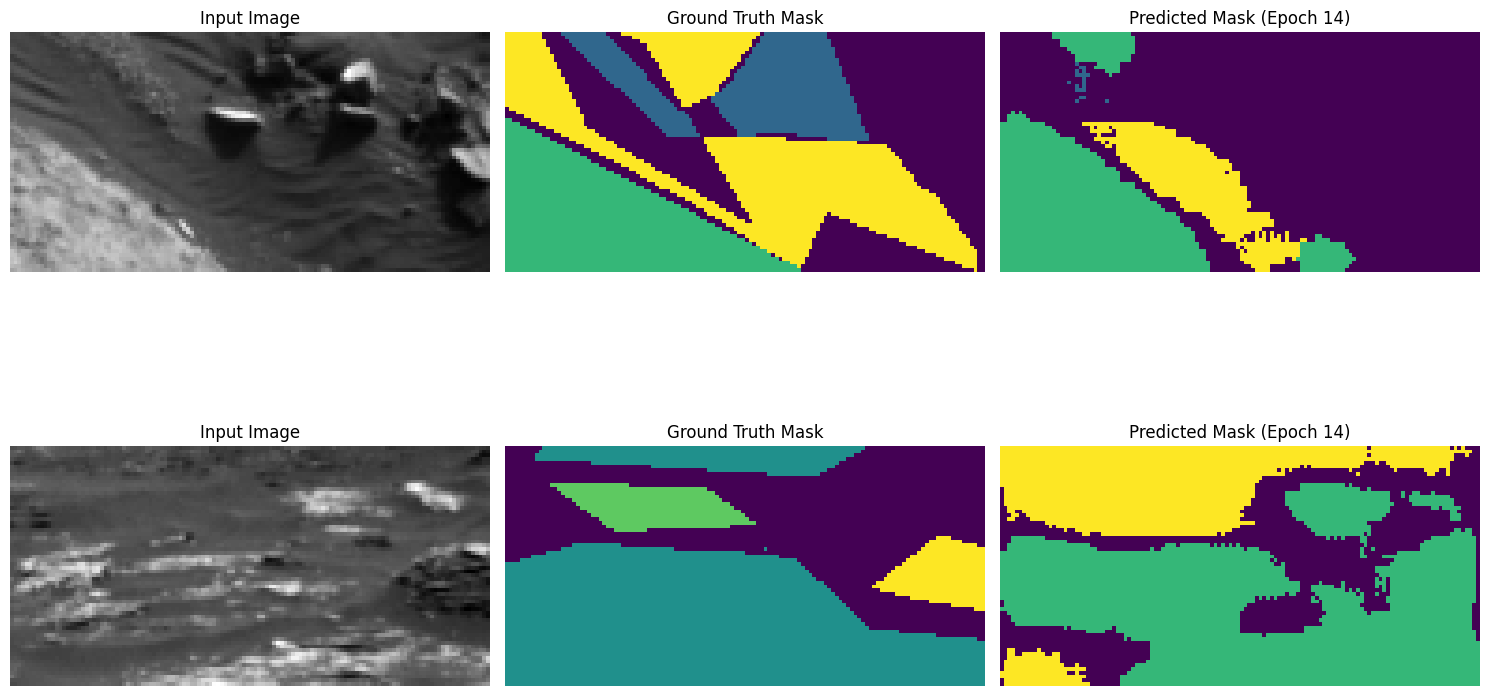

314/314 ━━━━━━━━━━━━━━━━━━━━ 55s 176ms/step - accuracy: 0.7239 - custom_mean_iou: 0.3663 - loss: 0.6947 - mean_io_u: 0.4203 - val_accuracy: 0.7418 - val_custom_mean_iou: 0.3862 - val_loss: 0.7063 - val_mean_io_u: 0.4471 - learning_rate: 1.0000e-04
Epoch 15/1000
313/314 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.7335 - custom_mean_iou: 0.3739 - loss: 0.6708 - mean_io_u: 0.4284Available log keys: dict_keys(['accuracy', 'custom_mean_iou', 'loss', 'mean_io_u', 'val_accuracy', 'val_custom_mean_iou', 'val_loss', 'val_mean_io_u'])

Epoch 15: val_loss improved from 0.70631 to 0.70468, saving model to best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


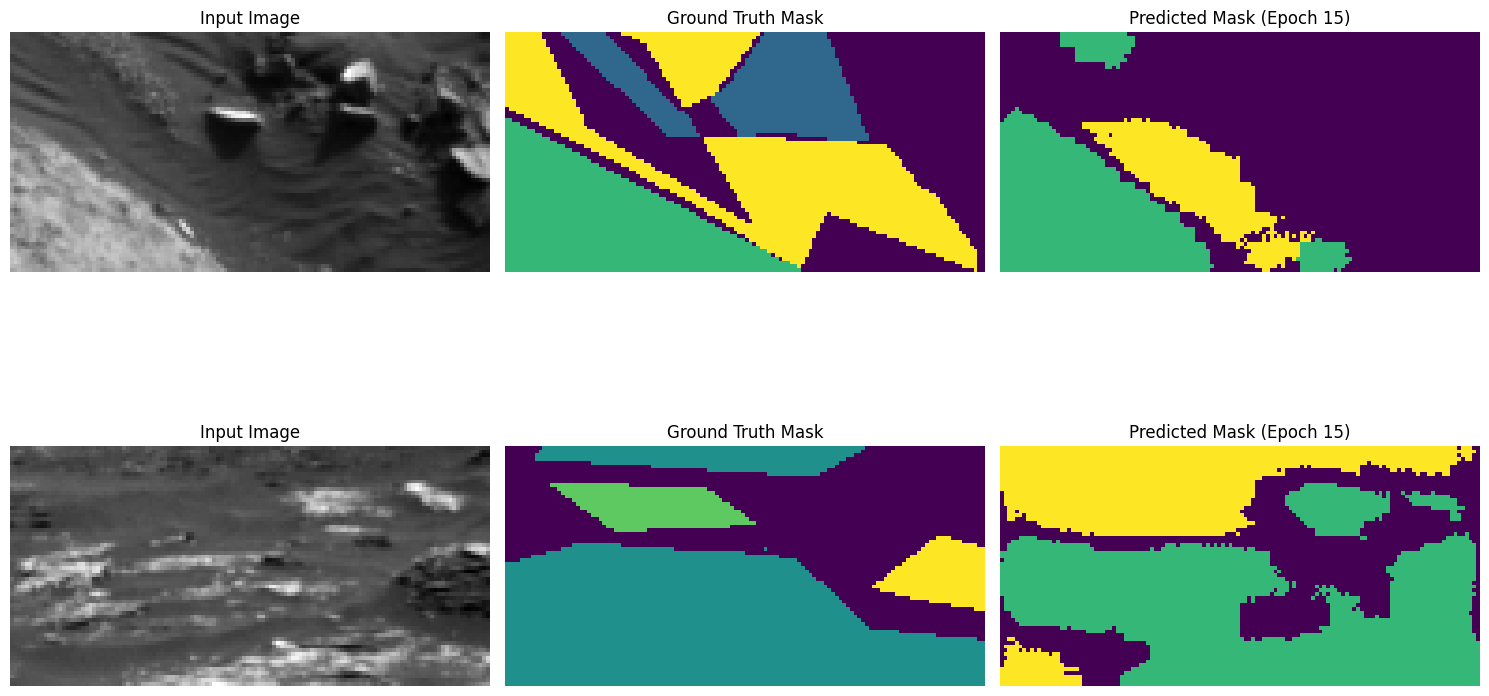

314/314 ━━━━━━━━━━━━━━━━━━━━ 55s 175ms/step - accuracy: 0.7335 - custom_mean_iou: 0.3739 - loss: 0.6707 - mean_io_u: 0.4284 - val_accuracy: 0.7412 - val_custom_mean_iou: 0.3845 - val_loss: 0.7047 - val_mean_io_u: 0.4442 - learning_rate: 1.0000e-04
Epoch 16/1000
313/314 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.7341 - custom_mean_iou: 0.3740 - loss: 0.6722 - mean_io_u: 0.4280Available log keys: dict_keys(['accuracy', 'custom_mean_iou', 'loss', 'mean_io_u', 'val_accuracy', 'val_custom_mean_iou', 'val_loss', 'val_mean_io_u'])
Epoch 16: val_custom_mean_iou improved to 0.3915, saving model.

Epoch 16: val_loss improved from 0.70468 to 0.68254, saving model to best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


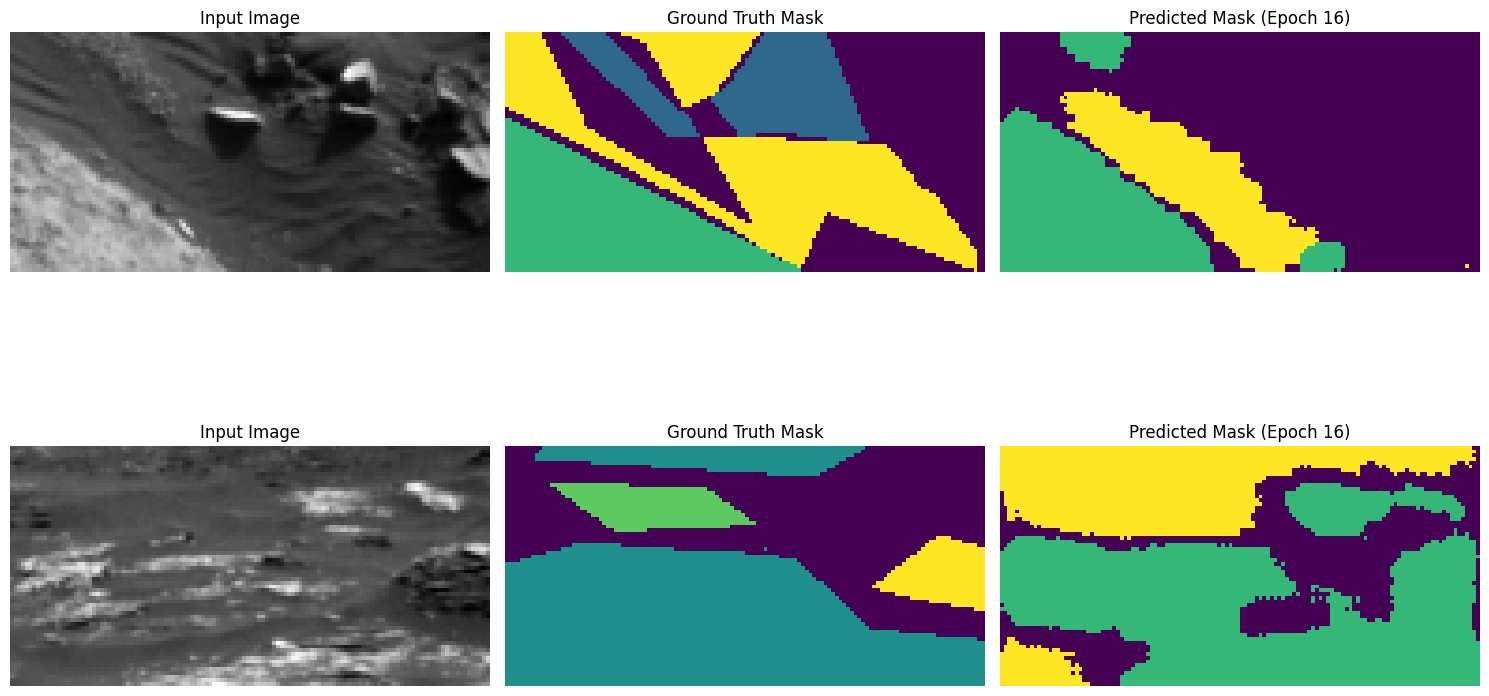

314/314 ━━━━━━━━━━━━━━━━━━━━ 55s 175ms/step - accuracy: 0.7341 - custom_mean_iou: 0.3740 - loss: 0.6721 - mean_io_u: 0.4280 - val_accuracy: 0.7479 - val_custom_mean_iou: 0.3915 - val_loss: 0.6825 - val_mean_io_u: 0.4539 - learning_rate: 1.0000e-04
Epoch 17/1000
313/314 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.7441 - custom_mean_iou: 0.3825 - loss: 0.6488 - mean_io_u: 0.4377Available log keys: dict_keys(['accuracy', 'custom_mean_iou', 'loss', 'mean_io_u', 'val_accuracy', 'val_custom_mean_iou', 'val_loss', 'val_mean_io_u'])
Epoch 17: val_custom_mean_iou improved to 0.3918, saving model.

Epoch 17: val_loss improved from 0.68254 to 0.68128, saving model to best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


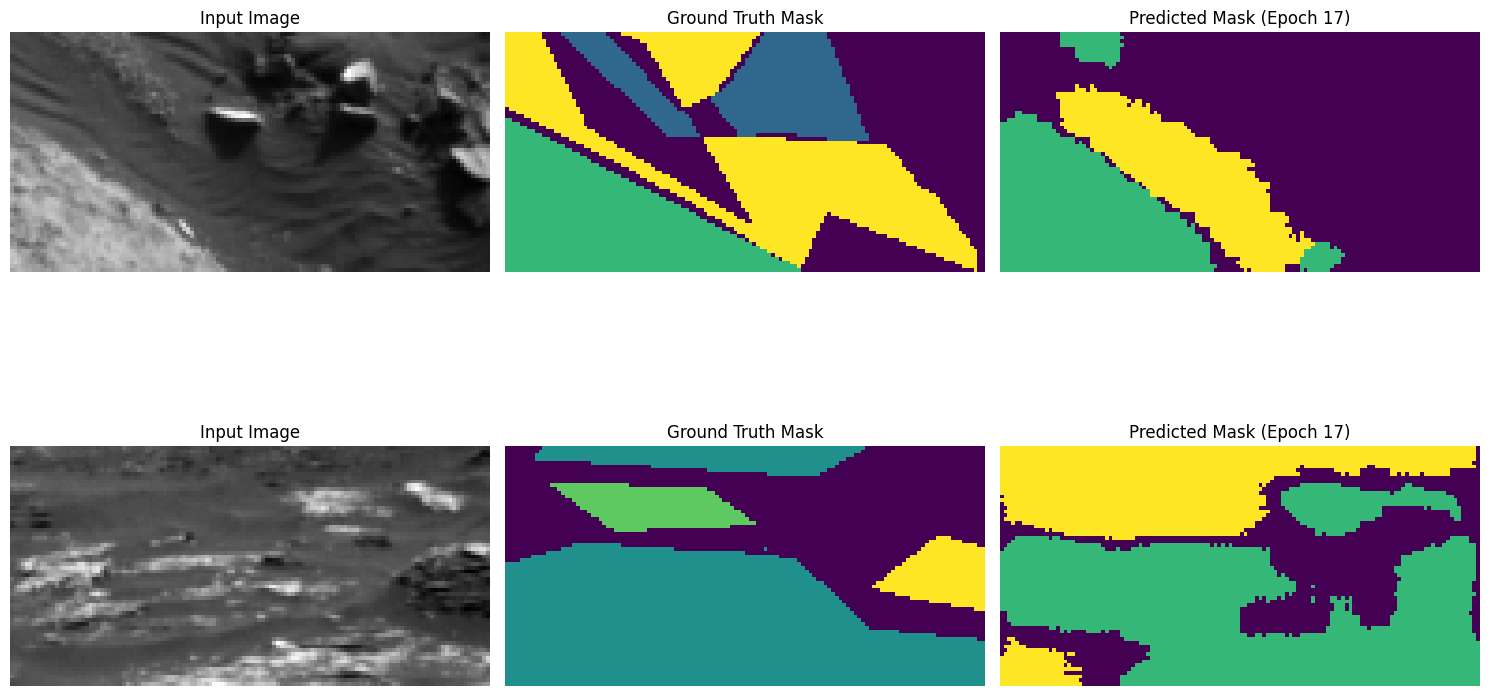

314/314 ━━━━━━━━━━━━━━━━━━━━ 55s 176ms/step - accuracy: 0.7441 - custom_mean_iou: 0.3825 - loss: 0.6487 - mean_io_u: 0.4376 - val_accuracy: 0.7486 - val_custom_mean_iou: 0.3918 - val_loss: 0.6813 - val_mean_io_u: 0.4544 - learning_rate: 1.0000e-04
Epoch 18/1000
313/314 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.7530 - custom_mean_iou: 0.3907 - loss: 0.6294 - mean_io_u: 0.4466Available log keys: dict_keys(['accuracy', 'custom_mean_iou', 'loss', 'mean_io_u', 'val_accuracy', 'val_custom_mean_iou', 'val_loss', 'val_mean_io_u'])
Epoch 18: val_custom_mean_iou improved to 0.3930, saving model.

Epoch 18: val_loss improved from 0.68128 to 0.67343, saving model to best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


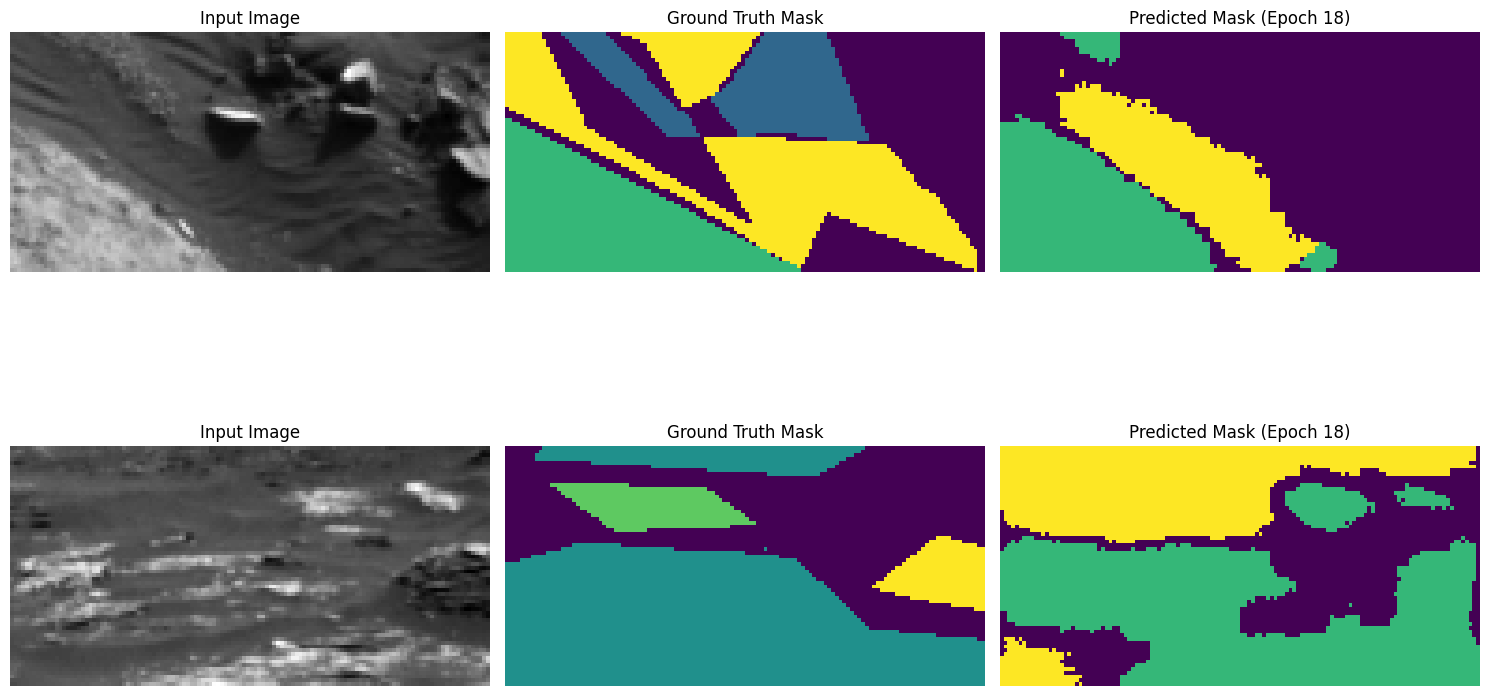

314/314 ━━━━━━━━━━━━━━━━━━━━ 55s 176ms/step - accuracy: 0.7531 - custom_mean_iou: 0.3906 - loss: 0.6293 - mean_io_u: 0.4466 - val_accuracy: 0.7501 - val_custom_mean_iou: 0.3930 - val_loss: 0.6734 - val_mean_io_u: 0.4559 - learning_rate: 1.0000e-04
Epoch 19/1000
313/314 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.7593 - custom_mean_iou: 0.3964 - loss: 0.6128 - mean_io_u: 0.4526Available log keys: dict_keys(['accuracy', 'custom_mean_iou', 'loss', 'mean_io_u', 'val_accuracy', 'val_custom_mean_iou', 'val_loss', 'val_mean_io_u'])

Epoch 19: val_loss did not improve from 0.67343
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


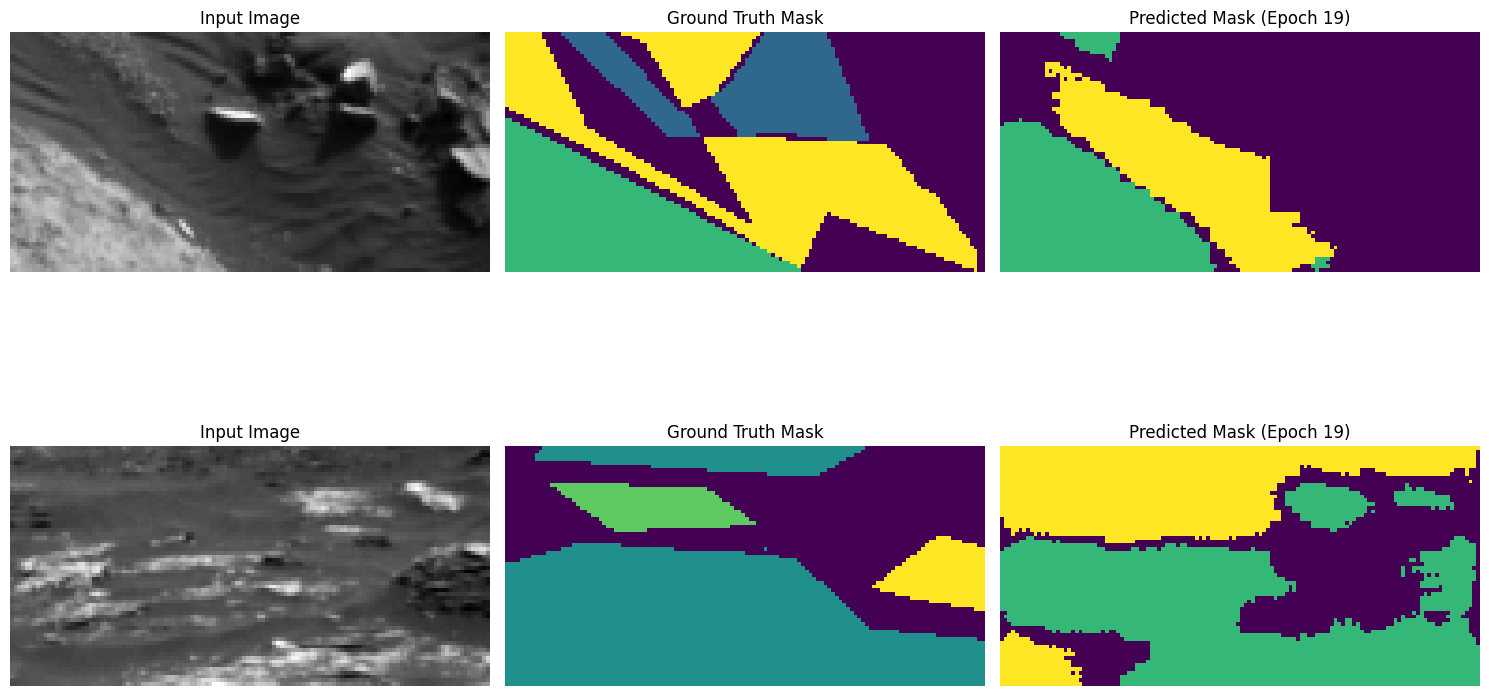

314/314 ━━━━━━━━━━━━━━━━━━━━ 54s 173ms/step - accuracy: 0.7593 - custom_mean_iou: 0.3963 - loss: 0.6127 - mean_io_u: 0.4526 - val_accuracy: 0.7518 - val_custom_mean_iou: 0.3928 - val_loss: 0.6742 - val_mean_io_u: 0.4535 - learning_rate: 1.0000e-04
Epoch 20/1000
313/314 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.7639 - custom_mean_iou: 0.3992 - loss: 0.6036 - mean_io_u: 0.4547Available log keys: dict_keys(['accuracy', 'custom_mean_iou', 'loss', 'mean_io_u', 'val_accuracy', 'val_custom_mean_iou', 'val_loss', 'val_mean_io_u'])
Epoch 20: val_custom_mean_iou improved to 0.3984, saving model.

Epoch 20: val_loss improved from 0.67343 to 0.65782, saving model to best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


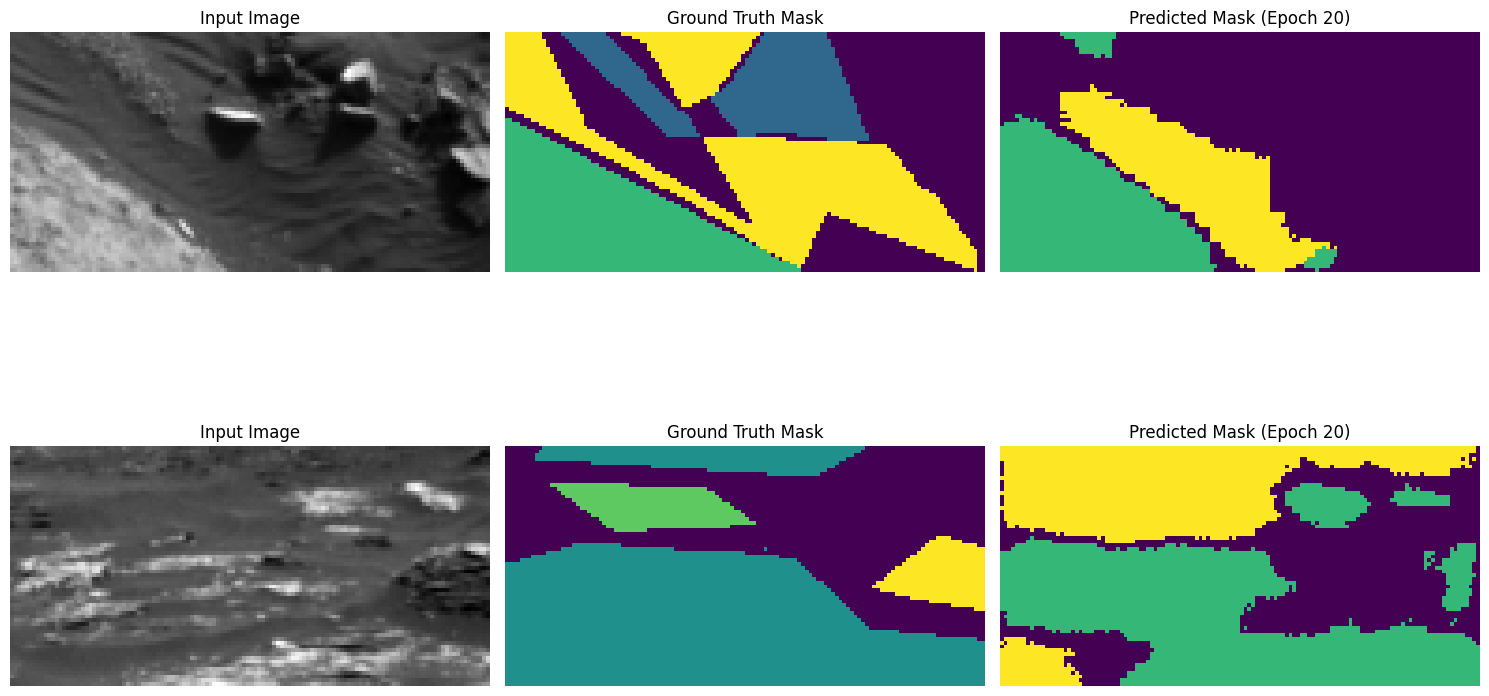

314/314 ━━━━━━━━━━━━━━━━━━━━ 55s 175ms/step - accuracy: 0.7640 - custom_mean_iou: 0.3991 - loss: 0.6035 - mean_io_u: 0.4546 - val_accuracy: 0.7575 - val_custom_mean_iou: 0.3984 - val_loss: 0.6578 - val_mean_io_u: 0.4581 - learning_rate: 1.0000e-04
Epoch 21/1000
313/314 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.7698 - custom_mean_iou: 0.4045 - loss: 0.5873 - mean_io_u: 0.4598Available log keys: dict_keys(['accuracy', 'custom_mean_iou', 'loss', 'mean_io_u', 'val_accuracy', 'val_custom_mean_iou', 'val_loss', 'val_mean_io_u'])
Epoch 21: val_custom_mean_iou improved to 0.3984, saving model.

Epoch 21: val_loss improved from 0.65782 to 0.65350, saving model to best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


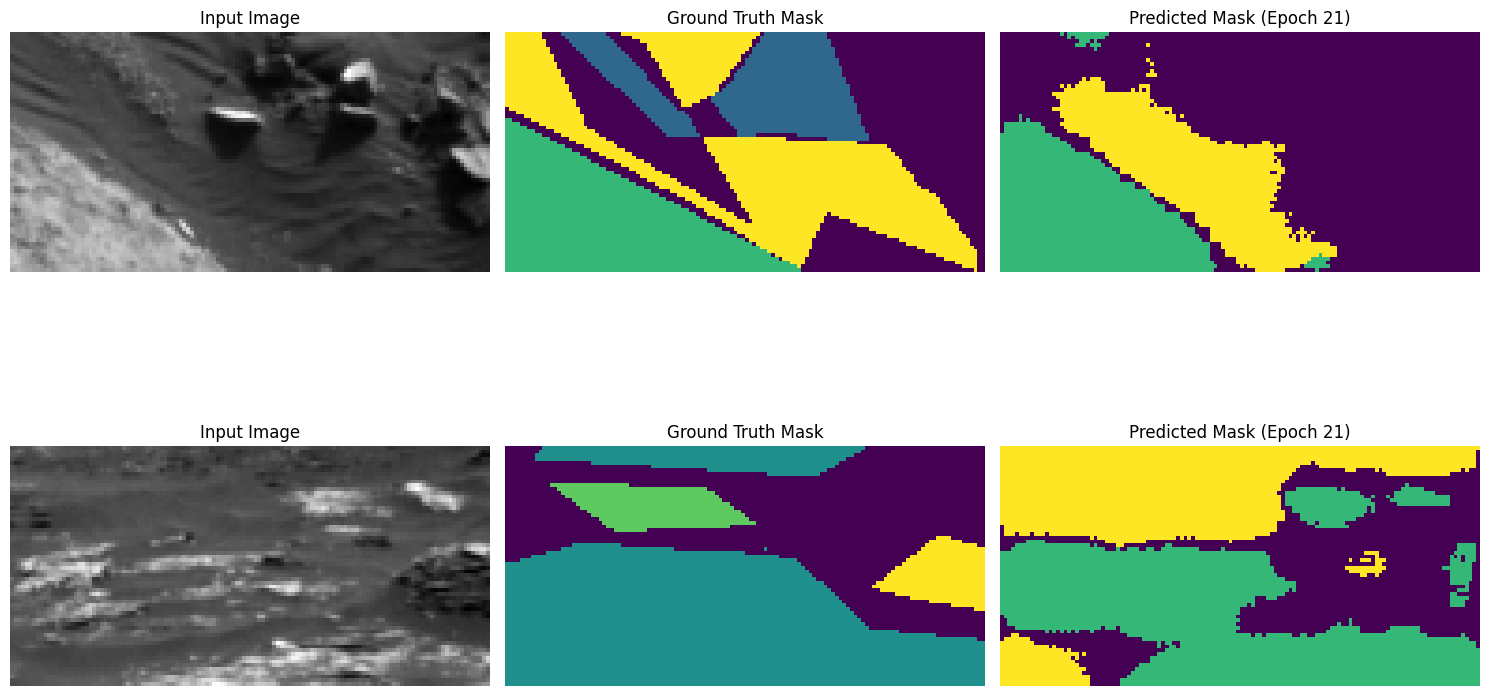

314/314 ━━━━━━━━━━━━━━━━━━━━ 55s 176ms/step - accuracy: 0.7699 - custom_mean_iou: 0.4044 - loss: 0.5873 - mean_io_u: 0.4597 - val_accuracy: 0.7573 - val_custom_mean_iou: 0.3984 - val_loss: 0.6535 - val_mean_io_u: 0.4607 - learning_rate: 1.0000e-04
Epoch 22/1000
313/314 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.7729 - custom_mean_iou: 0.4073 - loss: 0.5795 - mean_io_u: 0.4628Available log keys: dict_keys(['accuracy', 'custom_mean_iou', 'loss', 'mean_io_u', 'val_accuracy', 'val_custom_mean_iou', 'val_loss', 'val_mean_io_u'])

Epoch 22: val_loss did not improve from 0.65350
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


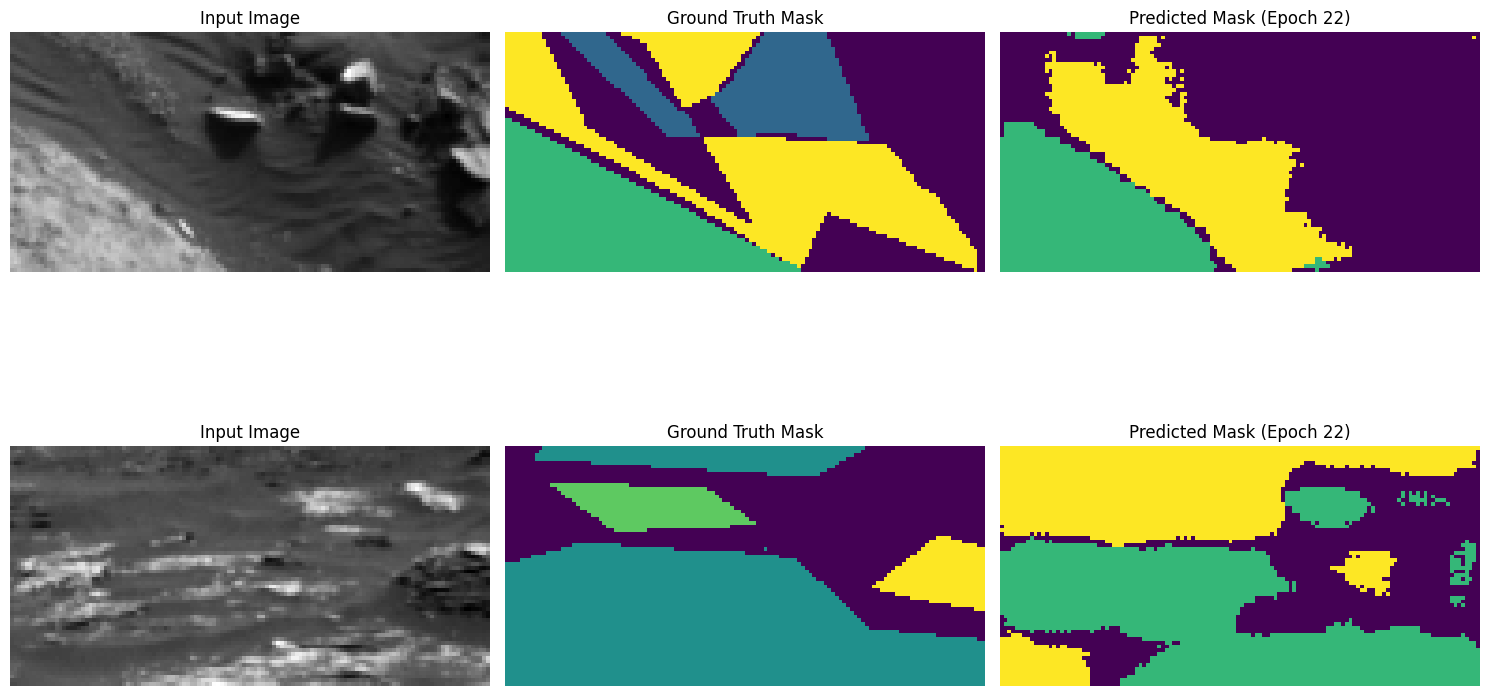

314/314 ━━━━━━━━━━━━━━━━━━━━ 55s 174ms/step - accuracy: 0.7730 - custom_mean_iou: 0.4073 - loss: 0.5794 - mean_io_u: 0.4627 - val_accuracy: 0.7562 - val_custom_mean_iou: 0.3969 - val_loss: 0.6608 - val_mean_io_u: 0.4589 - learning_rate: 1.0000e-04
Epoch 23/1000
313/314 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.7765 - custom_mean_iou: 0.4116 - loss: 0.5694 - mean_io_u: 0.4674Available log keys: dict_keys(['accuracy', 'custom_mean_iou', 'loss', 'mean_io_u', 'val_accuracy', 'val_custom_mean_iou', 'val_loss', 'val_mean_io_u'])

Epoch 23: val_loss did not improve from 0.65350
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


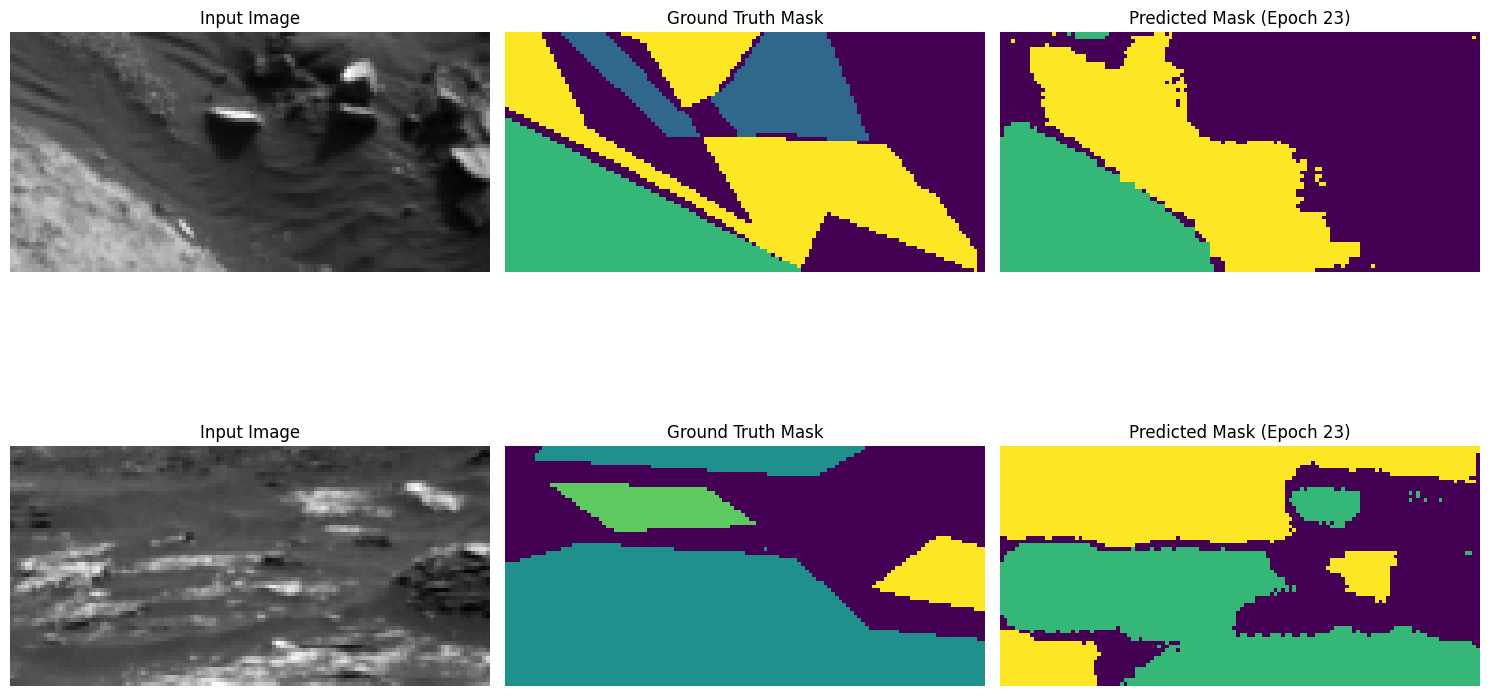

314/314 ━━━━━━━━━━━━━━━━━━━━ 54s 173ms/step - accuracy: 0.7766 - custom_mean_iou: 0.4115 - loss: 0.5693 - mean_io_u: 0.4674 - val_accuracy: 0.7537 - val_custom_mean_iou: 0.3932 - val_loss: 0.6797 - val_mean_io_u: 0.4537 - learning_rate: 1.0000e-04
Epoch 24/1000
313/314 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.7820 - custom_mean_iou: 0.4157 - loss: 0.5541 - mean_io_u: 0.4711Available log keys: dict_keys(['accuracy', 'custom_mean_iou', 'loss', 'mean_io_u', 'val_accuracy', 'val_custom_mean_iou', 'val_loss', 'val_mean_io_u'])

Epoch 24: val_loss did not improve from 0.65350
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


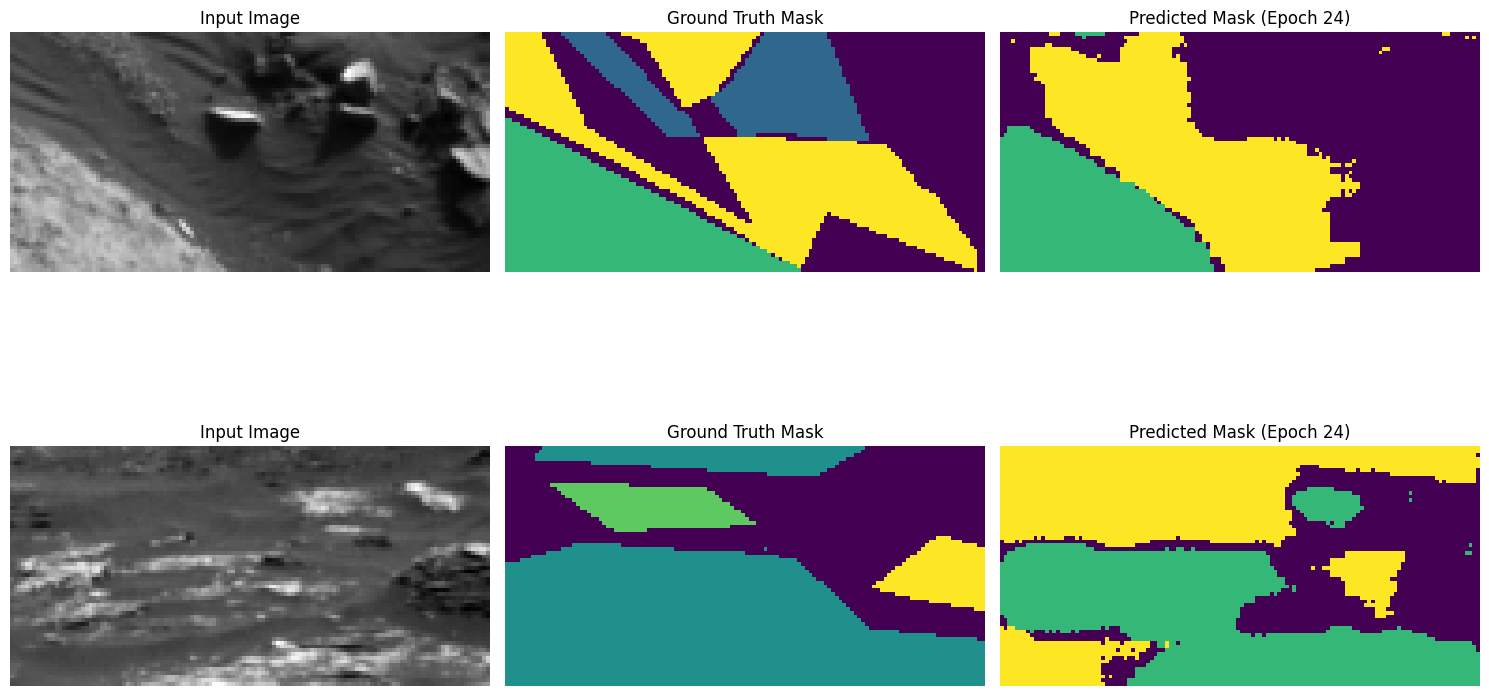

314/314 ━━━━━━━━━━━━━━━━━━━━ 54s 173ms/step - accuracy: 0.7821 - custom_mean_iou: 0.4157 - loss: 0.5540 - mean_io_u: 0.4711 - val_accuracy: 0.7551 - val_custom_mean_iou: 0.3952 - val_loss: 0.6599 - val_mean_io_u: 0.4576 - learning_rate: 1.0000e-04
Epoch 25/1000
313/314 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.7869 - custom_mean_iou: 0.4213 - loss: 0.5424 - mean_io_u: 0.4769Available log keys: dict_keys(['accuracy', 'custom_mean_iou', 'loss', 'mean_io_u', 'val_accuracy', 'val_custom_mean_iou', 'val_loss', 'val_mean_io_u'])

Epoch 25: val_loss did not improve from 0.65350
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


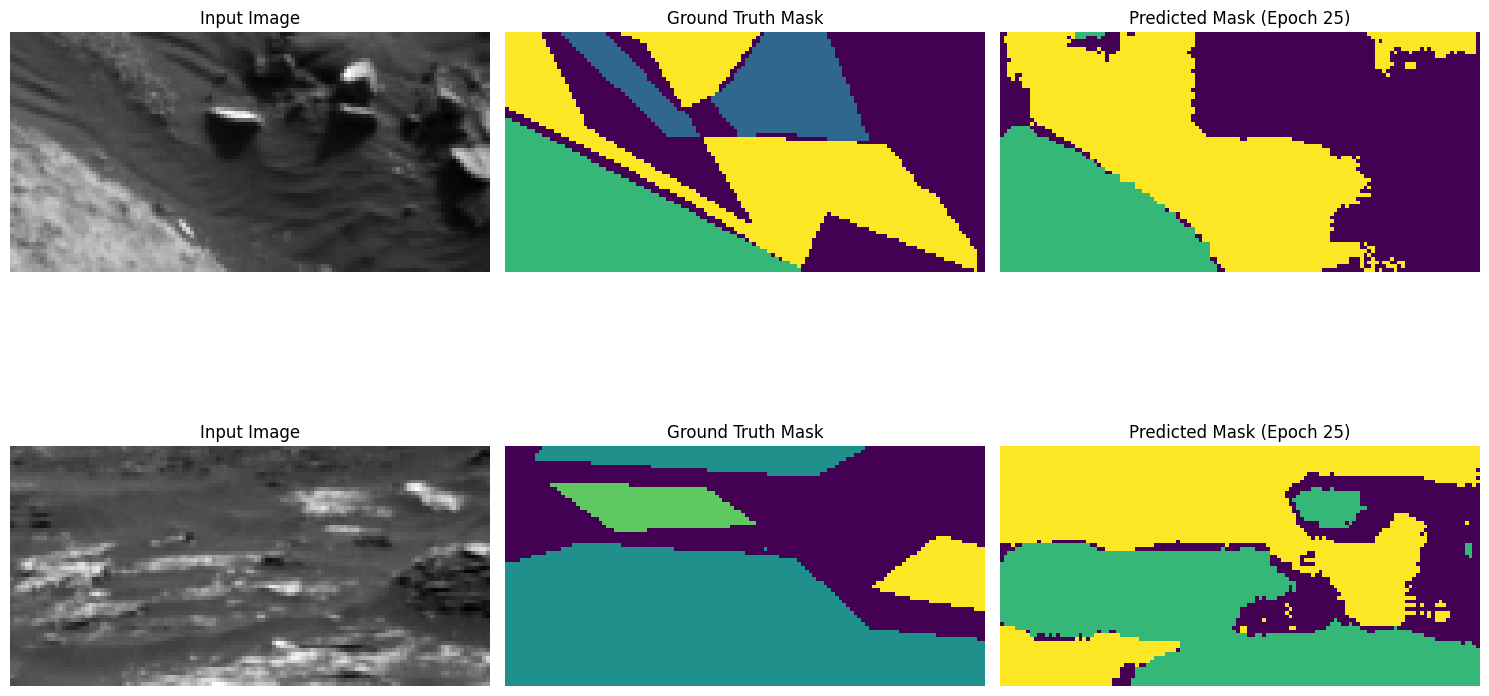

314/314 ━━━━━━━━━━━━━━━━━━━━ 54s 173ms/step - accuracy: 0.7869 - custom_mean_iou: 0.4213 - loss: 0.5424 - mean_io_u: 0.4768 - val_accuracy: 0.7557 - val_custom_mean_iou: 0.3970 - val_loss: 0.6682 - val_mean_io_u: 0.4626 - learning_rate: 1.0000e-04
Epoch 26/1000
313/314 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.7896 - custom_mean_iou: 0.4215 - loss: 0.5398 - mean_io_u: 0.4771Available log keys: dict_keys(['accuracy', 'custom_mean_iou', 'loss', 'mean_io_u', 'val_accuracy', 'val_custom_mean_iou', 'val_loss', 'val_mean_io_u'])
Epoch 26: val_custom_mean_iou improved to 0.4007, saving model.

Epoch 26: val_loss did not improve from 0.65350

Epoch 26: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


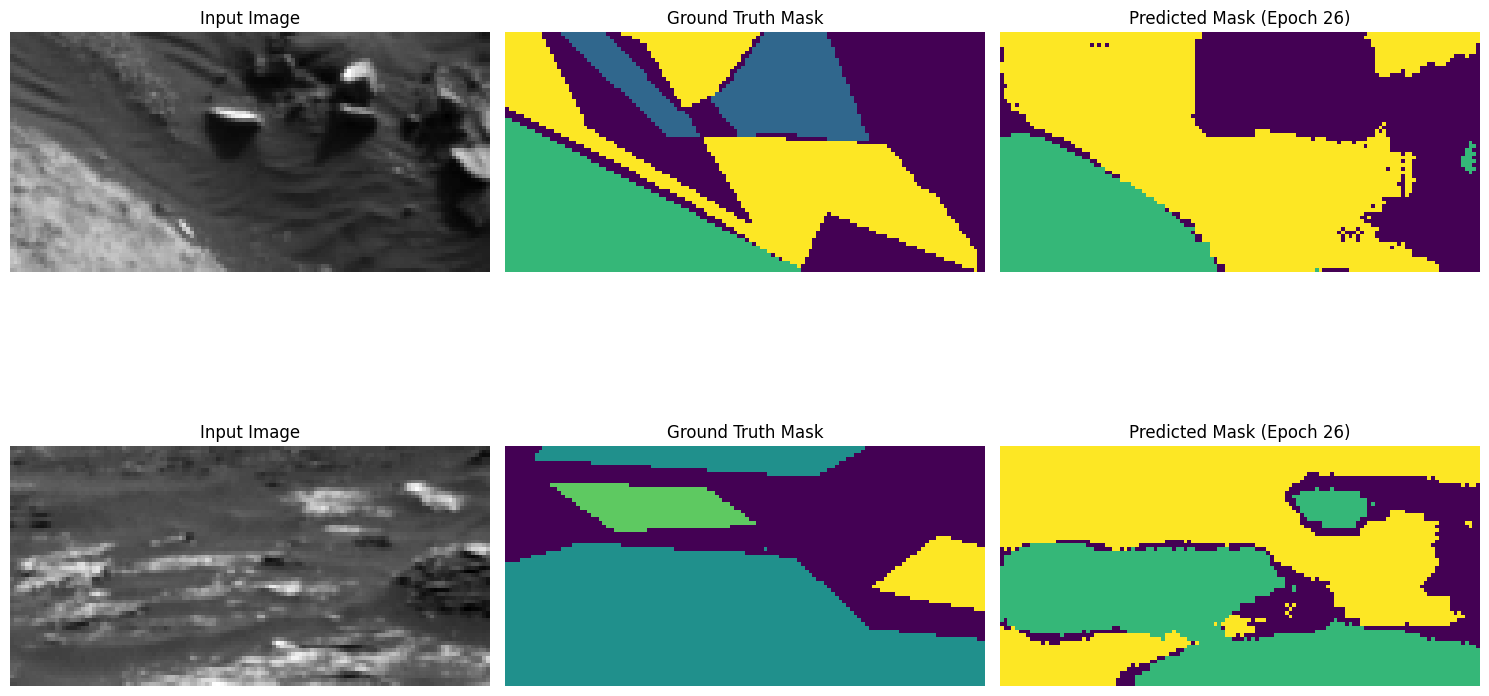

314/314 ━━━━━━━━━━━━━━━━━━━━ 55s 174ms/step - accuracy: 0.7897 - custom_mean_iou: 0.4215 - loss: 0.5397 - mean_io_u: 0.4771 - val_accuracy: 0.7598 - val_custom_mean_iou: 0.4007 - val_loss: 0.6560 - val_mean_io_u: 0.4670 - learning_rate: 1.0000e-04
Epoch 27/1000
313/314 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.8061 - custom_mean_iou: 0.4465 - loss: 0.4977 - mean_io_u: 0.5030Available log keys: dict_keys(['accuracy', 'custom_mean_iou', 'loss', 'mean_io_u', 'val_accuracy', 'val_custom_mean_iou', 'val_loss', 'val_mean_io_u'])
Epoch 27: val_custom_mean_iou improved to 0.4062, saving model.

Epoch 27: val_loss improved from 0.65350 to 0.63431, saving model to best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


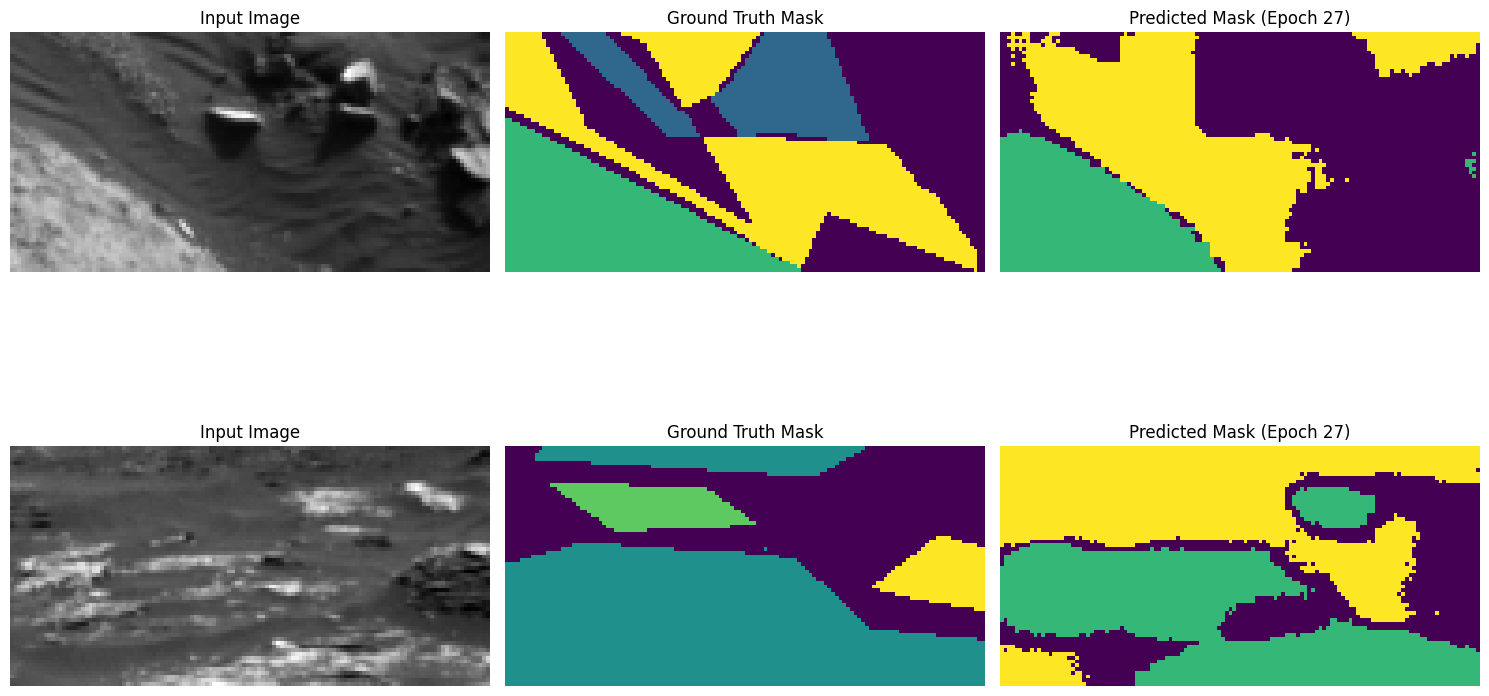

314/314 ━━━━━━━━━━━━━━━━━━━━ 55s 175ms/step - accuracy: 0.8062 - custom_mean_iou: 0.4465 - loss: 0.4976 - mean_io_u: 0.5029 - val_accuracy: 0.7641 - val_custom_mean_iou: 0.4062 - val_loss: 0.6343 - val_mean_io_u: 0.4638 - learning_rate: 5.0000e-05
Epoch 28/1000
313/314 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.8150 - custom_mean_iou: 0.4564 - loss: 0.4751 - mean_io_u: 0.5117Available log keys: dict_keys(['accuracy', 'custom_mean_iou', 'loss', 'mean_io_u', 'val_accuracy', 'val_custom_mean_iou', 'val_loss', 'val_mean_io_u'])
Epoch 28: val_custom_mean_iou improved to 0.4084, saving model.

Epoch 28: val_loss did not improve from 0.63431
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


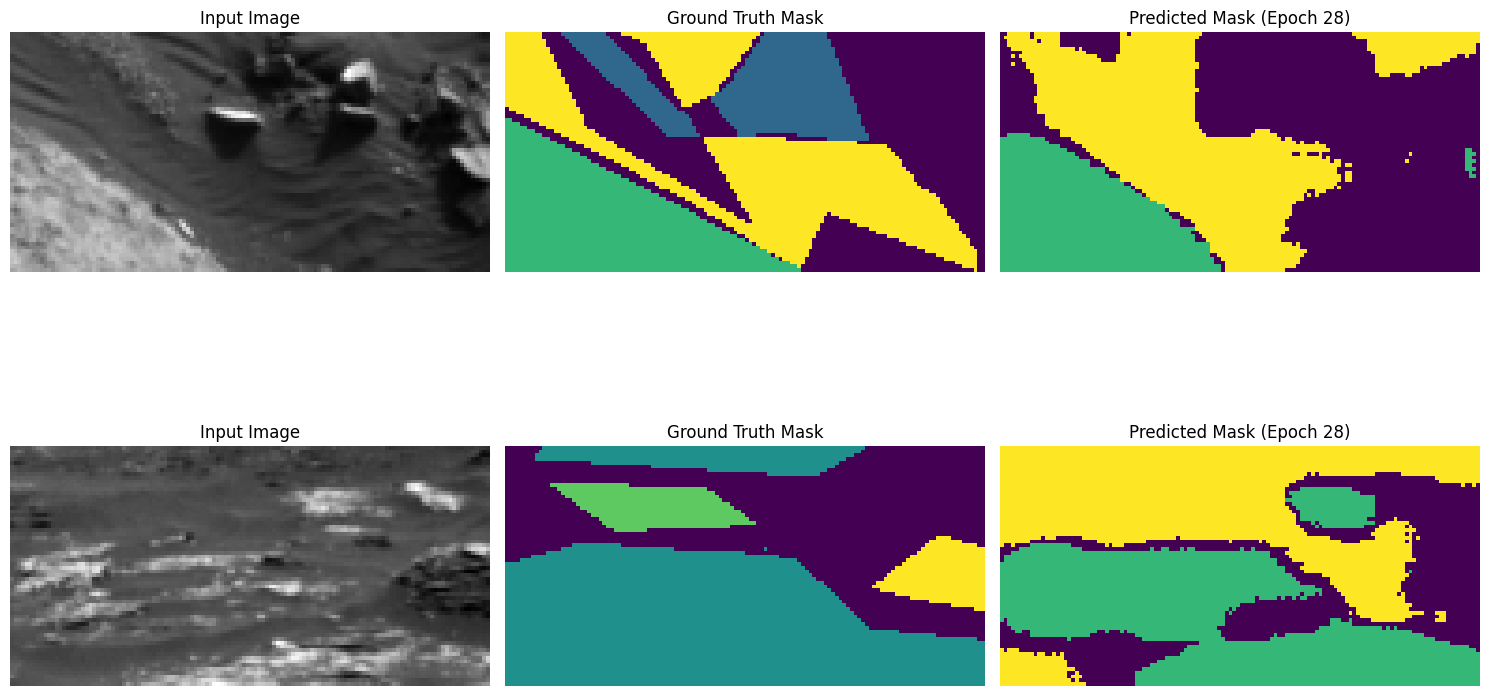

314/314 ━━━━━━━━━━━━━━━━━━━━ 55s 174ms/step - accuracy: 0.8150 - custom_mean_iou: 0.4563 - loss: 0.4750 - mean_io_u: 0.5116 - val_accuracy: 0.7662 - val_custom_mean_iou: 0.4084 - val_loss: 0.6394 - val_mean_io_u: 0.4659 - learning_rate: 5.0000e-05
Epoch 29/1000
313/314 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.8203 - custom_mean_iou: 0.4627 - loss: 0.4622 - mean_io_u: 0.5174Available log keys: dict_keys(['accuracy', 'custom_mean_iou', 'loss', 'mean_io_u', 'val_accuracy', 'val_custom_mean_iou', 'val_loss', 'val_mean_io_u'])
Epoch 29: val_custom_mean_iou improved to 0.4097, saving model.

Epoch 29: val_loss did not improve from 0.63431
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


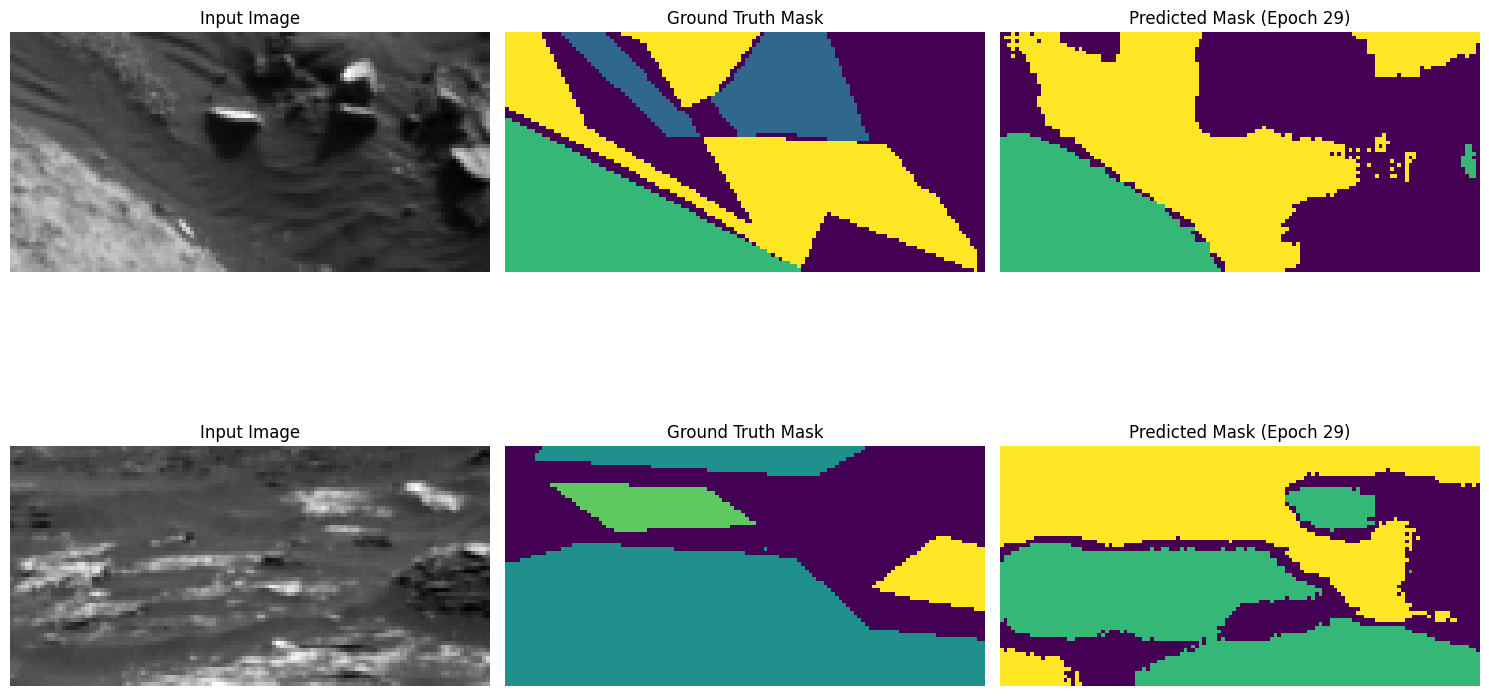

314/314 ━━━━━━━━━━━━━━━━━━━━ 55s 174ms/step - accuracy: 0.8204 - custom_mean_iou: 0.4627 - loss: 0.4622 - mean_io_u: 0.5174 - val_accuracy: 0.7673 - val_custom_mean_iou: 0.4097 - val_loss: 0.6464 - val_mean_io_u: 0.4672 - learning_rate: 5.0000e-05
Epoch 30/1000
313/314 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.8252 - custom_mean_iou: 0.4682 - loss: 0.4505 - mean_io_u: 0.5223Available log keys: dict_keys(['accuracy', 'custom_mean_iou', 'loss', 'mean_io_u', 'val_accuracy', 'val_custom_mean_iou', 'val_loss', 'val_mean_io_u'])
Epoch 30: val_custom_mean_iou improved to 0.4107, saving model.

Epoch 30: val_loss did not improve from 0.63431
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


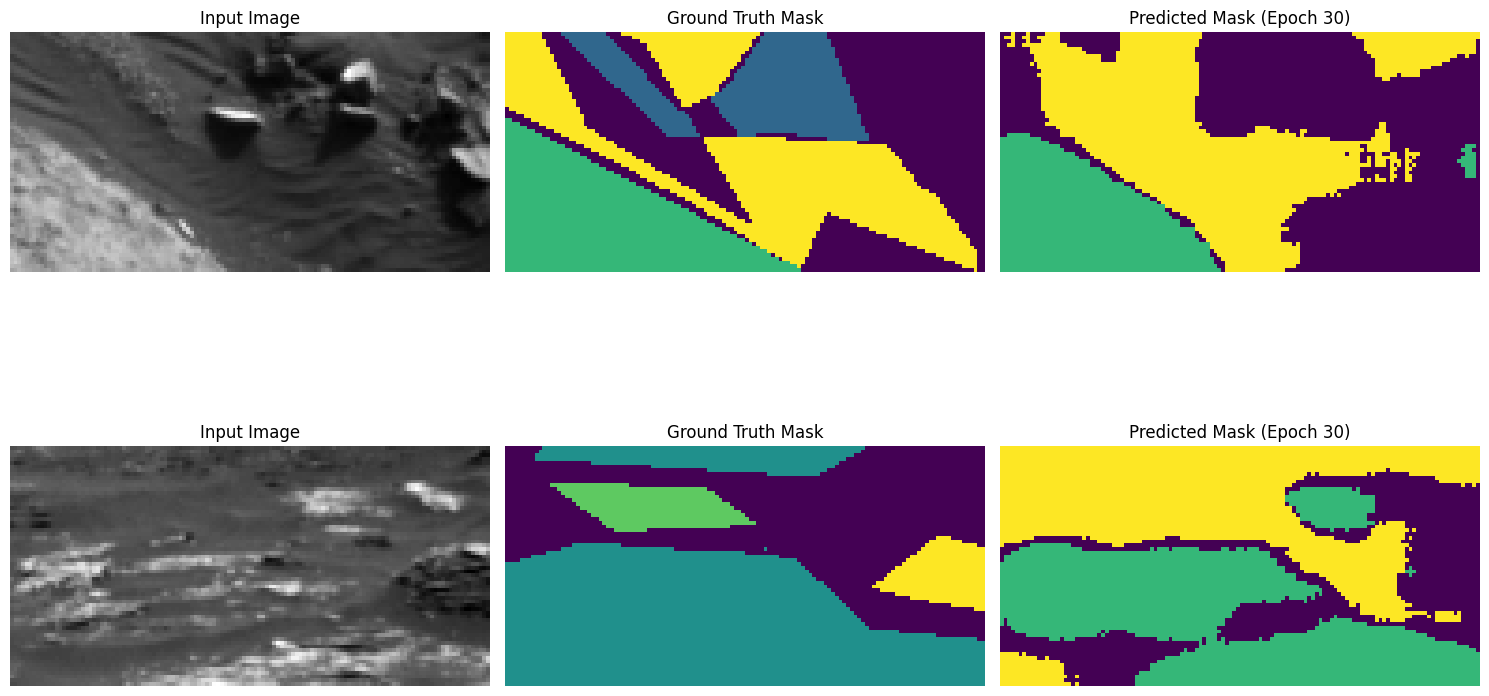

314/314 ━━━━━━━━━━━━━━━━━━━━ 55s 174ms/step - accuracy: 0.8253 - custom_mean_iou: 0.4682 - loss: 0.4504 - mean_io_u: 0.5223 - val_accuracy: 0.7677 - val_custom_mean_iou: 0.4107 - val_loss: 0.6548 - val_mean_io_u: 0.4681 - learning_rate: 5.0000e-05
Epoch 31/1000
313/314 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.8293 - custom_mean_iou: 0.4726 - loss: 0.4408 - mean_io_u: 0.5261Available log keys: dict_keys(['accuracy', 'custom_mean_iou', 'loss', 'mean_io_u', 'val_accuracy', 'val_custom_mean_iou', 'val_loss', 'val_mean_io_u'])
Epoch 31: val_custom_mean_iou improved to 0.4125, saving model.

Epoch 31: val_loss did not improve from 0.63431
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


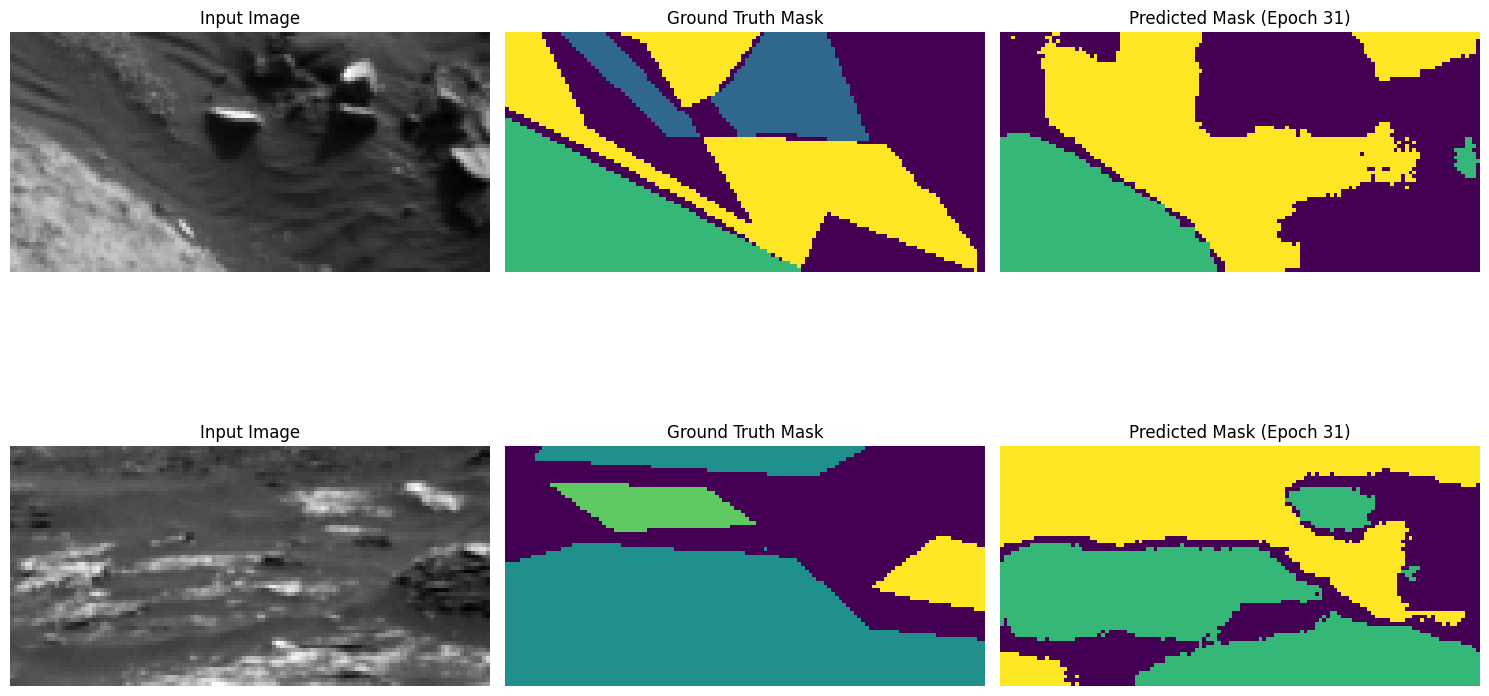

314/314 ━━━━━━━━━━━━━━━━━━━━ 55s 175ms/step - accuracy: 0.8293 - custom_mean_iou: 0.4725 - loss: 0.4407 - mean_io_u: 0.5261 - val_accuracy: 0.7683 - val_custom_mean_iou: 0.4125 - val_loss: 0.6624 - val_mean_io_u: 0.4698 - learning_rate: 5.0000e-05
Epoch 32/1000
313/314 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.8344 - custom_mean_iou: 0.4787 - loss: 0.4281 - mean_io_u: 0.5318Available log keys: dict_keys(['accuracy', 'custom_mean_iou', 'loss', 'mean_io_u', 'val_accuracy', 'val_custom_mean_iou', 'val_loss', 'val_mean_io_u'])
Epoch 32: val_custom_mean_iou improved to 0.4147, saving model.

Epoch 32: val_loss did not improve from 0.63431

Epoch 32: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


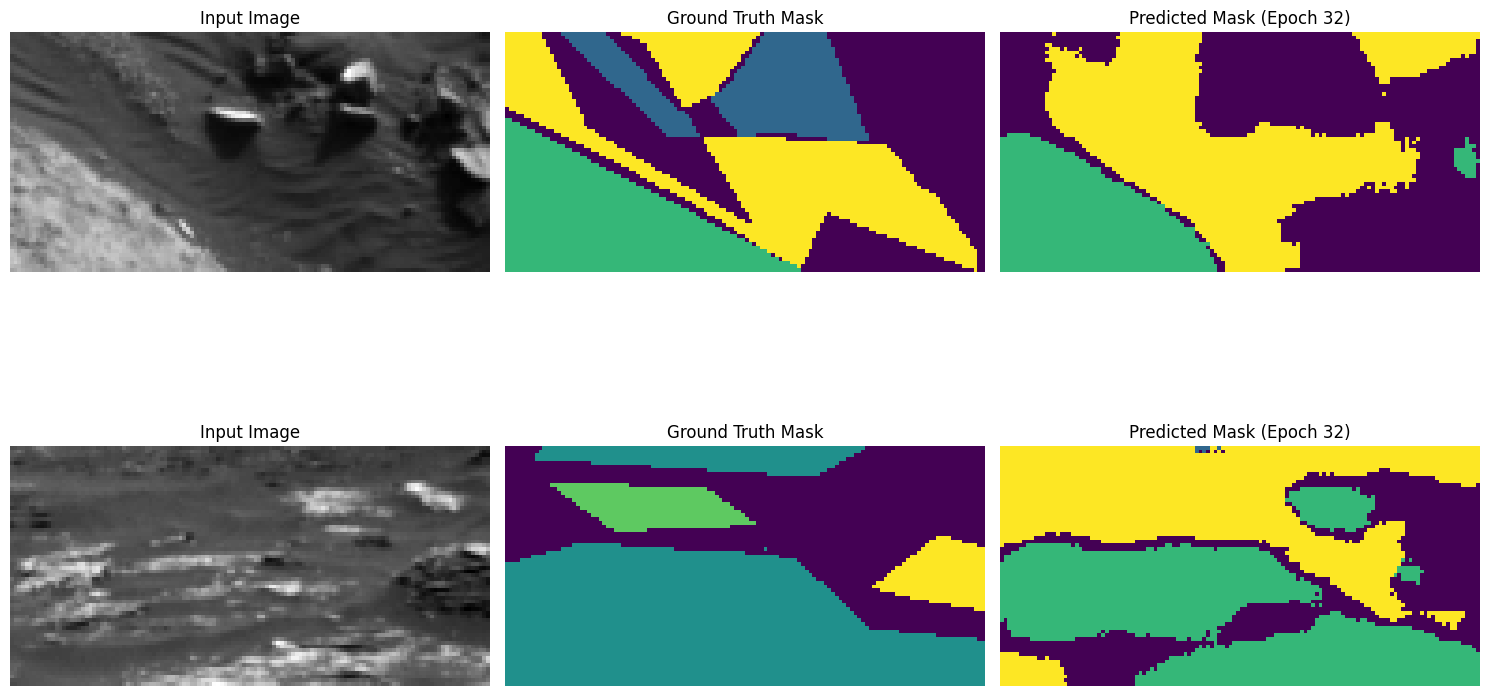

314/314 ━━━━━━━━━━━━━━━━━━━━ 55s 174ms/step - accuracy: 0.8345 - custom_mean_iou: 0.4787 - loss: 0.4280 - mean_io_u: 0.5318 - val_accuracy: 0.7687 - val_custom_mean_iou: 0.4147 - val_loss: 0.6727 - val_mean_io_u: 0.4716 - learning_rate: 5.0000e-05
Epoch 33/1000
313/314 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.8431 - custom_mean_iou: 0.4908 - loss: 0.4027 - mean_io_u: 0.5436Available log keys: dict_keys(['accuracy', 'custom_mean_iou', 'loss', 'mean_io_u', 'val_accuracy', 'val_custom_mean_iou', 'val_loss', 'val_mean_io_u'])

Epoch 33: val_loss did not improve from 0.63431
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


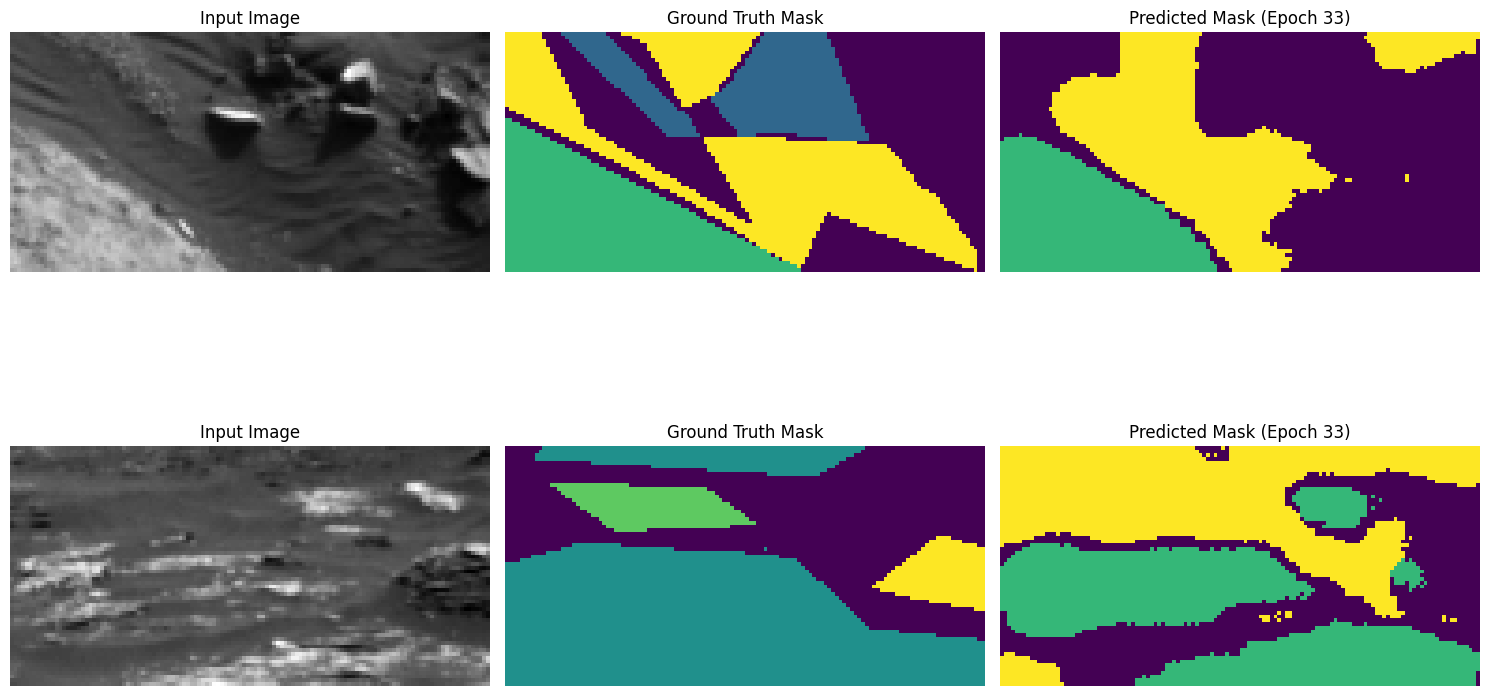

314/314 ━━━━━━━━━━━━━━━━━━━━ 54s 173ms/step - accuracy: 0.8431 - custom_mean_iou: 0.4908 - loss: 0.4026 - mean_io_u: 0.5436 - val_accuracy: 0.7669 - val_custom_mean_iou: 0.4112 - val_loss: 0.6779 - val_mean_io_u: 0.4623 - learning_rate: 2.5000e-05
Epoch 34/1000
313/314 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.8487 - custom_mean_iou: 0.4960 - loss: 0.3895 - mean_io_u: 0.5479Available log keys: dict_keys(['accuracy', 'custom_mean_iou', 'loss', 'mean_io_u', 'val_accuracy', 'val_custom_mean_iou', 'val_loss', 'val_mean_io_u'])

Epoch 34: val_loss did not improve from 0.63431
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


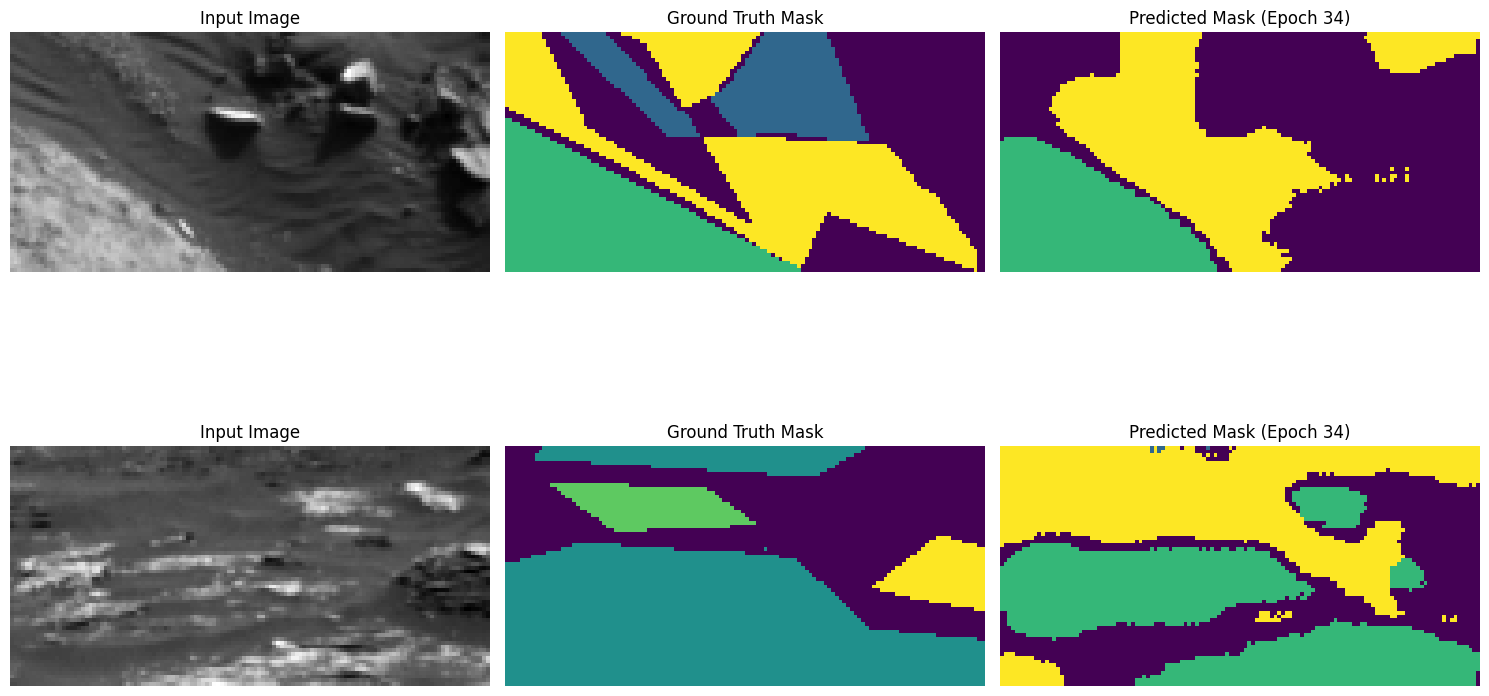

314/314 ━━━━━━━━━━━━━━━━━━━━ 54s 173ms/step - accuracy: 0.8487 - custom_mean_iou: 0.4959 - loss: 0.3895 - mean_io_u: 0.5479 - val_accuracy: 0.7667 - val_custom_mean_iou: 0.4117 - val_loss: 0.6896 - val_mean_io_u: 0.4629 - learning_rate: 2.5000e-05
Epoch 35/1000
313/314 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.8525 - custom_mean_iou: 0.5014 - loss: 0.3802 - mean_io_u: 0.5528Available log keys: dict_keys(['accuracy', 'custom_mean_iou', 'loss', 'mean_io_u', 'val_accuracy', 'val_custom_mean_iou', 'val_loss', 'val_mean_io_u'])

Epoch 35: val_loss did not improve from 0.63431
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


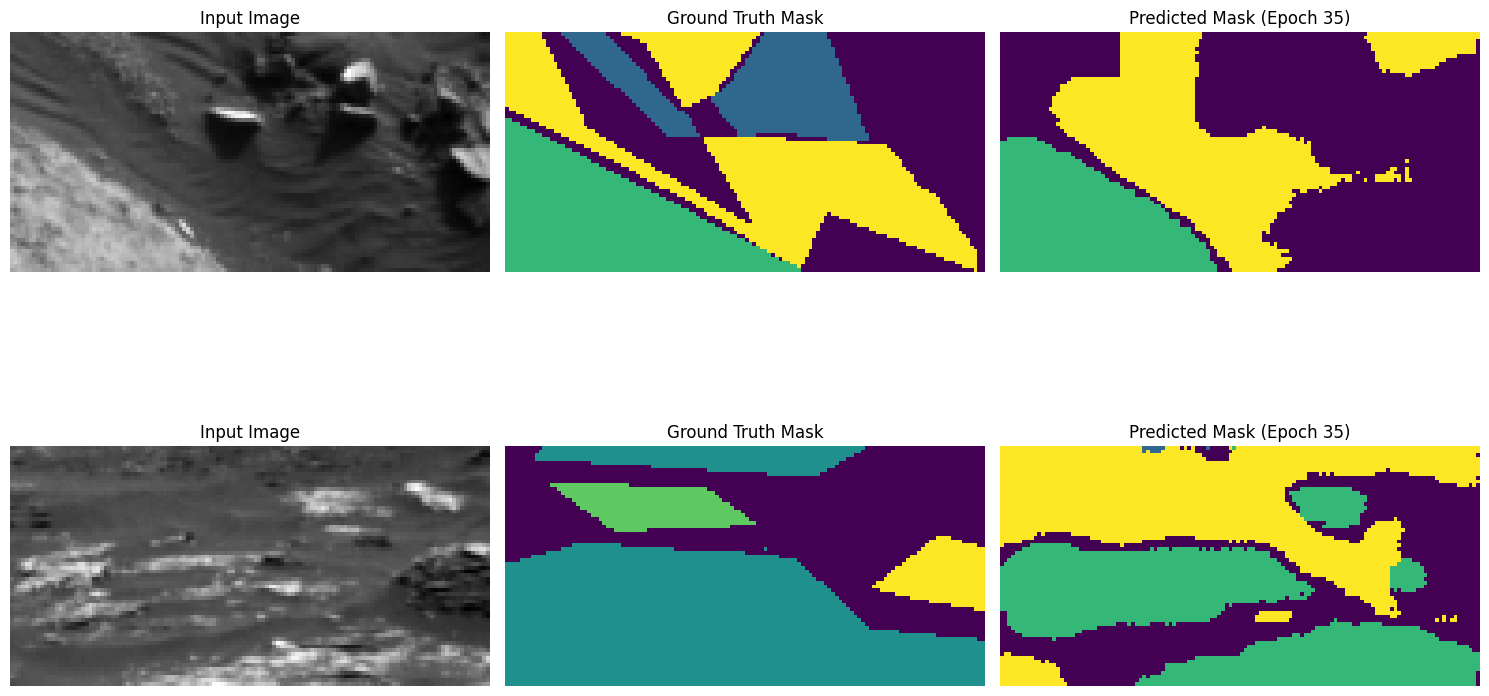

314/314 ━━━━━━━━━━━━━━━━━━━━ 54s 173ms/step - accuracy: 0.8526 - custom_mean_iou: 0.5014 - loss: 0.3801 - mean_io_u: 0.5528 - val_accuracy: 0.7665 - val_custom_mean_iou: 0.4126 - val_loss: 0.7002 - val_mean_io_u: 0.4638 - learning_rate: 2.5000e-05
Epoch 36/1000
313/314 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.8562 - custom_mean_iou: 0.5062 - loss: 0.3716 - mean_io_u: 0.5571Available log keys: dict_keys(['accuracy', 'custom_mean_iou', 'loss', 'mean_io_u', 'val_accuracy', 'val_custom_mean_iou', 'val_loss', 'val_mean_io_u'])

Epoch 36: val_loss did not improve from 0.63431
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


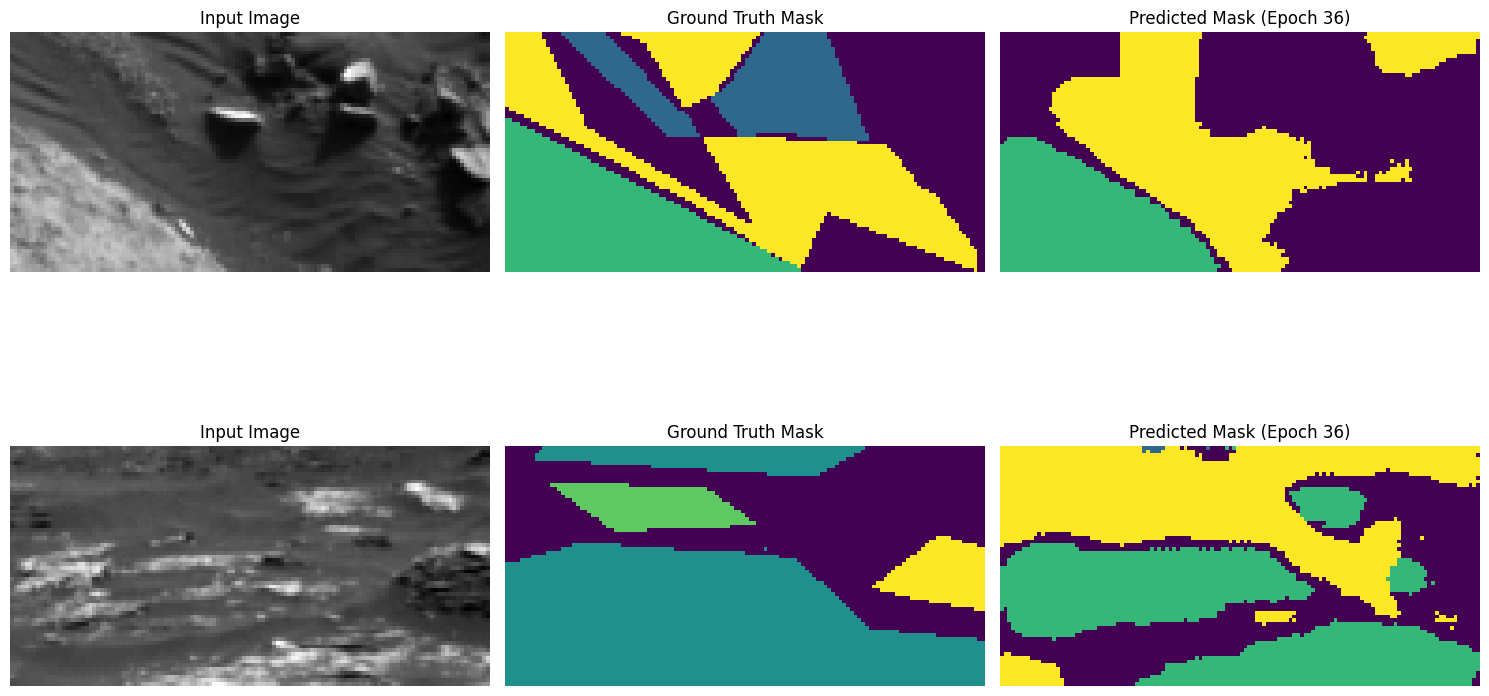

314/314 ━━━━━━━━━━━━━━━━━━━━ 54s 173ms/step - accuracy: 0.8562 - custom_mean_iou: 0.5061 - loss: 0.3715 - mean_io_u: 0.5571 - val_accuracy: 0.7663 - val_custom_mean_iou: 0.4132 - val_loss: 0.7103 - val_mean_io_u: 0.4644 - learning_rate: 2.5000e-05
Epoch 37/1000
313/314 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.8596 - custom_mean_iou: 0.5107 - loss: 0.3631 - mean_io_u: 0.5611Available log keys: dict_keys(['accuracy', 'custom_mean_iou', 'loss', 'mean_io_u', 'val_accuracy', 'val_custom_mean_iou', 'val_loss', 'val_mean_io_u'])

Epoch 37: val_loss did not improve from 0.63431

Epoch 37: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


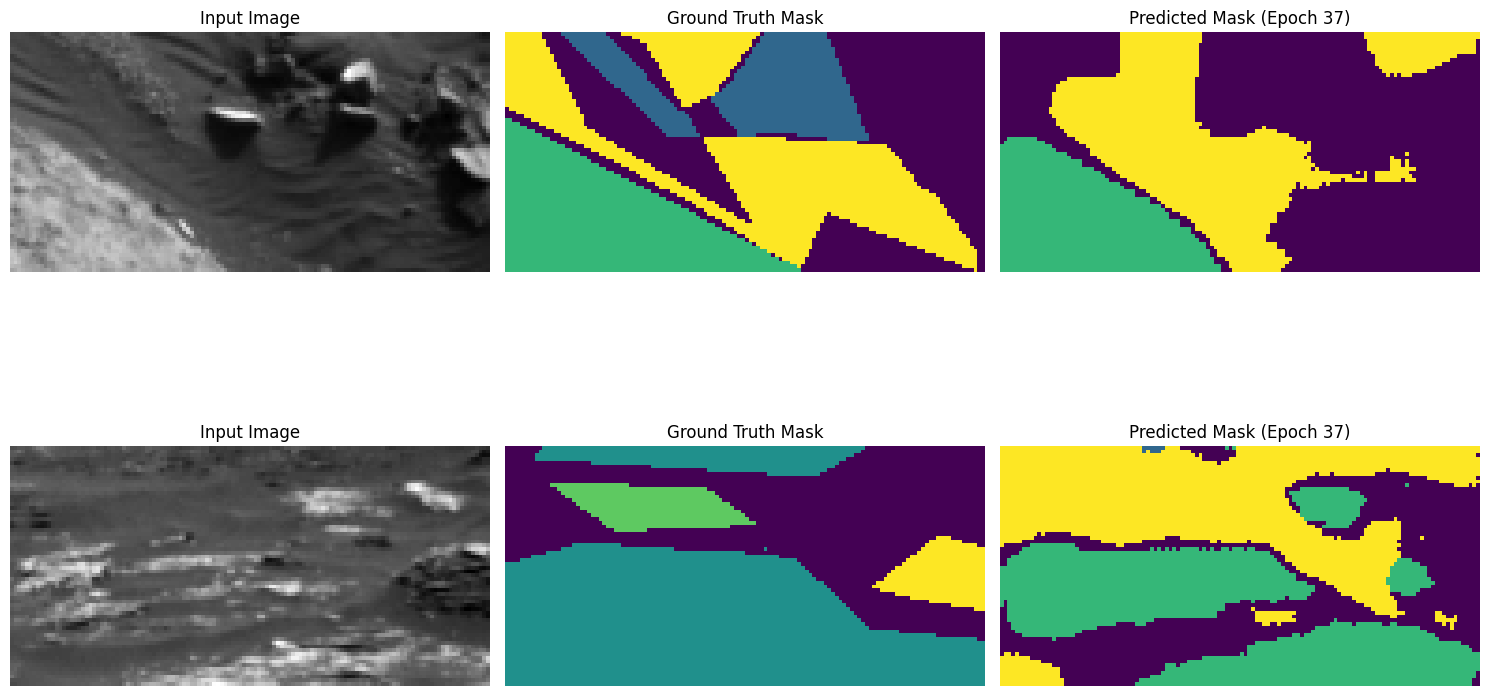

314/314 ━━━━━━━━━━━━━━━━━━━━ 54s 173ms/step - accuracy: 0.8597 - custom_mean_iou: 0.5106 - loss: 0.3630 - mean_io_u: 0.5610 - val_accuracy: 0.7661 - val_custom_mean_iou: 0.4137 - val_loss: 0.7212 - val_mean_io_u: 0.4651 - learning_rate: 2.5000e-05
Epoch 38/1000
313/314 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.8638 - custom_mean_iou: 0.5147 - loss: 0.3527 - mean_io_u: 0.5643Available log keys: dict_keys(['accuracy', 'custom_mean_iou', 'loss', 'mean_io_u', 'val_accuracy', 'val_custom_mean_iou', 'val_loss', 'val_mean_io_u'])
Epoch 38: val_custom_mean_iou improved to 0.4204, saving model.

Epoch 38: val_loss did not improve from 0.63431
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


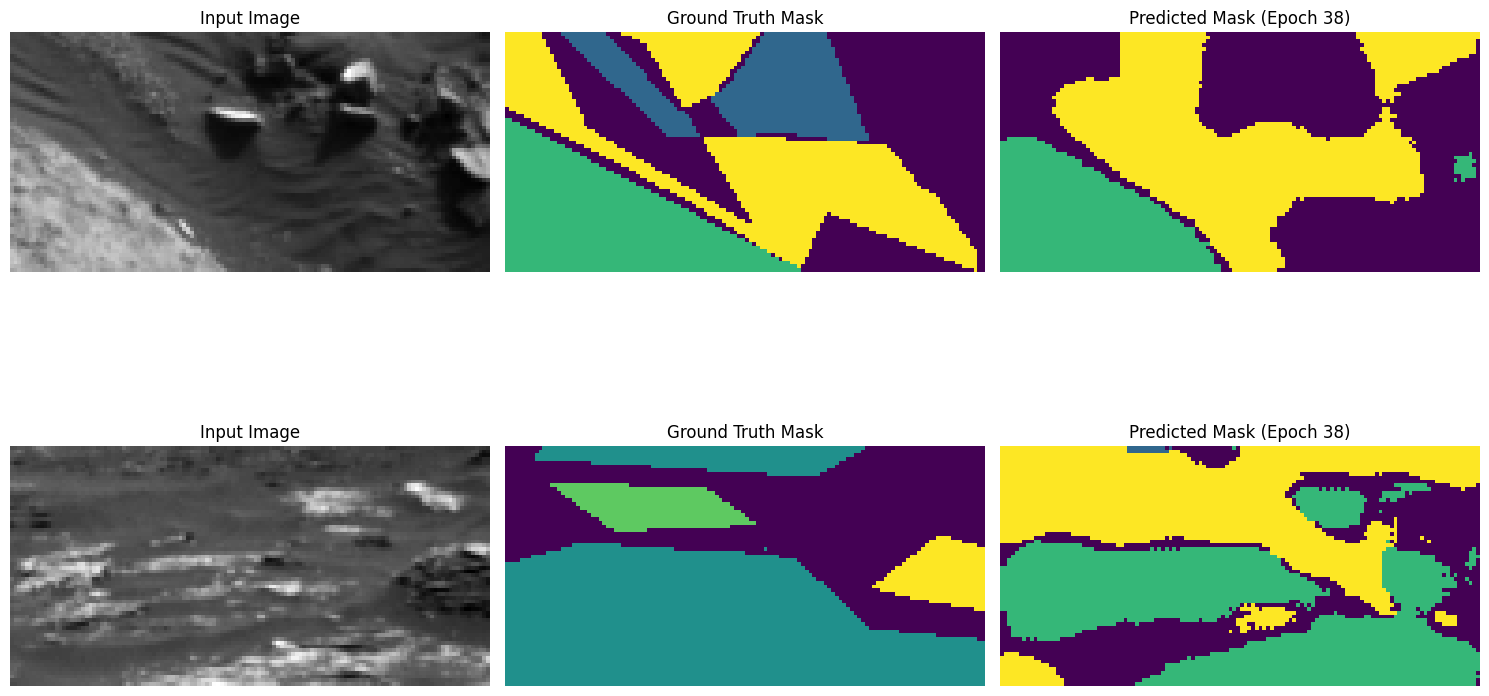

314/314 ━━━━━━━━━━━━━━━━━━━━ 55s 175ms/step - accuracy: 0.8639 - custom_mean_iou: 0.5146 - loss: 0.3526 - mean_io_u: 0.5643 - val_accuracy: 0.7717 - val_custom_mean_iou: 0.4204 - val_loss: 0.7249 - val_mean_io_u: 0.4777 - learning_rate: 1.2500e-05
Epoch 39/1000
313/314 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.8669 - custom_mean_iou: 0.5190 - loss: 0.3452 - mean_io_u: 0.5682Available log keys: dict_keys(['accuracy', 'custom_mean_iou', 'loss', 'mean_io_u', 'val_accuracy', 'val_custom_mean_iou', 'val_loss', 'val_mean_io_u'])
Epoch 39: val_custom_mean_iou improved to 0.4207, saving model.

Epoch 39: val_loss did not improve from 0.63431
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


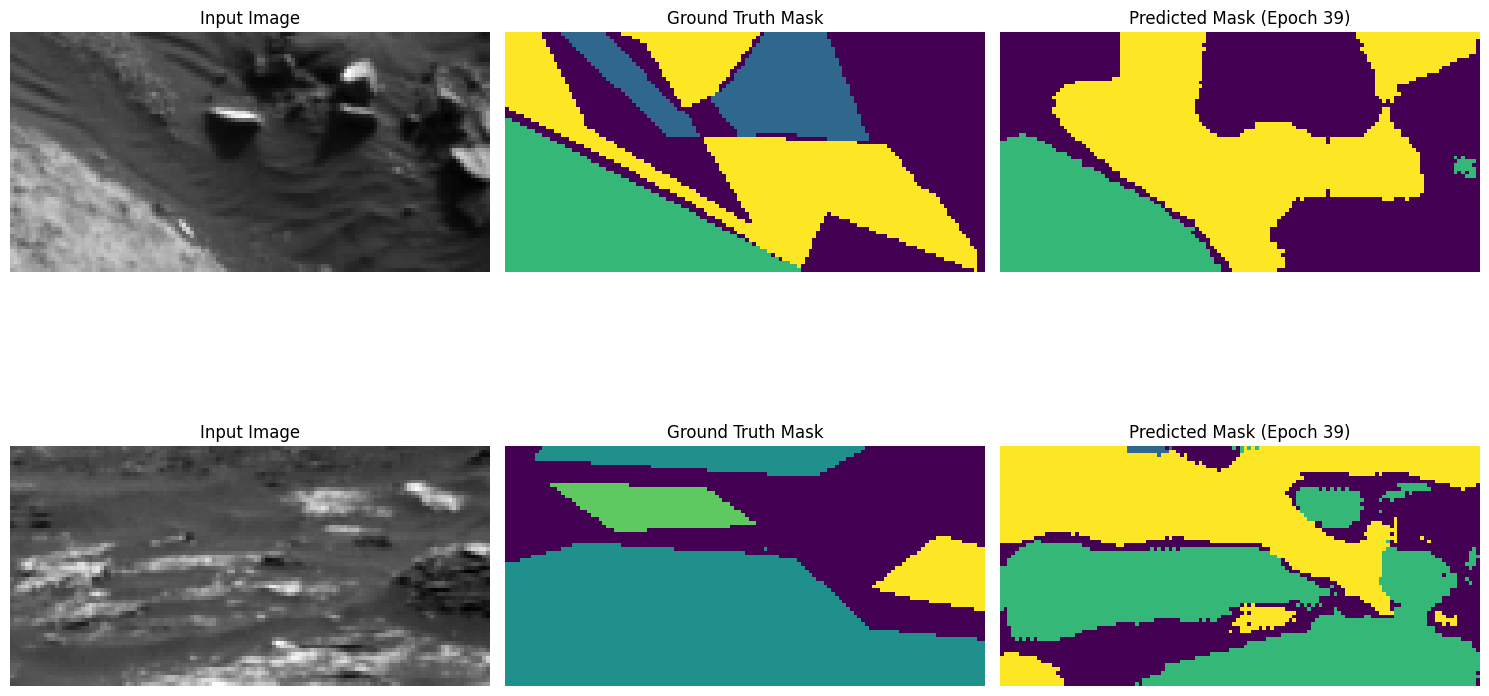

314/314 ━━━━━━━━━━━━━━━━━━━━ 55s 175ms/step - accuracy: 0.8670 - custom_mean_iou: 0.5189 - loss: 0.3452 - mean_io_u: 0.5682 - val_accuracy: 0.7714 - val_custom_mean_iou: 0.4207 - val_loss: 0.7316 - val_mean_io_u: 0.4778 - learning_rate: 1.2500e-05
Epoch 40/1000
313/314 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.8692 - custom_mean_iou: 0.5217 - loss: 0.3396 - mean_io_u: 0.5706Available log keys: dict_keys(['accuracy', 'custom_mean_iou', 'loss', 'mean_io_u', 'val_accuracy', 'val_custom_mean_iou', 'val_loss', 'val_mean_io_u'])

Epoch 40: val_loss did not improve from 0.63431
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


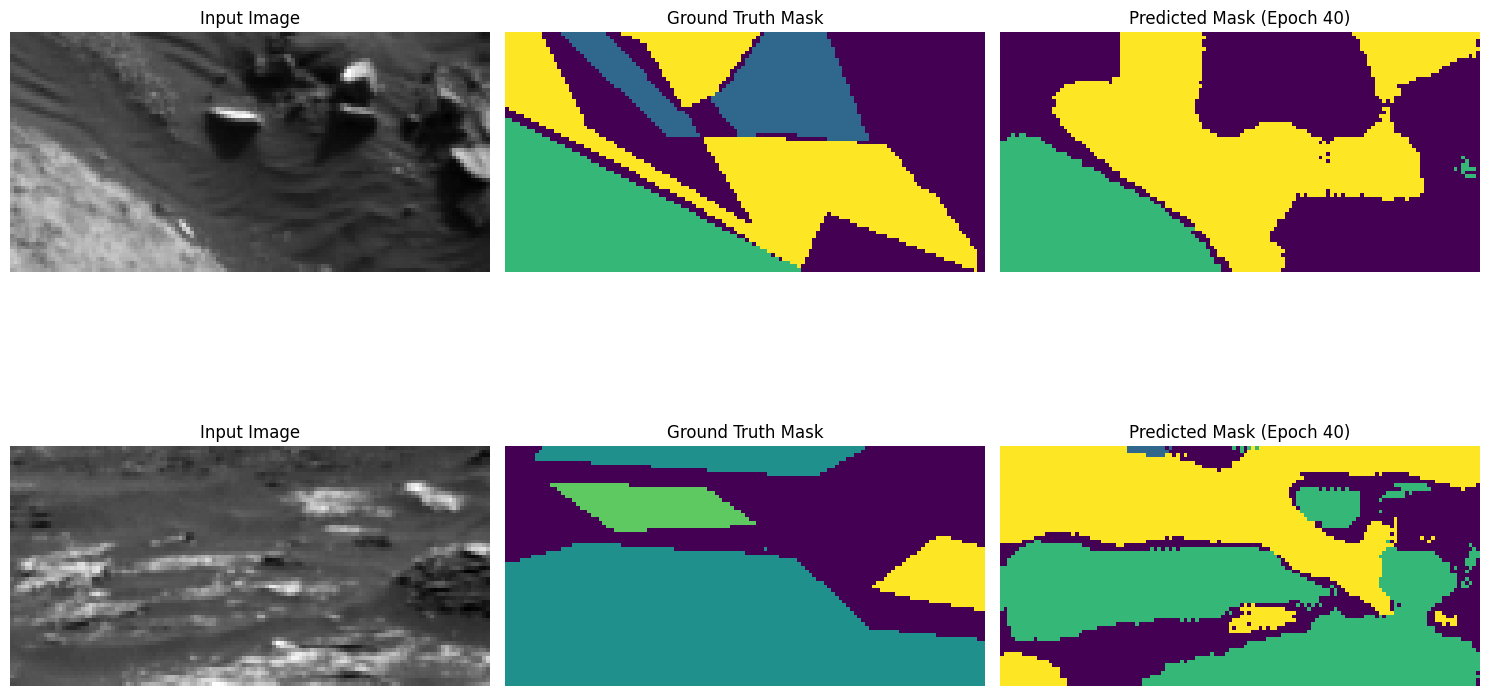

314/314 ━━━━━━━━━━━━━━━━━━━━ 54s 173ms/step - accuracy: 0.8692 - custom_mean_iou: 0.5217 - loss: 0.3396 - mean_io_u: 0.5705 - val_accuracy: 0.7711 - val_custom_mean_iou: 0.4207 - val_loss: 0.7383 - val_mean_io_u: 0.4776 - learning_rate: 1.2500e-05
Epoch 41/1000
313/314 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.8713 - custom_mean_iou: 0.5242 - loss: 0.3345 - mean_io_u: 0.5726Available log keys: dict_keys(['accuracy', 'custom_mean_iou', 'loss', 'mean_io_u', 'val_accuracy', 'val_custom_mean_iou', 'val_loss', 'val_mean_io_u'])

Epoch 41: val_loss did not improve from 0.63431
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


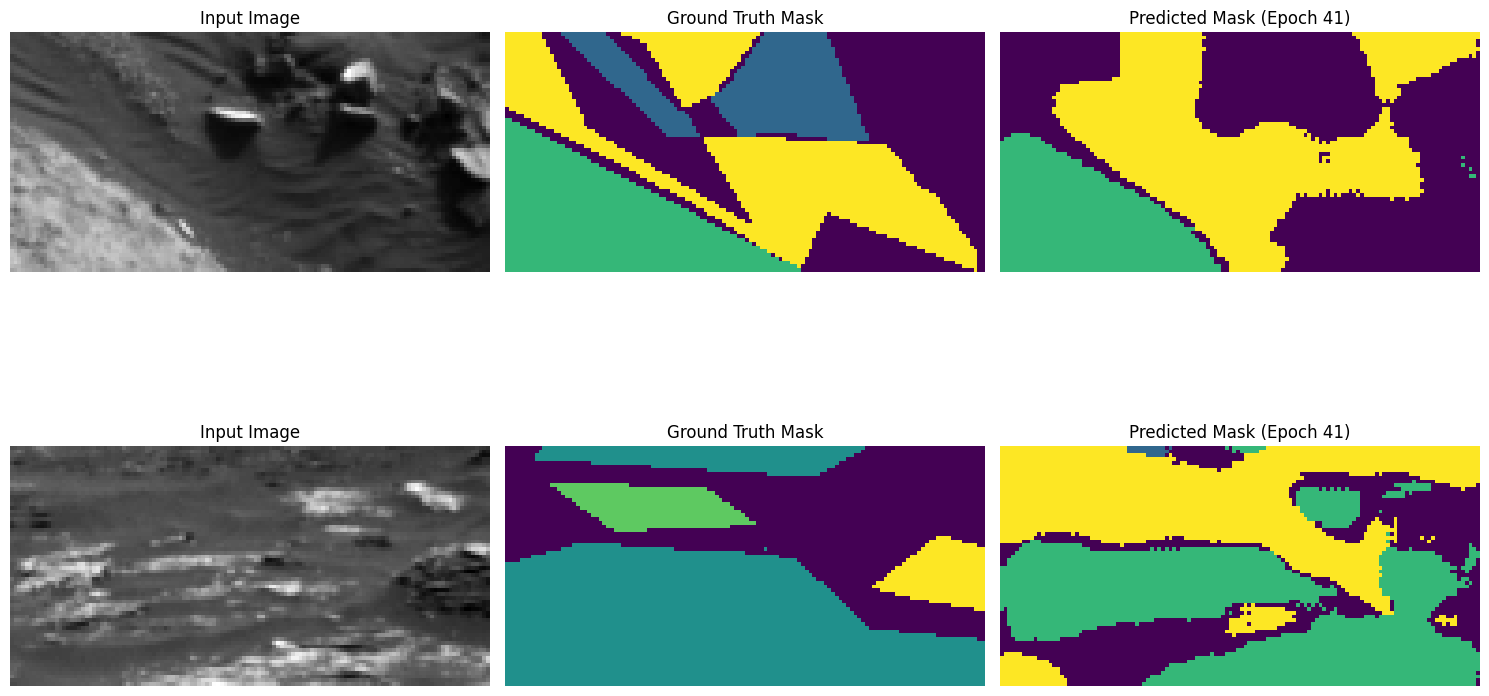

314/314 ━━━━━━━━━━━━━━━━━━━━ 55s 175ms/step - accuracy: 0.8713 - custom_mean_iou: 0.5242 - loss: 0.3345 - mean_io_u: 0.5726 - val_accuracy: 0.7708 - val_custom_mean_iou: 0.4206 - val_loss: 0.7452 - val_mean_io_u: 0.4773 - learning_rate: 1.2500e-05
Epoch 42/1000
313/314 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.8732 - custom_mean_iou: 0.5265 - loss: 0.3297 - mean_io_u: 0.5745Available log keys: dict_keys(['accuracy', 'custom_mean_iou', 'loss', 'mean_io_u', 'val_accuracy', 'val_custom_mean_iou', 'val_loss', 'val_mean_io_u'])

Epoch 42: val_loss did not improve from 0.63431

Epoch 42: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-06.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


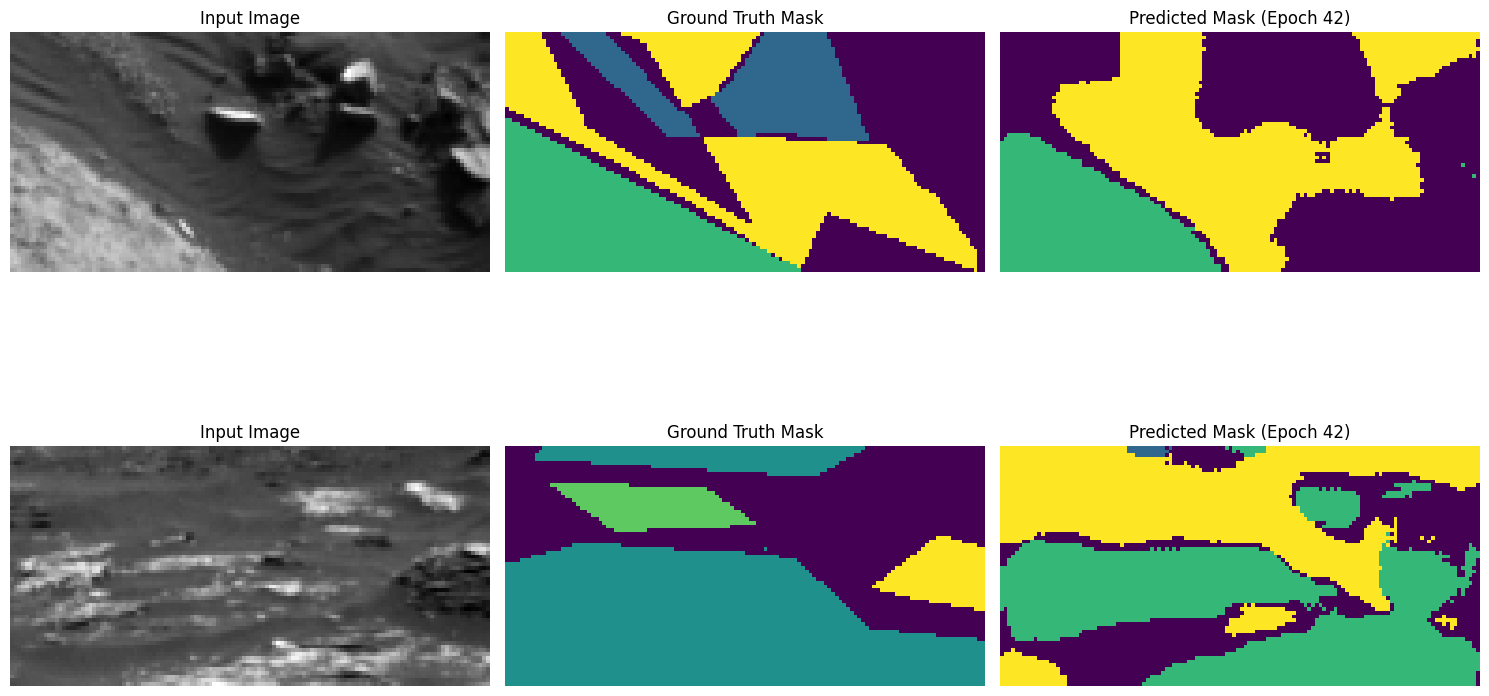

314/314 ━━━━━━━━━━━━━━━━━━━━ 54s 174ms/step - accuracy: 0.8732 - custom_mean_iou: 0.5265 - loss: 0.3296 - mean_io_u: 0.5745 - val_accuracy: 0.7704 - val_custom_mean_iou: 0.4206 - val_loss: 0.7524 - val_mean_io_u: 0.4772 - learning_rate: 1.2500e-05
Epoch 43/1000
313/314 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.8750 - custom_mean_iou: 0.5295 - loss: 0.3240 - mean_io_u: 0.5774Available log keys: dict_keys(['accuracy', 'custom_mean_iou', 'loss', 'mean_io_u', 'val_accuracy', 'val_custom_mean_iou', 'val_loss', 'val_mean_io_u'])

Epoch 43: val_loss did not improve from 0.63431
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


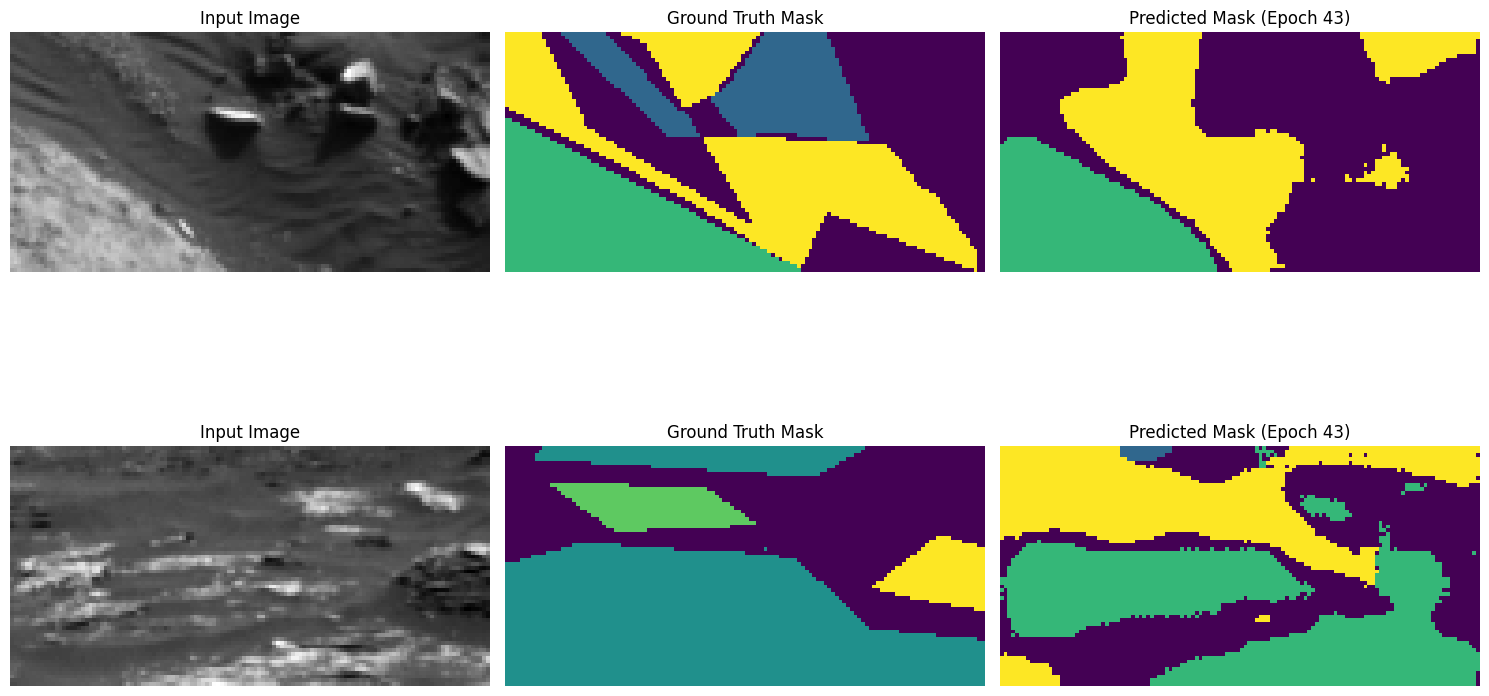

314/314 ━━━━━━━━━━━━━━━━━━━━ 54s 173ms/step - accuracy: 0.8750 - custom_mean_iou: 0.5294 - loss: 0.3240 - mean_io_u: 0.5773 - val_accuracy: 0.7672 - val_custom_mean_iou: 0.4178 - val_loss: 0.7601 - val_mean_io_u: 0.4685 - learning_rate: 6.2500e-06
Epoch 44/1000
313/314 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.8766 - custom_mean_iou: 0.5305 - loss: 0.3199 - mean_io_u: 0.5774Available log keys: dict_keys(['accuracy', 'custom_mean_iou', 'loss', 'mean_io_u', 'val_accuracy', 'val_custom_mean_iou', 'val_loss', 'val_mean_io_u'])

Epoch 44: val_loss did not improve from 0.63431
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


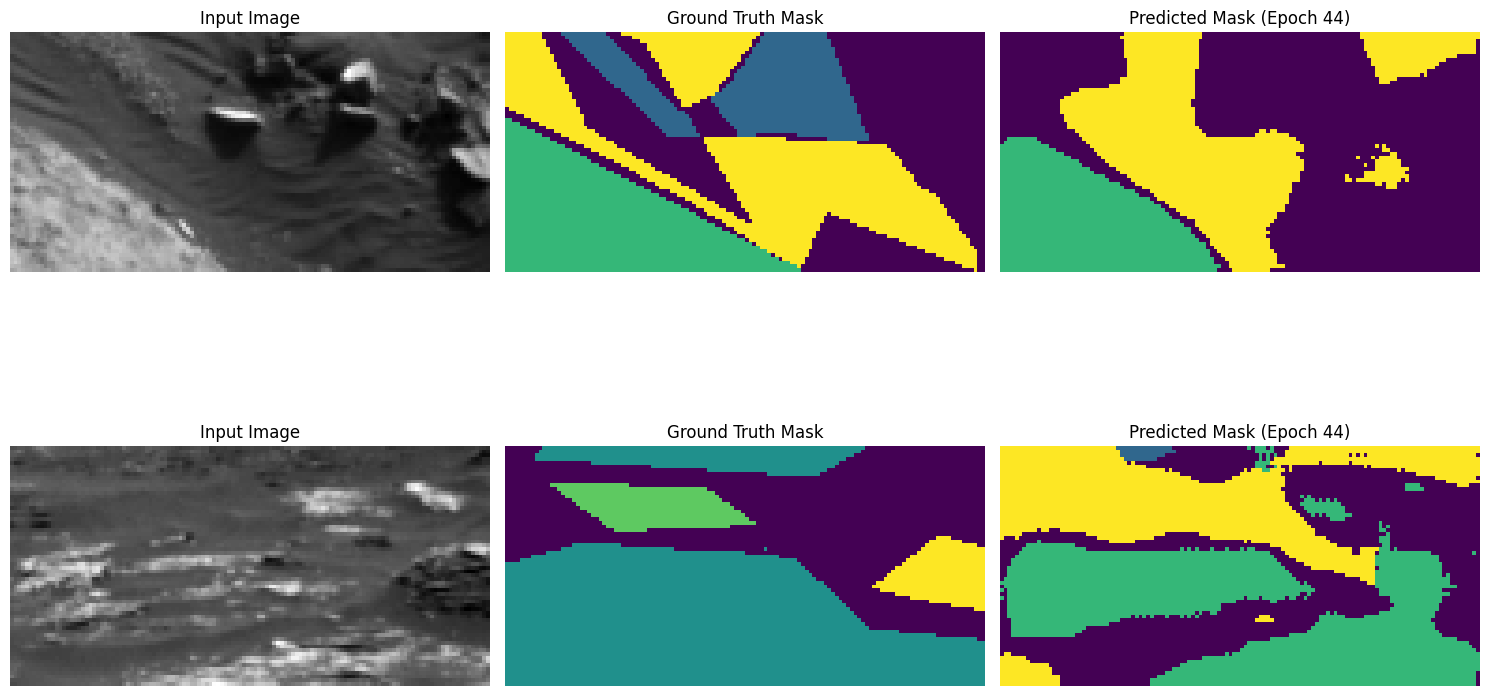

314/314 ━━━━━━━━━━━━━━━━━━━━ 54s 173ms/step - accuracy: 0.8766 - custom_mean_iou: 0.5305 - loss: 0.3198 - mean_io_u: 0.5774 - val_accuracy: 0.7671 - val_custom_mean_iou: 0.4177 - val_loss: 0.7650 - val_mean_io_u: 0.4684 - learning_rate: 6.2500e-06
Epoch 45/1000
313/314 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.8778 - custom_mean_iou: 0.5319 - loss: 0.3168 - mean_io_u: 0.5785Available log keys: dict_keys(['accuracy', 'custom_mean_iou', 'loss', 'mean_io_u', 'val_accuracy', 'val_custom_mean_iou', 'val_loss', 'val_mean_io_u'])

Epoch 45: val_loss did not improve from 0.63431
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


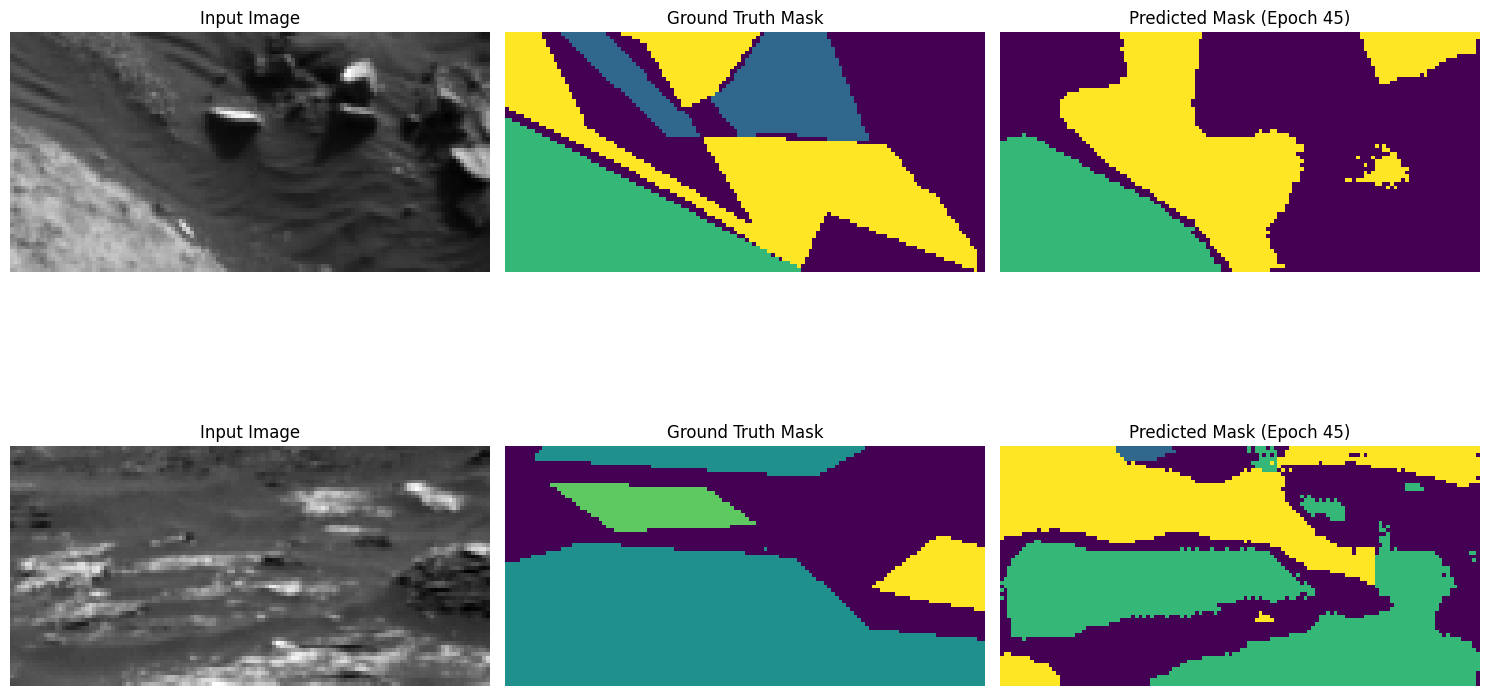

314/314 ━━━━━━━━━━━━━━━━━━━━ 54s 173ms/step - accuracy: 0.8779 - custom_mean_iou: 0.5319 - loss: 0.3168 - mean_io_u: 0.5785 - val_accuracy: 0.7669 - val_custom_mean_iou: 0.4176 - val_loss: 0.7699 - val_mean_io_u: 0.4683 - learning_rate: 6.2500e-06
Epoch 46/1000
313/314 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.8790 - custom_mean_iou: 0.5333 - loss: 0.3140 - mean_io_u: 0.5796Available log keys: dict_keys(['accuracy', 'custom_mean_iou', 'loss', 'mean_io_u', 'val_accuracy', 'val_custom_mean_iou', 'val_loss', 'val_mean_io_u'])

Epoch 46: val_loss did not improve from 0.63431
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


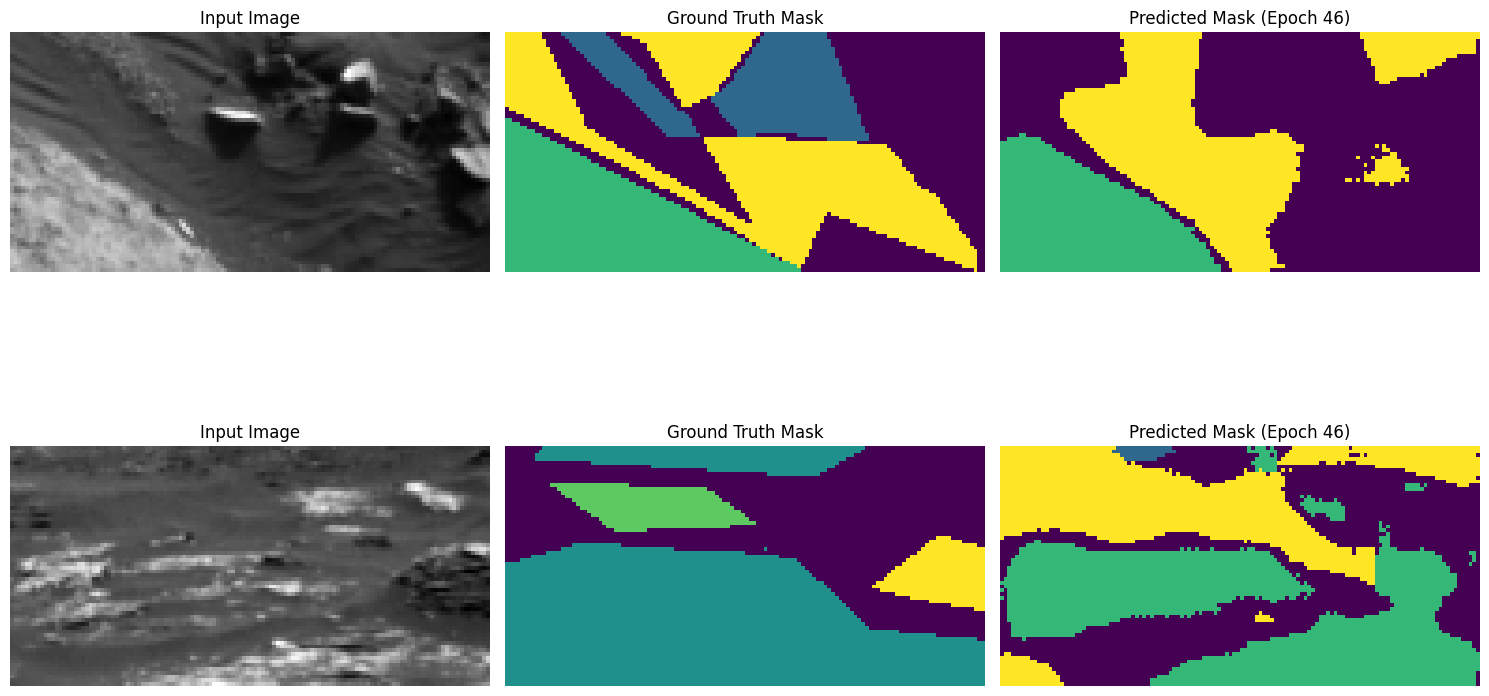

314/314 ━━━━━━━━━━━━━━━━━━━━ 54s 173ms/step - accuracy: 0.8790 - custom_mean_iou: 0.5333 - loss: 0.3139 - mean_io_u: 0.5796 - val_accuracy: 0.7667 - val_custom_mean_iou: 0.4174 - val_loss: 0.7746 - val_mean_io_u: 0.4681 - learning_rate: 6.2500e-06
Epoch 47/1000
313/314 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.8801 - custom_mean_iou: 0.5346 - loss: 0.3112 - mean_io_u: 0.5806Available log keys: dict_keys(['accuracy', 'custom_mean_iou', 'loss', 'mean_io_u', 'val_accuracy', 'val_custom_mean_iou', 'val_loss', 'val_mean_io_u'])

Epoch 47: val_loss did not improve from 0.63431

Epoch 47: ReduceLROnPlateau reducing learning rate to 3.12499992105586e-06.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


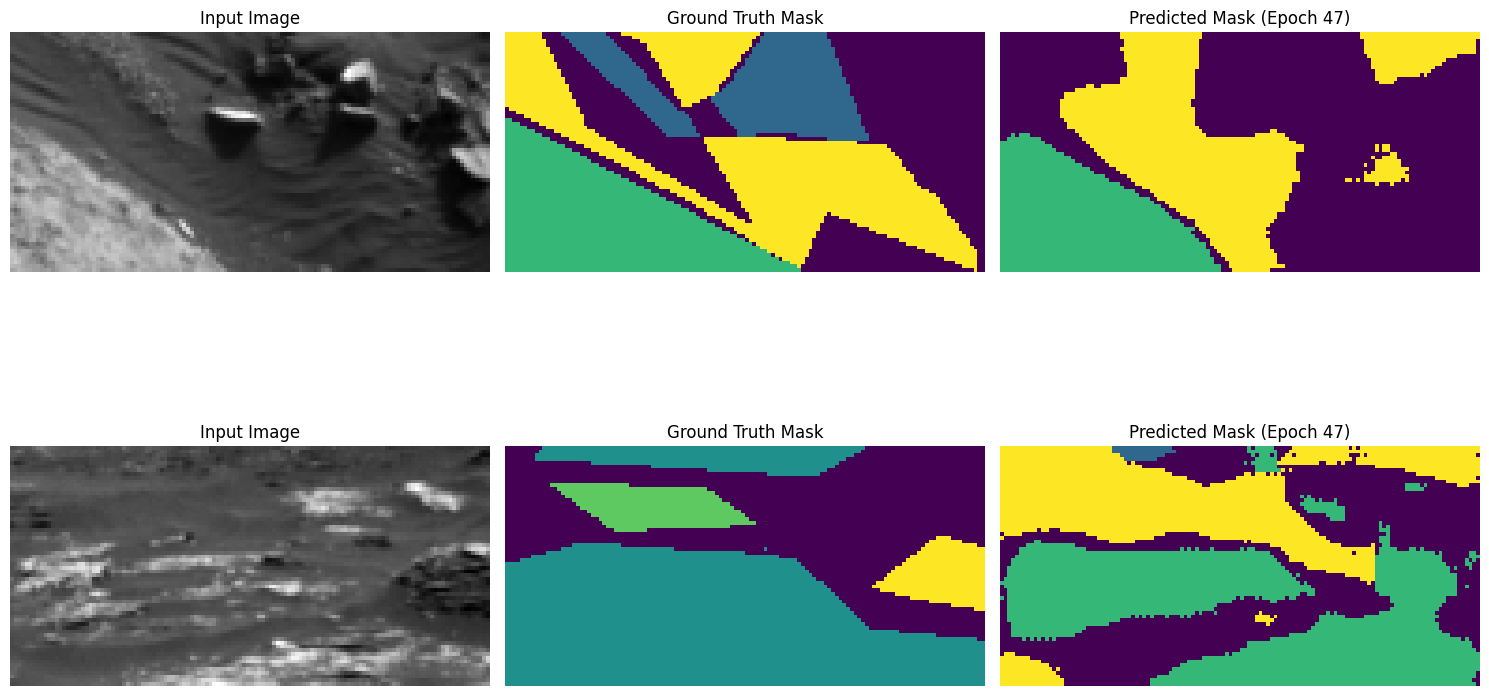

314/314 ━━━━━━━━━━━━━━━━━━━━ 54s 173ms/step - accuracy: 0.8802 - custom_mean_iou: 0.5345 - loss: 0.3112 - mean_io_u: 0.5806 - val_accuracy: 0.7665 - val_custom_mean_iou: 0.4173 - val_loss: 0.7793 - val_mean_io_u: 0.4680 - learning_rate: 6.2500e-06
Epoch 48/1000
313/314 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.8813 - custom_mean_iou: 0.5361 - loss: 0.3082 - mean_io_u: 0.5817Available log keys: dict_keys(['accuracy', 'custom_mean_iou', 'loss', 'mean_io_u', 'val_accuracy', 'val_custom_mean_iou', 'val_loss', 'val_mean_io_u'])
Epoch 48: val_custom_mean_iou improved to 0.4222, saving model.

Epoch 48: val_loss did not improve from 0.63431
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


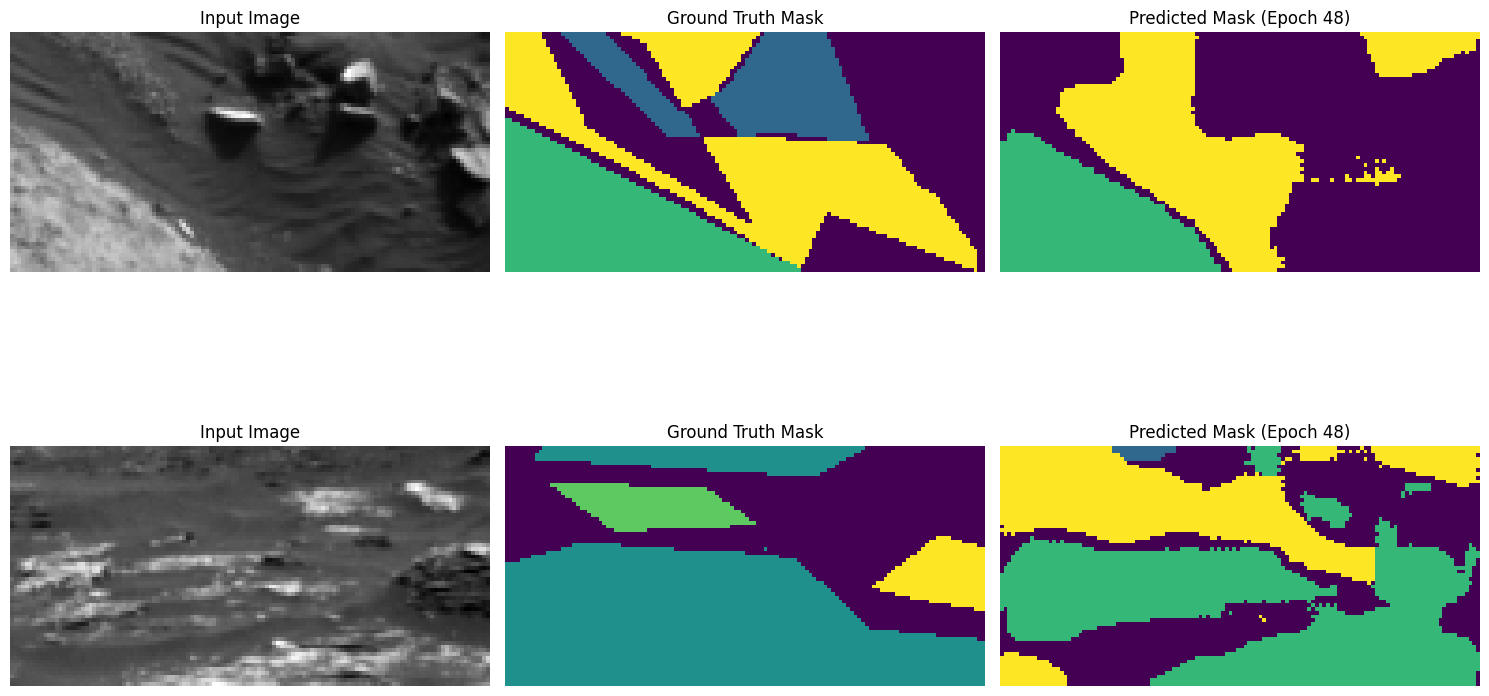

314/314 ━━━━━━━━━━━━━━━━━━━━ 55s 174ms/step - accuracy: 0.8813 - custom_mean_iou: 0.5360 - loss: 0.3082 - mean_io_u: 0.5817 - val_accuracy: 0.7707 - val_custom_mean_iou: 0.4222 - val_loss: 0.7862 - val_mean_io_u: 0.4753 - learning_rate: 3.1250e-06
Epoch 49/1000
313/314 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.8824 - custom_mean_iou: 0.5370 - loss: 0.3056 - mean_io_u: 0.5825Available log keys: dict_keys(['accuracy', 'custom_mean_iou', 'loss', 'mean_io_u', 'val_accuracy', 'val_custom_mean_iou', 'val_loss', 'val_mean_io_u'])

Epoch 49: val_loss did not improve from 0.63431
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


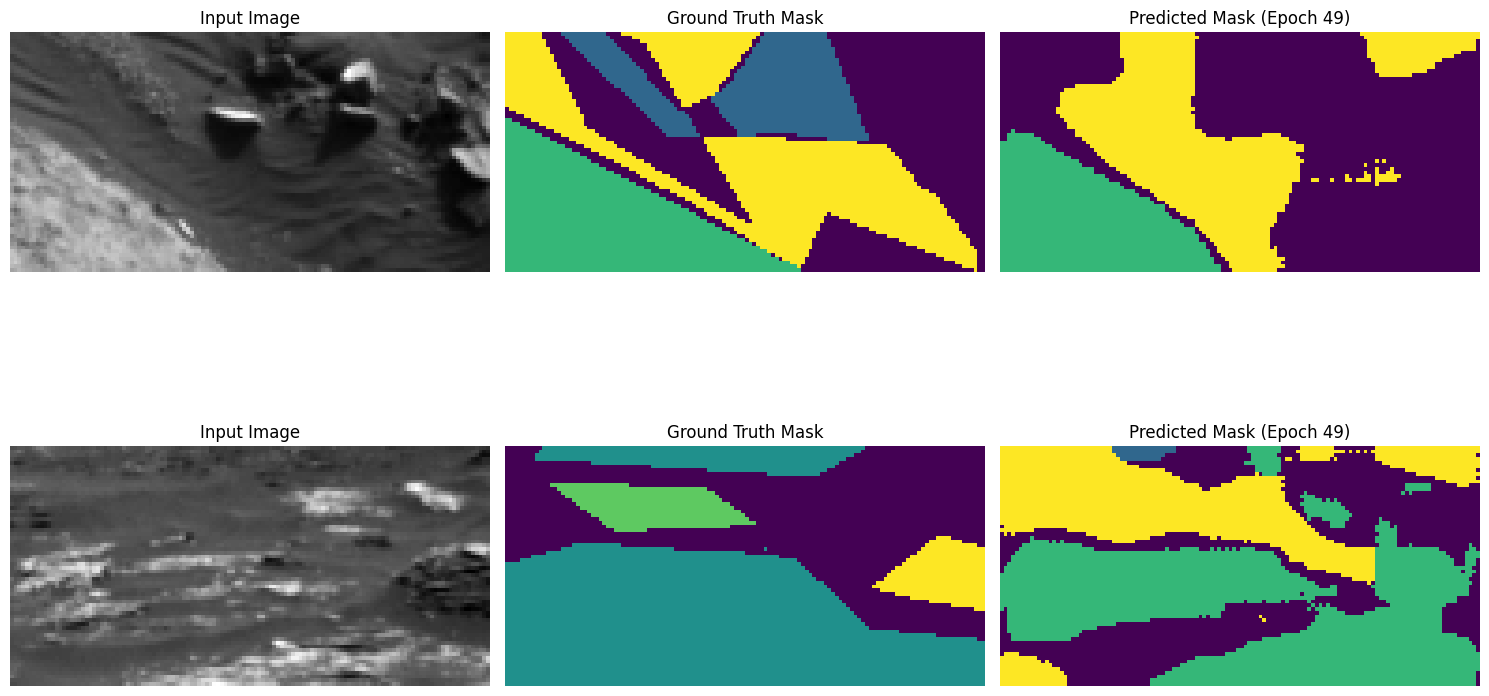

314/314 ━━━━━━━━━━━━━━━━━━━━ 54s 174ms/step - accuracy: 0.8824 - custom_mean_iou: 0.5369 - loss: 0.3055 - mean_io_u: 0.5825 - val_accuracy: 0.7705 - val_custom_mean_iou: 0.4219 - val_loss: 0.7894 - val_mean_io_u: 0.4749 - learning_rate: 3.1250e-06
Epoch 50/1000
313/314 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.8830 - custom_mean_iou: 0.5378 - loss: 0.3039 - mean_io_u: 0.5832Available log keys: dict_keys(['accuracy', 'custom_mean_iou', 'loss', 'mean_io_u', 'val_accuracy', 'val_custom_mean_iou', 'val_loss', 'val_mean_io_u'])

Epoch 50: val_loss did not improve from 0.63431
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


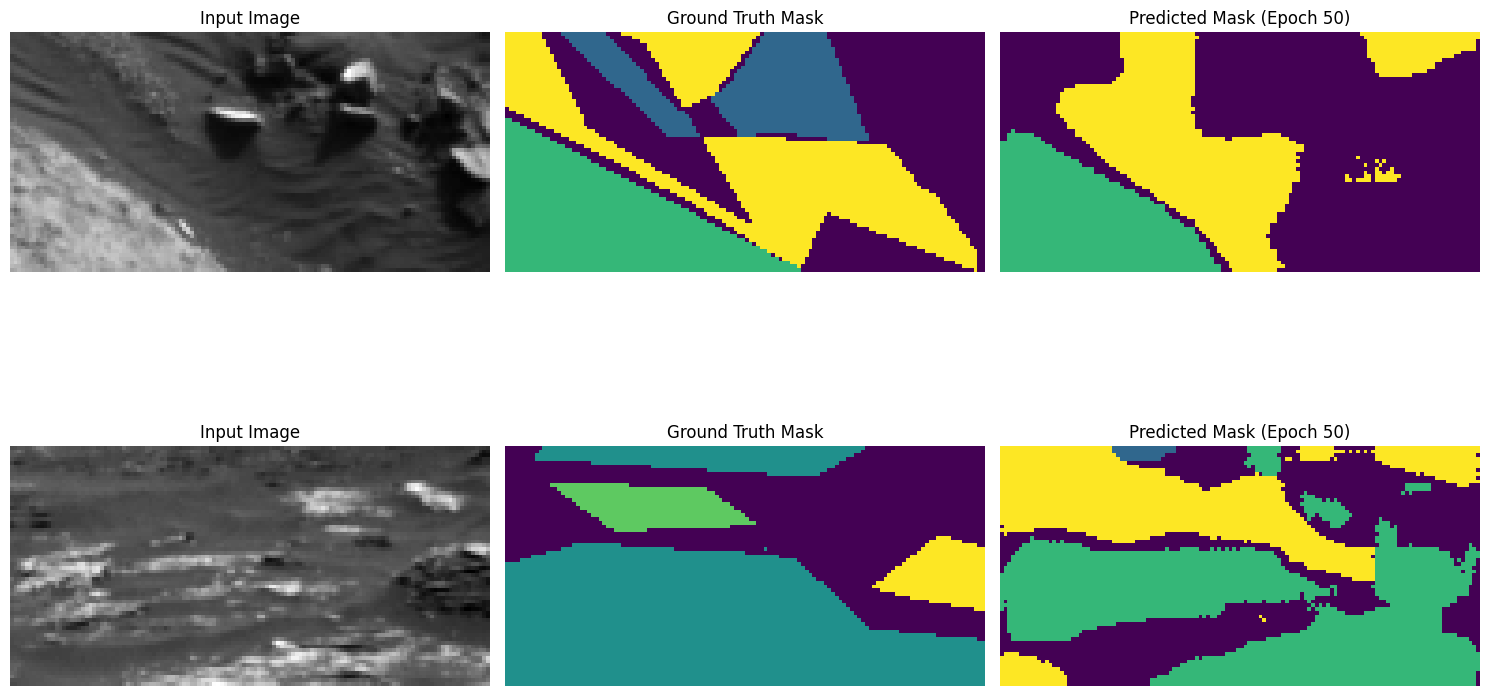

314/314 ━━━━━━━━━━━━━━━━━━━━ 54s 173ms/step - accuracy: 0.8830 - custom_mean_iou: 0.5378 - loss: 0.3039 - mean_io_u: 0.5832 - val_accuracy: 0.7703 - val_custom_mean_iou: 0.4217 - val_loss: 0.7924 - val_mean_io_u: 0.4745 - learning_rate: 3.1250e-06
Epoch 51/1000
313/314 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.8836 - custom_mean_iou: 0.5386 - loss: 0.3024 - mean_io_u: 0.5838Available log keys: dict_keys(['accuracy', 'custom_mean_iou', 'loss', 'mean_io_u', 'val_accuracy', 'val_custom_mean_iou', 'val_loss', 'val_mean_io_u'])

Epoch 51: val_loss did not improve from 0.63431
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


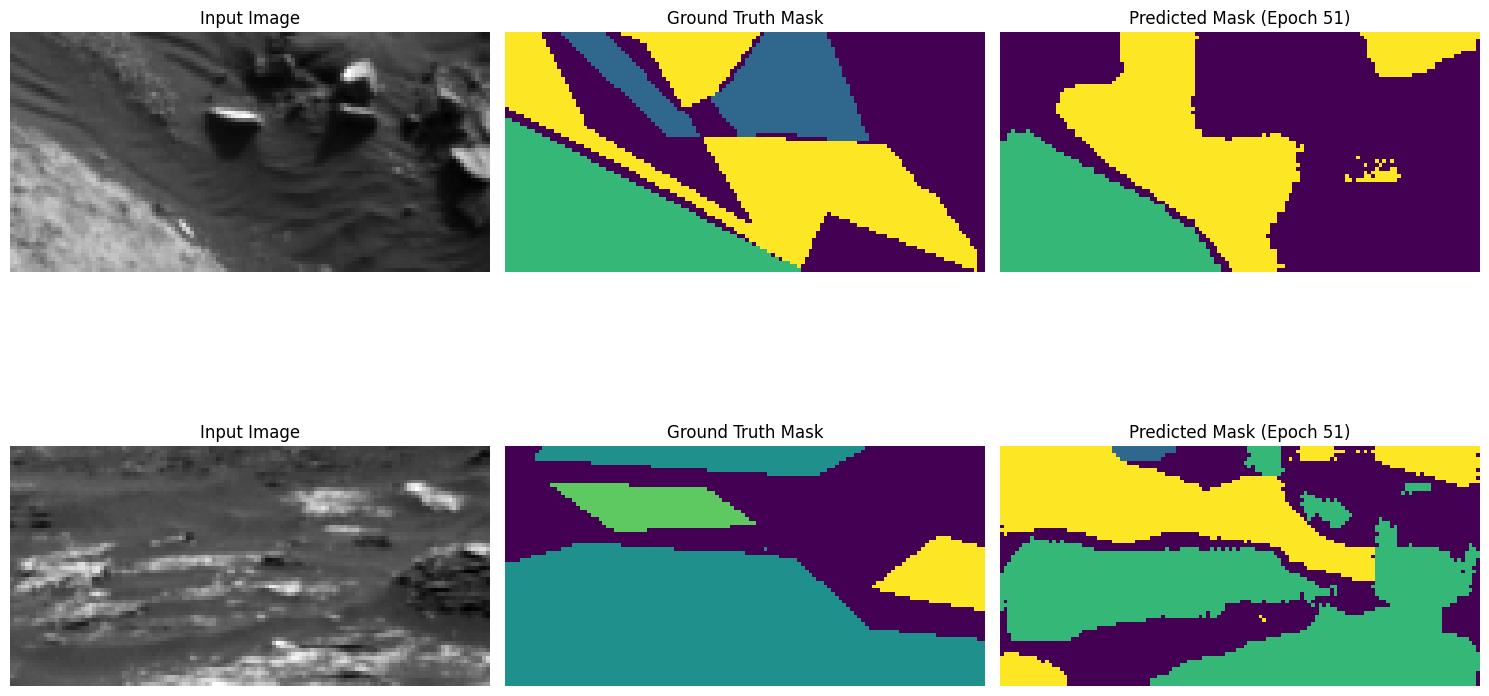

314/314 ━━━━━━━━━━━━━━━━━━━━ 55s 175ms/step - accuracy: 0.8836 - custom_mean_iou: 0.5385 - loss: 0.3024 - mean_io_u: 0.5838 - val_accuracy: 0.7702 - val_custom_mean_iou: 0.4214 - val_loss: 0.7953 - val_mean_io_u: 0.4742 - learning_rate: 3.1250e-06
Epoch 52/1000
313/314 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.8842 - custom_mean_iou: 0.5393 - loss: 0.3010 - mean_io_u: 0.5844Available log keys: dict_keys(['accuracy', 'custom_mean_iou', 'loss', 'mean_io_u', 'val_accuracy', 'val_custom_mean_iou', 'val_loss', 'val_mean_io_u'])

Epoch 52: val_loss did not improve from 0.63431

Epoch 52: ReduceLROnPlateau reducing learning rate to 1.56249996052793e-06.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


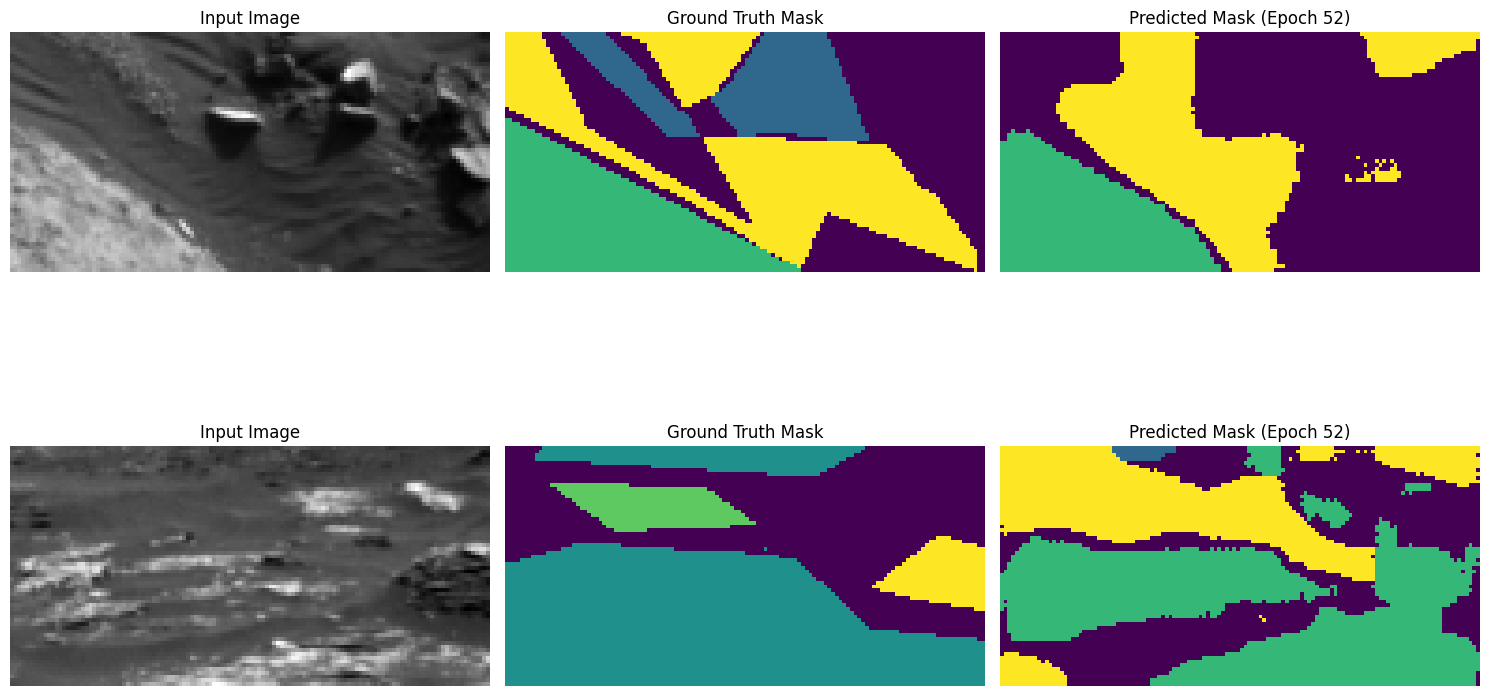

314/314 ━━━━━━━━━━━━━━━━━━━━ 54s 173ms/step - accuracy: 0.8842 - custom_mean_iou: 0.5392 - loss: 0.3009 - mean_io_u: 0.5844 - val_accuracy: 0.7700 - val_custom_mean_iou: 0.4212 - val_loss: 0.7981 - val_mean_io_u: 0.4739 - learning_rate: 3.1250e-06
Epoch 53/1000
313/314 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.8847 - custom_mean_iou: 0.5403 - loss: 0.2999 - mean_io_u: 0.5855Available log keys: dict_keys(['accuracy', 'custom_mean_iou', 'loss', 'mean_io_u', 'val_accuracy', 'val_custom_mean_iou', 'val_loss', 'val_mean_io_u'])

Epoch 53: val_loss did not improve from 0.63431
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


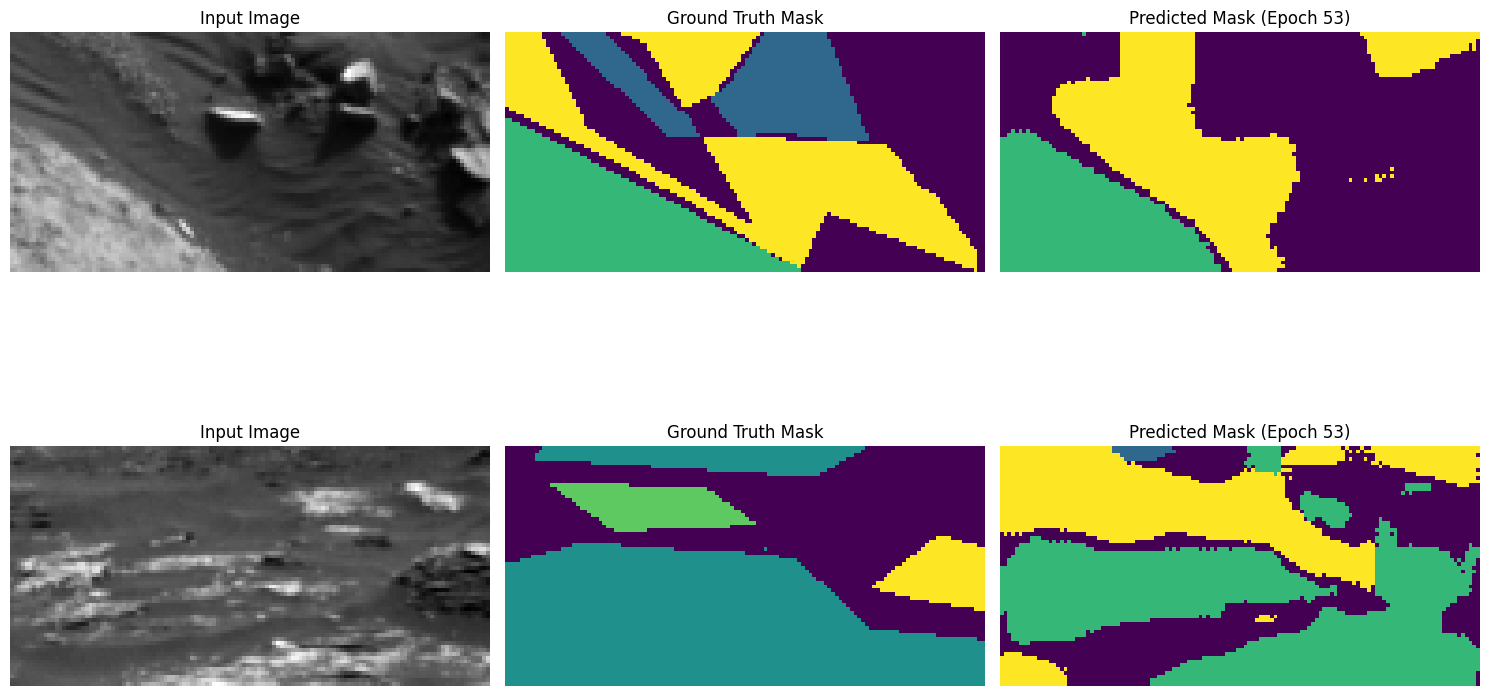

314/314 ━━━━━━━━━━━━━━━━━━━━ 54s 173ms/step - accuracy: 0.8847 - custom_mean_iou: 0.5402 - loss: 0.2999 - mean_io_u: 0.5855 - val_accuracy: 0.7711 - val_custom_mean_iou: 0.4214 - val_loss: 0.7986 - val_mean_io_u: 0.4749 - learning_rate: 1.5625e-06
Epoch 54/1000
313/314 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.8853 - custom_mean_iou: 0.5409 - loss: 0.2984 - mean_io_u: 0.5865Available log keys: dict_keys(['accuracy', 'custom_mean_iou', 'loss', 'mean_io_u', 'val_accuracy', 'val_custom_mean_iou', 'val_loss', 'val_mean_io_u'])

Epoch 54: val_loss did not improve from 0.63431
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


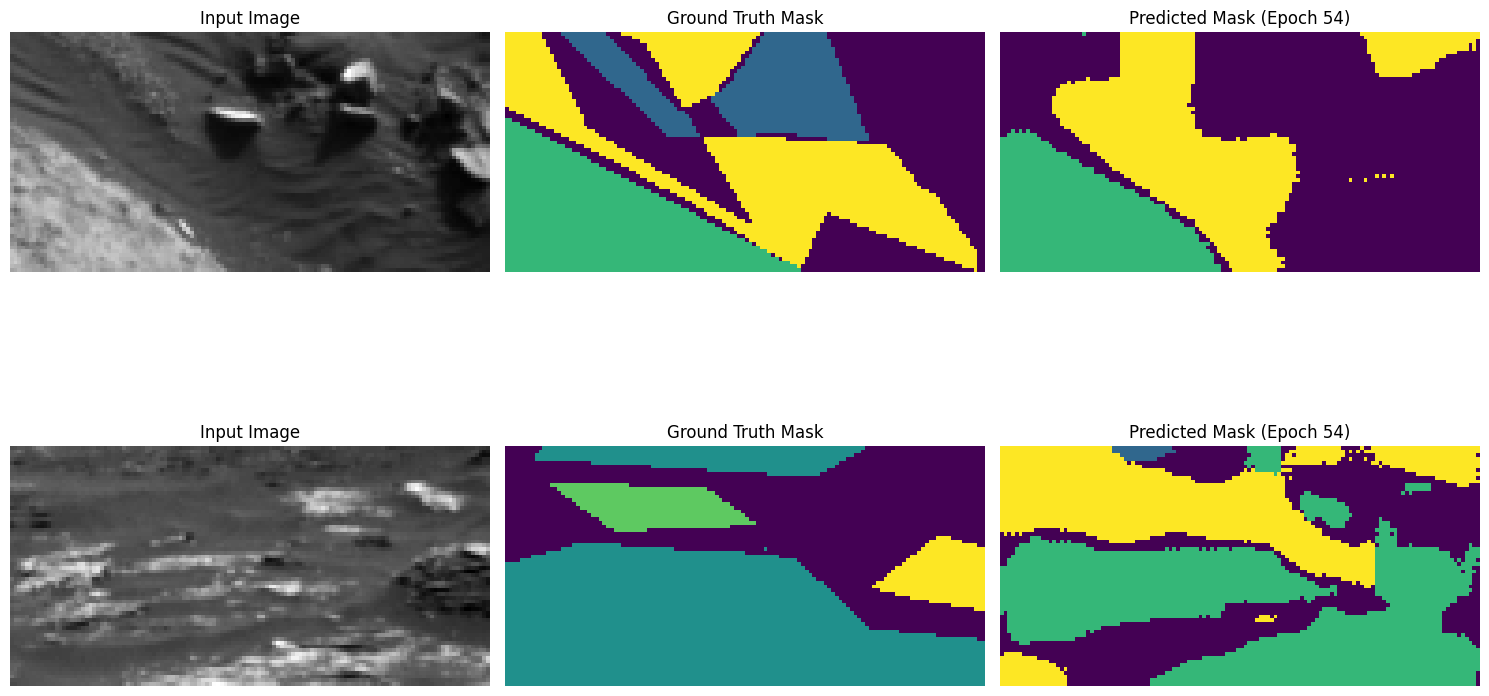

314/314 ━━━━━━━━━━━━━━━━━━━━ 54s 173ms/step - accuracy: 0.8853 - custom_mean_iou: 0.5408 - loss: 0.2984 - mean_io_u: 0.5864 - val_accuracy: 0.7711 - val_custom_mean_iou: 0.4213 - val_loss: 0.8004 - val_mean_io_u: 0.4748 - learning_rate: 1.5625e-06
Epoch 55/1000
313/314 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.8856 - custom_mean_iou: 0.5413 - loss: 0.2975 - mean_io_u: 0.5867Available log keys: dict_keys(['accuracy', 'custom_mean_iou', 'loss', 'mean_io_u', 'val_accuracy', 'val_custom_mean_iou', 'val_loss', 'val_mean_io_u'])

Epoch 55: val_loss did not improve from 0.63431
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


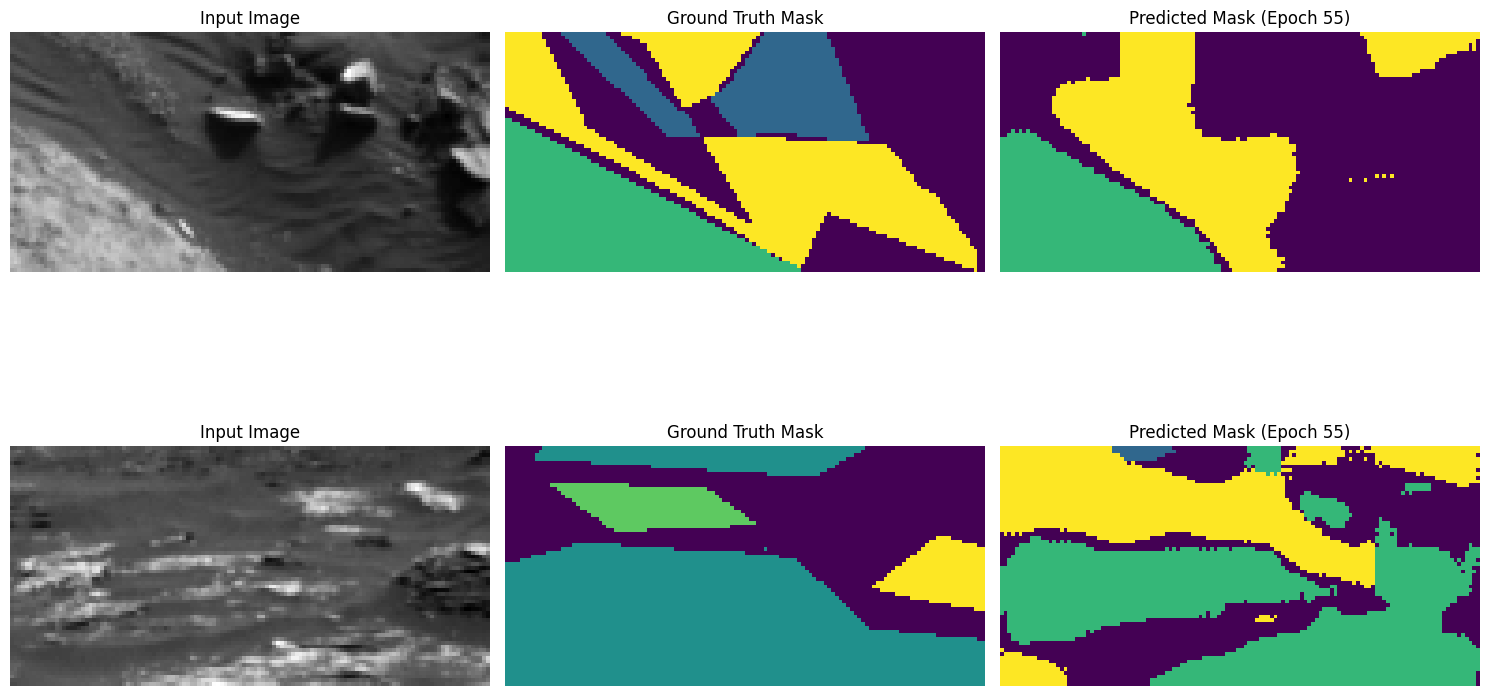

314/314 ━━━━━━━━━━━━━━━━━━━━ 55s 174ms/step - accuracy: 0.8856 - custom_mean_iou: 0.5412 - loss: 0.2975 - mean_io_u: 0.5867 - val_accuracy: 0.7710 - val_custom_mean_iou: 0.4212 - val_loss: 0.8022 - val_mean_io_u: 0.4746 - learning_rate: 1.5625e-06
Epoch 56/1000
313/314 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.8860 - custom_mean_iou: 0.5417 - loss: 0.2967 - mean_io_u: 0.5871Available log keys: dict_keys(['accuracy', 'custom_mean_iou', 'loss', 'mean_io_u', 'val_accuracy', 'val_custom_mean_iou', 'val_loss', 'val_mean_io_u'])

Epoch 56: val_loss did not improve from 0.63431
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


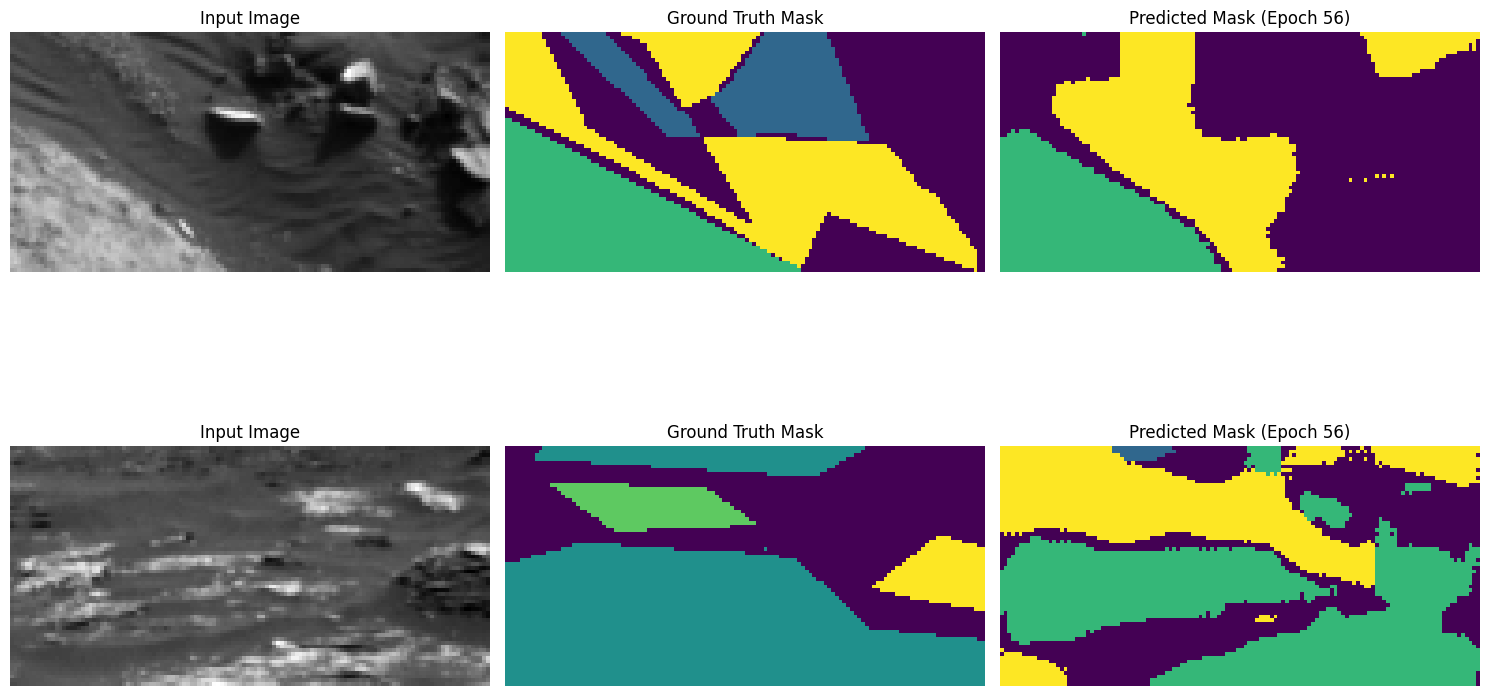

314/314 ━━━━━━━━━━━━━━━━━━━━ 55s 174ms/step - accuracy: 0.8860 - custom_mean_iou: 0.5416 - loss: 0.2967 - mean_io_u: 0.5870 - val_accuracy: 0.7709 - val_custom_mean_iou: 0.4210 - val_loss: 0.8038 - val_mean_io_u: 0.4744 - learning_rate: 1.5625e-06
Epoch 57/1000
313/314 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.8863 - custom_mean_iou: 0.5421 - loss: 0.2960 - mean_io_u: 0.5874Available log keys: dict_keys(['accuracy', 'custom_mean_iou', 'loss', 'mean_io_u', 'val_accuracy', 'val_custom_mean_iou', 'val_loss', 'val_mean_io_u'])

Epoch 57: val_loss did not improve from 0.63431

Epoch 57: ReduceLROnPlateau reducing learning rate to 1e-06.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


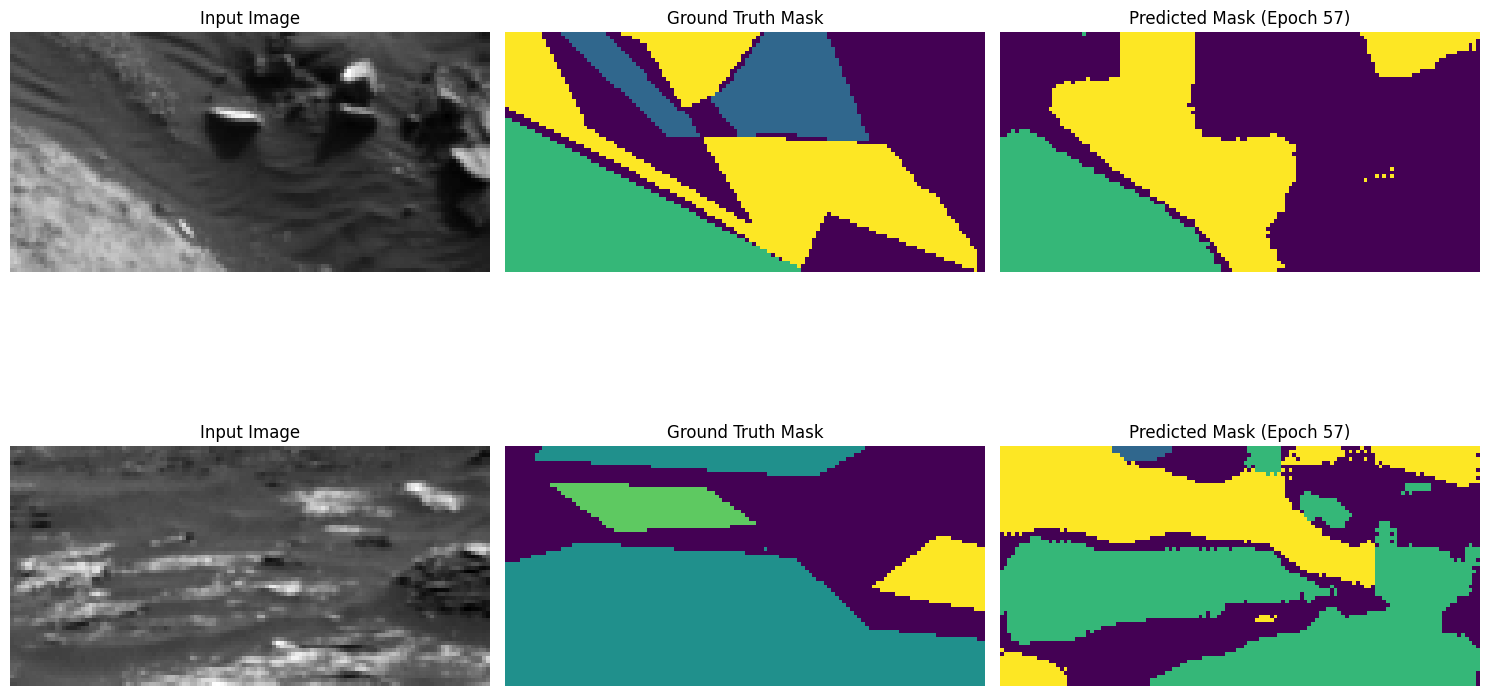

314/314 ━━━━━━━━━━━━━━━━━━━━ 54s 174ms/step - accuracy: 0.8863 - custom_mean_iou: 0.5420 - loss: 0.2959 - mean_io_u: 0.5873 - val_accuracy: 0.7708 - val_custom_mean_iou: 0.4210 - val_loss: 0.8054 - val_mean_io_u: 0.4744 - learning_rate: 1.5625e-06


In [22]:
import tensorflow as tf
from tensorflow.keras import layers as tfkl

# Residual Block
def residual_block(x, filters):
    shortcut = x
    x = tfkl.Conv2D(filters, (3, 3), activation='relu', padding='same')(x)
    x = tfkl.Conv2D(filters, (3, 3), activation='relu', padding='same')(x)
    shortcut = tfkl.Conv2D(filters, (1, 1), padding='same')(shortcut)
    return tfkl.add([x, shortcut])

# Dice Loss
def dice_loss(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred, axis=(1, 2, 3))
    denominator = tf.reduce_sum(y_true + y_pred, axis=(1, 2, 3))
    return tf.reduce_mean(1 - numerator / (denominator + tf.keras.backend.epsilon()))

# Hybrid Loss Function
def combined_loss(weights):
    ce_loss = weighted_categorical_crossentropy(weights)
    def loss(y_true, y_pred):
        return ce_loss(y_true, y_pred) + dice_loss(y_true, y_pred)
    return loss

# U-Net with Residual Connections
def unet_with_residual_blocks(input_shape, num_classes):
    inputs = tfkl.Input(input_shape)

    # Encoder
    c1 = residual_block(inputs, 64)
    p1 = tfkl.MaxPooling2D((2, 2))(c1)

    c2 = residual_block(p1, 128)
    p2 = tfkl.MaxPooling2D((2, 2))(c2)

    c3 = residual_block(p2, 256)
    p3 = tfkl.MaxPooling2D((2, 2))(c3)

    c4 = residual_block(p3, 512)

    # Decoder
    u1 = tfkl.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c4)
    u1 = tfkl.concatenate([u1, c3])
    d1 = residual_block(u1, 256)

    u2 = tfkl.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(d1)
    u2 = tfkl.concatenate([u2, c2])
    d2 = residual_block(u2, 128)

    u3 = tfkl.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(d2)
    u3 = tfkl.concatenate([u3, c1])
    d3 = residual_block(u3, 64)

    outputs = tfkl.Conv2D(num_classes, (1, 1), activation='softmax')(d3)

    return tf.keras.Model(inputs, outputs)

# Initialize the model
input_shape = X_train.shape[1:]
num_classes = 5  # Replace with your number of classes
ignore_class = 0  # Class to ignore

custom_mean_iou = CustomMeanIoU(num_classes=num_classes, ignore_class=0)

model = unet_with_residual_blocks(input_shape, num_classes)
# Define the optimizer with a specific learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
mean_iou = tfk.metrics.MeanIoU(num_classes=num_classes, ignore_class=0, sparse_y_pred=False)
# Compile the model
model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy", mean_iou, custom_mean_iou])

model.summary()
# Define callbacks
save_best_miou = SaveBestMeanIoU(filepath="best_model_mean_iou.h5", monitor="val_custom_mean_iou", mode="max", verbose=1)


# Training the model
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),  # Add validation data
    #batch_size=32,
    epochs=1000,
    callbacks=[save_best_miou, early_stopping, model_checkpoint, reduce_lr, visualize_callback]
)


In [23]:
# Load the saved model
best_model = tf.keras.models.load_model("best_model_mean_iou.h5", custom_objects={"MeanIoU": tf.keras.metrics.MeanIoU})



In [24]:
model=best_model

In [25]:
model_filename = f"model_augmented_hvr_best_invert.keras"
model.save(model_filename)

print(f"Model saved to {model_filename}")

Model saved to model_augmented_hvr_best_invert.keras


## 📊 Prepare Your Submission

In our Kaggle competition, submissions are made as `csv` files. To create a proper `csv` file, you need to flatten your predictions and include an `id` column as the first column of your dataframe. To maintain consistency between your results and our solution, please avoid shuffling the test set. The code below demonstrates how to prepare the `csv` file from your model predictions.



In [26]:
import os
# If model_filename is not defined, load the most recent model from Google Drive
if "model_filename" not in globals() or model_filename is None:
    files = [f for f in os.listdir('.') if os.path.isfile(f) and f.startswith('model_') and f.endswith('.keras')]
    files.sort(key=lambda x: os.path.getmtime(x), reverse=True)
    if files:
        model_filename = files[0]
    else:
        raise FileNotFoundError("No model files found in the current directory.")

In [27]:
print(f"X_test shape before reshaping: {X_test.shape}")

X_test shape before reshaping: (10022, 64, 128, 1)


In [28]:
# Generate predictions
preds = model.predict(X_test)
preds = np.argmax(preds, axis=-1)  # Convert probabilities to class labels
print(f"Predictions shape: {preds.shape}")

314/314 ━━━━━━━━━━━━━━━━━━━━ 21s 66ms/step
Predictions shape: (10022, 64, 128)


Randomly selected indices for prediction (seed=42): [3543 5731 4801  416 5125 9915  293 5020 1765 4192 2288 1188  107 7583
  856 5090 9784 5192 6935  850]


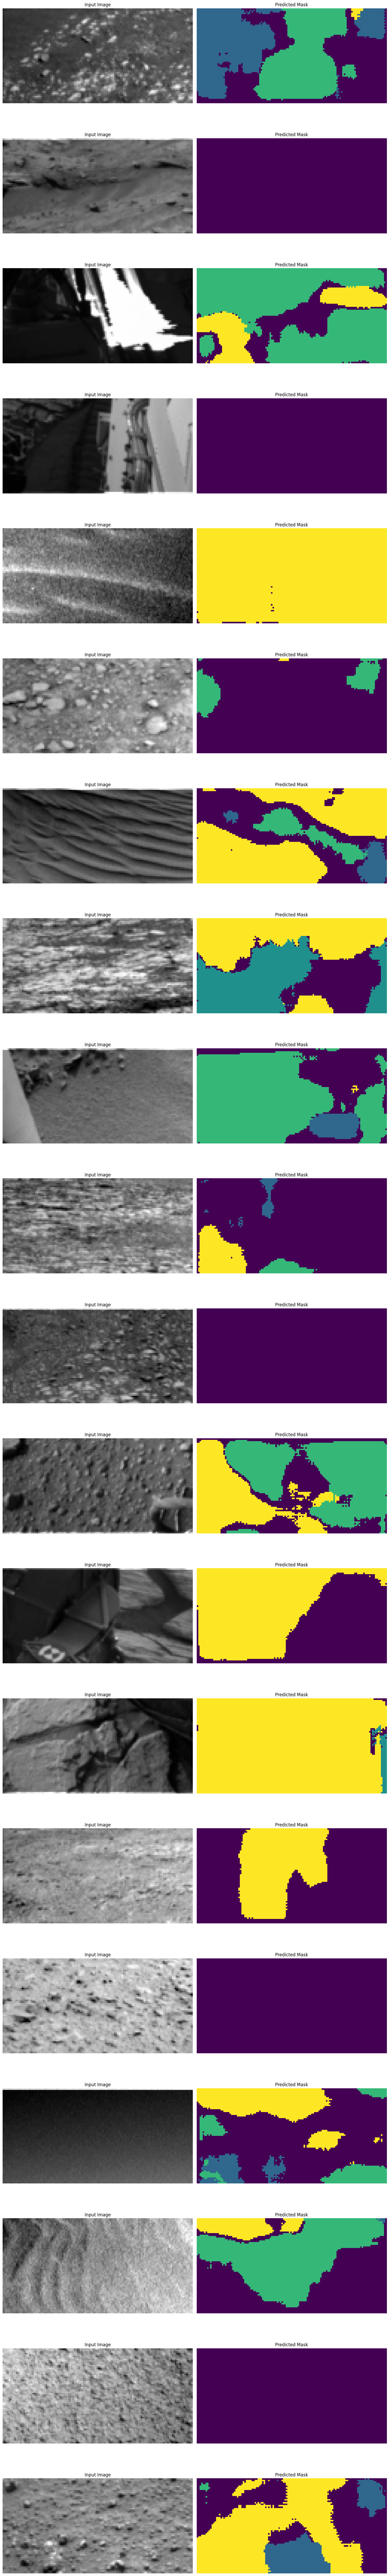

In [29]:
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(42)
# Randomly select 20 indices for prediction
random_indices = np.random.choice(X_test.shape[0], size=20, replace=False)
print(f"Randomly selected indices for prediction (seed=42): {random_indices}")

# Select 20 random samples and their corresponding masks
X_sample = X_test[random_indices]



predicted_masks = preds

# Visualize the predictions
num_images = len(X_sample)  # Number of images to visualize
fig, axes = plt.subplots(num_images, 2, figsize=(15, num_images * 5))

for i in range(num_images):
    # Original Image
    ax_img = axes[i, 0]
    ax_img.imshow(X_sample[i].squeeze(), cmap="gray")
    ax_img.set_title("Input Image")
    ax_img.axis("off")

    # Predicted Mask
    ax_pred = axes[i, 1]
    ax_pred.imshow(predicted_masks[i], cmap="viridis")
    ax_pred.set_title("Predicted Mask")
    ax_pred.axis("off")

plt.tight_layout()
plt.show()

In [30]:
def y_to_df(y) -> pd.DataFrame:
    """Converts segmentation predictions into a DataFrame format for Kaggle."""
    n_samples = len(y)
    y_flat = y.reshape(n_samples, -1)
    df = pd.DataFrame(y_flat)
    df["id"] = np.arange(n_samples)
    cols = ["id"] + [col for col in df.columns if col != "id"]
    return df[cols]

In [31]:
# Create and download the csv submission file
timestep_str = model_filename.replace("model_", "").replace(".keras", "")
submission_filename = f"submission_{timestep_str}.csv"
submission_df = y_to_df(preds)
submission_df.to_csv(submission_filename, index=False)



In [32]:
len(submission_df.columns)

8193

In [33]:
len(submission_df)

10022